# Settings

In this notebook we work with the problem of multi-class classification, that is, the correct assignment of an object to one of the classes. Our goal is to achieve high accuracy of assignment to the correct category. We will use the widely used transfer learning method.


Transfer learning is a machine learning technique that uses a pre-trained model. In this approach, a model trained on one data is used or retrained for use with another set of data. By using transfer learning, you can achieve significantly higher classification accuracy, especially when the available data set is limited.

Before running the code, we need to make sure that we are using the GPU. We plan to work with a convolutional neural network, and using a GPU allows us to reduce training time by several times.

In [1]:
# display information about available GPU devices
!nvidia-smi

Sat Jan 20 02:16:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Import libraries

In [2]:
# Visualization purpose
!pip install tensorboardX
!pip install tensorboard
!pip install tensorboard-plugin-customizable-plots

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 14.7 MB/s eta 0:00:00


In [3]:
!pip install split-folders
!pip install optuna
!pip install --upgrade nvidia-ml-py3
!pip install codecarbon

  Preparing metadata (setup.py) ... - \ done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19189 sha256=4514541b76e8c8d7b6db8ec5842da5e59f173fbe038de20242f35a43fc8dc097
  Stored in directory: /root/.cache/pip/wheels/5c/d8/c0/46899f8be7a75a2ffd197a23c8797700ea858b9b34819fbf9e
Successfully built nvidia-ml-py3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.0/179.0 kB 1.4 MB/s eta 0:00:00


In [4]:
import os
import shutil
import splitfolders
from pathlib import Path
import imghdr
import numpy as np
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt 
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from codecarbon import EmissionsTracker

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [5]:
import warnings
warnings.filterwarnings('ignore')

# Description of the data set

The set used has about 22,000 images of various types of waste, divided into 10 different categories - metal, glass, biological waste, etc.


# Data Preprcessing

In [6]:
prepare_data_emission_tracker = EmissionsTracker()
prepare_data_emission_tracker.start()

[codecarbon INFO @ 02:18:23] [setup] RAM Tracking...
[codecarbon INFO @ 02:18:23] [setup] GPU Tracking...
[codecarbon INFO @ 02:18:23] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 02:18:23] [setup] CPU Tracking...
[codecarbon WARNING @ 02:18:23] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 02:18:25] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 02:18:25] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 02:18:25] >>> Tracker's metadata:
[codecarbon INFO @ 02:18:25]   Platform system: Linux-5.15.133+-x86_64-with-glibc2.35
[codecarbon INFO @ 02:18:25]   Python version: 3.10.10
[codecarbon INFO @ 02:18:25]   CodeCarbon version: 2.3.2
[codecarbon INFO @ 02:18:25]   Available RAM : 31.358 GB
[codecarbon INFO @ 02:18:25]   CPU count: 4
[codecarbon INFO @ 02:18:25]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 02:18:25]   GPU

In [7]:
data_dir = '/kaggle/input/garbage-classification-v2/'

Cleaning the working directory if there are any files in it

In [8]:
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)
# os.rmdir(folder_path)

Copying the dataset to the working directory to allow data cleaning

In [9]:
shutil.copytree(data_dir, '/kaggle/working/dataset')

[codecarbon INFO @ 02:18:43] Energy consumed for RAM : 0.000049 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:18:43] Energy consumed for all GPUs : 0.000078 kWh. Total GPU Power : 18.667263685972024 W
[codecarbon INFO @ 02:18:43] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:18:43] 0.000304 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:18:58] Energy consumed for RAM : 0.000098 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:18:58] Energy consumed for all GPUs : 0.000156 kWh. Total GPU Power : 18.693710432568338 W
[codecarbon INFO @ 02:18:58] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:18:58] 0.000608 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:19:13] Energy consumed for RAM : 0.000147 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:19:13] Energy consumed for all GPUs : 0.000233 kWh. Total GPU Power : 18.639310488

'/kaggle/working/dataset'

In [10]:
data_dir  = '/kaggle/working/dataset'

In [11]:
experiment_name = "Transfer Learning"

The Tensorflow library that we are going to use does not support some image formats, in addition, the dataset may have corrupted or non-image files. Let's pre-clean the dataset.

In [12]:
count=0
image_extensions = [".png", ".jpg"] 
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        if img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)
            count+=1
print(f"Removed {count} images")

/kaggle/working/dataset/metal/metal_1441.jpg is not an image
/kaggle/working/dataset/metal/metal_1441.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/glass/glass_4432.jpg is not an image
/kaggle/working/dataset/glass/glass_4432.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/glass/glass_4727.jpg is not an image
/kaggle/working/dataset/glass/glass_4727.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/glass/glass_2014.jpg is not an image
/kaggle/working/dataset/glass/glass_2014.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/glass/glass_1512.jpg is not an image
/kaggle/working/dataset/glass/glass_1512.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/glass/glass_4463.jpg is not an image
/kaggle/working/dataset/glass/glass_4463.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/glass/glass_2835.jpg is not an image
/kaggle/working/dataset/glass/glass_2835.jpg is a None, not accepted by Ten

To train the model, you will need to divide the data into several samples, so we will create folders for them

In [13]:
os.mkdir('data')

In [14]:
os.chdir('data')

In [15]:
os.getcwd()

'/kaggle/working/data'

In [16]:
os.mkdir('train')
os.mkdir('test')
os.mkdir('val')

In [17]:
os.chdir('/kaggle/working/')

In [18]:
os.getcwd()

'/kaggle/working'

Let's set a random value for reproducibility of the result. In particular, when splitting the dataset randomly (as in the following block of code), a fixed SEED value ensures that we get exactly the same split of data next time.

In [19]:
SEED = 42

Let's divide the data from the dataset into three folders - for training and test samples.

In [20]:
splitfolders.ratio("/kaggle/working/dataset", output = 'data', seed = SEED, ratio = (.8,.1,.1), group_prefix = None)

Copying files: 23584 files [00:03, 6089.18 files/s]


In [21]:
data_dir

'/kaggle/working/dataset'

You can now delete the unused dataset folder to save space.

In [22]:
try:
    shutil.rmtree(data_dir)
except OSError as e:
    print("Error: %s : %s" % (data_dir, e.strerror))

Setting paths to training and test data

In [23]:
train_path = '/kaggle/working/data/train'
val_path = '/kaggle/working/data/val'
test_path = '/kaggle/working/data/test'

Visualization of data from a dataset

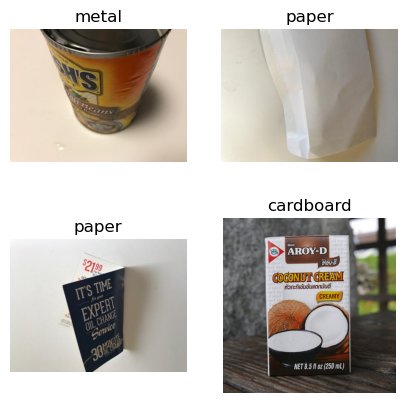

In [24]:
fig, axes = plt.subplots(2, 2, figsize = (5,5)) #выведем 4 изображения
axes = axes.ravel() 

for i in np.arange(0, 4): 

    category = random.choice(os.listdir(train_path)) #случайный выбор класса
    class_dir = os.path.join(train_path, category)

    image = random.choice(os.listdir(class_dir)) #cлучайный выбор изображения из класса
 
    img = plt.imread(os.path.join(class_dir,image))
    axes[i].imshow( img )
    axes[i].set_title(category) 
    axes[i].axis('off')

Let's look at the distribution of data between classes.

In [25]:
total = 0
for category in os.listdir(train_path):
    count= 0
    for image in os.listdir(train_path + "/" + category):
        count += 1
        total +=1
    print(str(category).title() + ": " + str(count))  
print(f"\nTotal number of train images: {total}")

Battery: 756
Metal: 1494
Trash: 667
Glass: 3272
Shoes: 1581
Plastic: 2013
Biological: 788
Clothes: 4260
Paper: 2169
Cardboard: 1864

Total number of train images: 18864


It is noticeable that in some classes the number of images differs several times. Let's visualize the distribution of classes for clarity.

In [26]:
# class names
class_names = sorted(os.listdir(train_path))
class_names

['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']

In [27]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]
class_dis

[756, 788, 1864, 4260, 3272, 1494, 2169, 2013, 1581, 667]

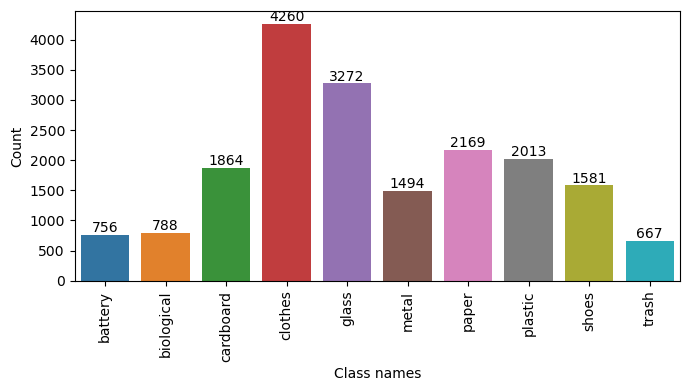

In [28]:
DF = pd.DataFrame(columns=['Class names','Count'])
DF['Class names']=class_names
DF['Count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='Class names', y='Count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

A situation where one or more classes contain a significantly larger number of images is called class imbalance. In our situation, it is natural and determined by the specifics of the data. Thus, there are many more varieties of clothing or glass objects than batteries. However, this may negatively affect the training results of the model and cause it to be biased towards the largest class (that is, it will be much worse at classifying smaller classes). There are different approaches to solving this problem, the applicability of which depends on the problem being solved. We will use the method of insufficient sampling (*random undersampling*), which consists of randomly excluding some examples from large classes.

Excluding some random images from the training data

In [29]:
for category in os.listdir(train_path):
    count = 0
    delete = 0
    for image in os.listdir(train_path + '/'  + category):
        count += 1
        while count > 1000:
            random_image = random.choice(os.listdir(train_path + '/' + category)) 
            delete_image = train_path + '/'  + category +  '/' + random_image
            os.remove(delete_image)
            delete+=1
            count-=1
           
    print(f'Deleted {delete} in {category}')


Deleted 0 in battery
Deleted 494 in metal
Deleted 0 in trash


[codecarbon INFO @ 02:22:13] Energy consumed for RAM : 0.000734 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:22:13] Energy consumed for all GPUs : 0.001169 kWh. Total GPU Power : 19.107271405234805 W
[codecarbon INFO @ 02:22:13] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:22:13] 0.004560 kWh of electricity used since the beginning.


Deleted 2272 in glass
Deleted 581 in shoes
Deleted 1013 in plastic
Deleted 0 in biological
Deleted 3260 in clothes
Deleted 1169 in paper
Deleted 864 in cardboard


We limited the number of images in large classes to 1000. Let's see what the class distribution looks like now

In [30]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]

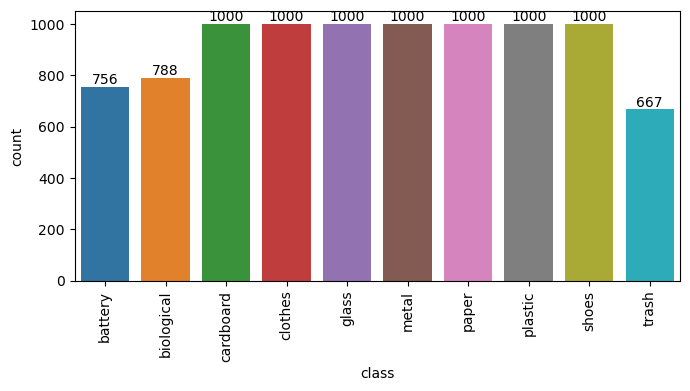

In [31]:
DF = pd.DataFrame(columns=['class','count'])
DF['class']=class_names
DF['count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='class', y='count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

The data distribution now looks much better, although some image classes are still quite sparse. We will try to solve this problem using augmentation methods that we integrate into the model.

In [32]:
data_path = '/kaggle/working/data'

To train a neural network, it is necessary to ensure unification of image sizes. To do this, let’s find the average width and height of images in the entire dataset.

In [33]:
width = []
height = []
from PIL import Image
import numpy as np

for dirname in os.listdir(data_path):
    for category in os.listdir(data_path + '/' + dirname):
        for image in os.listdir(data_path + '/' + dirname + '/' + category):
            img = Image.open(data_path + '/' + dirname + '/' + category + '/' + image)
            width.append(img.width)
            height.append(img.height)

print('Mean width: {:.4f}'.format(np.mean(width)))
print('Mean Height: {:.4f}'.format(np.mean(height)))

Mean width: 415.8676
Mean Height: 395.5131


Let's set the size of the input data (image size) taking into account the found average values

In [34]:
IMG_SIZE = (400, 400)

Let's set the size of the data package for loading images into the model in parts

In [35]:
BATCH_SIZE = 32


Create a SummaryWriter instance to write logs

In [36]:
writer = SummaryWriter()

Previously, we divided the entire amount of data into three sets. Now you need to prepare them for working with the model - distribute them into packages and add labels to them. Data packets generated from the train folder, constituting 80% of the total number of images, will be used to train the model, from the val(10%) folder - for checking during training and adjusting parameters, and from the test folder - to evaluate the accuracy of the model on new data not used during training.


In [37]:
train_data = tf.keras.utils.image_dataset_from_directory(train_path,
                                                         image_size=IMG_SIZE,
                                                         label_mode='categorical',
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         seed=SEED)

Found 9211 files belonging to 10 classes.


[codecarbon INFO @ 02:22:28] Energy consumed for RAM : 0.000784 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:22:28] Energy consumed for all GPUs : 0.001254 kWh. Total GPU Power : 20.319460672529864 W
[codecarbon INFO @ 02:22:28] Energy consumed for all CPUs : 0.002834 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:22:28] 0.004871 kWh of electricity used since the beginning.


In [38]:
test_data = tf.keras.utils.image_dataset_from_directory(test_path,
                                                        image_size=IMG_SIZE,
                                                        label_mode='categorical',
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=False)

Found 2366 files belonging to 10 classes.


In [39]:
validation_data = tf.keras.utils.image_dataset_from_directory(val_path,
                                                              image_size=IMG_SIZE,
                                                              label_mode='categorical',
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=True,
                                                              seed=SEED)

Found 2354 files belonging to 10 classes.


Create directories for train and test logs and write logs to it 

In [40]:
train_log_dir = os.path.join("logs", experiment_name, "train")
test_log_dir = os.path.join("logs", experiment_name, "test")

os.makedirs(train_log_dir, exist_ok=True)
os.makedirs(test_log_dir, exist_ok=True)

train_writer = SummaryWriter(train_log_dir)
test_writer = SummaryWriter(test_log_dir)


In [41]:
prepare_data_emissions: float = prepare_data_emission_tracker.stop()
print(f"Prepare Data Carbon Emissions: {prepare_data_emissions} kg")

[codecarbon INFO @ 02:22:29] Energy consumed for RAM : 0.000787 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:22:29] Energy consumed for all GPUs : 0.001267 kWh. Total GPU Power : 51.254445148142274 W
[codecarbon INFO @ 02:22:29] Energy consumed for all CPUs : 0.002845 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:22:29] 0.004899 kWh of electricity used since the beginning.


Prepare Data Carbon Emissions: 0.002217376549560422 kg


# Building the model

When selecting a model, we examined the classification models available in Keras with pre-trained weights on the public ImageNet dataset, which includes about 1000 categories of various images (https://keras.io/api/applications/).
For our task, the most important parameter is the classification accuracy. Based on the accuracy values presented in the table (acc1, percentage of correct answers), the EfficientNetV2M model is selected. Although the EfficientNetV2M and EfficientNetV2L models have higher accuracy, they have significantly higher weights.


In [42]:
develop_model_emission_tracker = EmissionsTracker()
develop_model_emission_tracker.start()

[codecarbon INFO @ 02:22:29] [setup] RAM Tracking...
[codecarbon INFO @ 02:22:29] [setup] GPU Tracking...
[codecarbon INFO @ 02:22:29] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 02:22:29] [setup] CPU Tracking...
[codecarbon WARNING @ 02:22:29] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 02:22:31] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 02:22:31] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 02:22:31] >>> Tracker's metadata:
[codecarbon INFO @ 02:22:31]   Platform system: Linux-5.15.133+-x86_64-with-glibc2.35
[codecarbon INFO @ 02:22:31]   Python version: 3.10.10
[codecarbon INFO @ 02:22:31]   CodeCarbon version: 2.3.2
[codecarbon INFO @ 02:22:31]   Available RAM : 31.358 GB
[codecarbon INFO @ 02:22:31]   CPU count: 4
[codecarbon INFO @ 02:22:31]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 02:22:31]   GPU

Loading the model

In [43]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2M(include_top=False,
                                                   weights='imagenet', 
                                                   input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

214201816/214201816 [==============================] - 1s 0us/step


Let's see what the architecture of the pretrained model looks like

In [44]:
base_model.summary()

Model: "efficientnetv2-m"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 400, 400, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 200, 200, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

The architecture of the model we are using already has a Rescale layer, so we may not include an additional image normalization layer in our model.ь.

Let's freeze all layers of the pretrained model so that its parameters do not change during training.

In [45]:
base_model.trainable = False

Let's create a data augmentation layer to improve classification accuracy. This layer is active only during model training.

In [46]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.RandomRotation(0.2), 
                                         tf.keras.layers.RandomZoom(0.2),
                                         tf.keras.layers.RandomHeight(0.2),
                                         tf.keras.layers.RandomWidth(0.2),],
                                         name ="data_augmentation")

Let's see how this layer works with images from the training set.

[codecarbon INFO @ 02:22:49] Energy consumed for RAM : 0.000049 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:22:49] Energy consumed for all GPUs : 0.000214 kWh. Total GPU Power : 51.37018719425347 W
[codecarbon INFO @ 02:22:49] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:22:49] 0.000441 kWh of electricity used since the beginning.


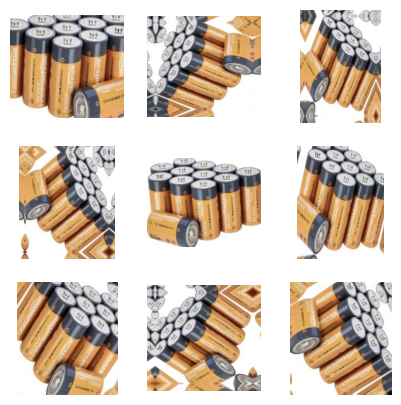

In [47]:
for image, _ in train_data.take(1):  
    plt.figure(figsize=(5, 5))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Let's combine the model with the augmentation layer, and also add several layers:

* GlobalAveragePooling2D layer, which calculates the arithmetic average over all channels to combine feature maps
* A fully connected layer with 128 neurons and a Dropout layer, which excludes some neurons from the previous fully connected layer with a given probability, thereby reducing the possible effect of overfitting.
* Output fully connected layer with the number of outputs corresponding to the number of classes of our data.

In [48]:
name="EfficientNetV2M"

EfficientNetV2M_model=tf.keras.Sequential([tf.keras.Input(shape=(None, None, 3), name="input_layer"),
                    data_augmentation,
                    base_model,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(len(class_names), activation='softmax')
                    ], name=name)

For training, we will define a loss function, an optimizer, and a tracked accuracy metric

In [49]:
EfficientNetV2M_model.compile(loss='categorical_crossentropy',
                              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                              metrics=['accuracy'])

Let's look at the structure of our model

In [50]:
EfficientNetV2M_model.summary()

Model: "EfficientNetV2M"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-m (Functiona  (None, 13, 13, 1280)     53150388  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                   

The summary already shows the advantage of using a pre-trained model - out of more than 20 million parameters, only 165 thousand are trainable, which will significantly reduce training time.

While training the models, we will use a callback function to stop training when the metrics being tracked stop improving. After this, we will save the trained model and weights for further use.

In [51]:
# def log_to_tensorboard(epoch, logs):
#         train_writer.add_scalar('loss', logs['loss'], epoch)
#         train_writer.add_scalar('accuracy', logs['accuracy'], epoch)
#         test_writer.add_scalar('val_loss', logs['val_loss'], epoch)
#         test_writer.add_scalar('val_accuracy', logs['val_accuracy'], epoch)
def log_to_tensorboard(epoch, logs):
    train_writer.add_scalar('loss', logs['loss'], epoch)
    train_writer.add_scalar('accuracy', logs['accuracy'], epoch)
    
    # Use get method with a default value of None to avoid KeyError
    val_loss = logs.get('val_loss', None)
    val_accuracy = logs.get('val_accuracy', None)
    
    if val_loss is not None:
        test_writer.add_scalar('val_loss', val_loss, epoch)
    if val_accuracy is not None:
        test_writer.add_scalar('val_accuracy', val_accuracy, epoch)


# Creating a Callback Function
def create_callback(model_name):
    
    # termination of training when accuracy does not improve within 3 epochs
    early_stop = tf.keras.callbacks.EarlyStopping(patience=3,
                                                monitor="val_loss",
                                                mode="min",
                                                verbose=1)

    # decrease in learning rate when the error rate does not decrease over 2 epochs
    reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                              factor=0.2,
                                                              patience=2,
                                                              verbose=1,
                                                              min_lr=0.00001)

    log_to_tensorboard_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: log_to_tensorboard(epoch, logs))
    # saving model
    check_model = tf.keras.callbacks.ModelCheckpoint(model_name + ".h5",
                                                   monitor="val_accuracy",
                                                   mode="max",
                                                   save_best_only=True)
    callback = [early_stop, reduce_learning_rate, check_model, log_to_tensorboard_callback]
    return callback

In [52]:
EfficientNetV2M_callback = create_callback(name)

Let's set the number of training epochs

In [53]:
EPOCH=20

Let's train the model

In [54]:
import time
start_time = time.time()
EfficientNetV2M_history = EfficientNetV2M_model.fit(train_data, 
                                                    epochs=EPOCH, 
                                                    steps_per_epoch=len(train_data),
                                                    validation_data=validation_data, 
                                                    validation_steps=len(validation_data),
                                                    callbacks=EfficientNetV2M_callback)

Epoch 1/20


[codecarbon INFO @ 02:23:04] Energy consumed for RAM : 0.000098 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:23:04] Energy consumed for all GPUs : 0.000430 kWh. Total GPU Power : 51.73352126169359 W
[codecarbon INFO @ 02:23:04] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:23:04] 0.000882 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:23:19] Energy consumed for RAM : 0.000147 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:23:19] Energy consumed for all GPUs : 0.000646 kWh. Total GPU Power : 52.036347635275106 W
[codecarbon INFO @ 02:23:19] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:23:19] 0.001325 kWh of electricity used since the beginning.
2024-01-20 02:23:21.787752: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2M

  3/288 [..............................] - ETA: 9:49 - loss: 2.2642 - accuracy: 0.1771 

[codecarbon INFO @ 02:23:34] Energy consumed for RAM : 0.000196 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:23:34] Energy consumed for all GPUs : 0.000943 kWh. Total GPU Power : 71.20088835789016 W
[codecarbon INFO @ 02:23:34] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:23:34] 0.001847 kWh of electricity used since the beginning.


 10/288 [>.............................] - ETA: 9:35 - loss: 1.9988 - accuracy: 0.4313

[codecarbon INFO @ 02:23:49] Energy consumed for RAM : 0.000245 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:23:49] Energy consumed for all GPUs : 0.001345 kWh. Total GPU Power : 96.57445392690421 W
[codecarbon INFO @ 02:23:49] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:23:49] 0.002475 kWh of electricity used since the beginning.


 17/288 [>.............................] - ETA: 9:28 - loss: 1.7758 - accuracy: 0.5460

[codecarbon INFO @ 02:24:04] Energy consumed for RAM : 0.000294 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:24:04] Energy consumed for all GPUs : 0.001745 kWh. Total GPU Power : 96.05804110593782 W
[codecarbon INFO @ 02:24:04] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:24:04] 0.003101 kWh of electricity used since the beginning.


 24/288 [=>............................] - ETA: 9:12 - loss: 1.5442 - accuracy: 0.6302

[codecarbon INFO @ 02:24:19] Energy consumed for RAM : 0.000343 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:24:19] Energy consumed for all GPUs : 0.002146 kWh. Total GPU Power : 96.30139660453408 W
[codecarbon INFO @ 02:24:19] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:24:19] 0.003728 kWh of electricity used since the beginning.


 32/288 [==>...........................] - ETA: 8:46 - loss: 1.3672 - accuracy: 0.6738

[codecarbon INFO @ 02:24:34] Energy consumed for RAM : 0.000392 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:24:34] Energy consumed for all GPUs : 0.002547 kWh. Total GPU Power : 96.26945370004552 W
[codecarbon INFO @ 02:24:34] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:24:34] 0.004355 kWh of electricity used since the beginning.


 40/288 [===>..........................] - ETA: 8:24 - loss: 1.2456 - accuracy: 0.6969

[codecarbon INFO @ 02:24:49] Energy consumed for RAM : 0.000441 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:24:49] Energy consumed for all GPUs : 0.002949 kWh. Total GPU Power : 96.65958772149641 W
[codecarbon INFO @ 02:24:49] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:24:49] 0.004984 kWh of electricity used since the beginning.


 48/288 [====>.........................] - ETA: 8:02 - loss: 1.1371 - accuracy: 0.7214

[codecarbon INFO @ 02:25:04] Energy consumed for RAM : 0.000490 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:25:04] Energy consumed for all GPUs : 0.003353 kWh. Total GPU Power : 96.85532497234928 W
[codecarbon INFO @ 02:25:04] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:25:04] 0.005613 kWh of electricity used since the beginning.


 55/288 [====>.........................] - ETA: 7:50 - loss: 1.0717 - accuracy: 0.7324

[codecarbon INFO @ 02:25:19] Energy consumed for RAM : 0.000539 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:25:19] Energy consumed for all GPUs : 0.003758 kWh. Total GPU Power : 97.39235872735144 W
[codecarbon INFO @ 02:25:19] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:25:19] 0.006245 kWh of electricity used since the beginning.


 62/288 [=====>........................] - ETA: 7:34 - loss: 1.0122 - accuracy: 0.7450

[codecarbon INFO @ 02:25:34] Energy consumed for RAM : 0.000588 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:25:34] Energy consumed for all GPUs : 0.004160 kWh. Total GPU Power : 96.41193306784054 W
[codecarbon INFO @ 02:25:34] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:25:34] 0.006872 kWh of electricity used since the beginning.


 70/288 [======>.......................] - ETA: 7:19 - loss: 0.9527 - accuracy: 0.7576

[codecarbon INFO @ 02:25:49] Energy consumed for RAM : 0.000637 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:25:49] Energy consumed for all GPUs : 0.004560 kWh. Total GPU Power : 96.10615921549137 W
[codecarbon INFO @ 02:25:49] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:25:49] 0.007499 kWh of electricity used since the beginning.


 78/288 [=======>......................] - ETA: 7:01 - loss: 0.9081 - accuracy: 0.7644

[codecarbon INFO @ 02:26:04] Energy consumed for RAM : 0.000685 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:26:04] Energy consumed for all GPUs : 0.004961 kWh. Total GPU Power : 96.32971569935692 W
[codecarbon INFO @ 02:26:04] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:26:04] 0.008126 kWh of electricity used since the beginning.


 85/288 [=======>......................] - ETA: 6:44 - loss: 0.8670 - accuracy: 0.7743

[codecarbon INFO @ 02:26:19] Energy consumed for RAM : 0.000734 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:26:19] Energy consumed for all GPUs : 0.005363 kWh. Total GPU Power : 96.55004804628493 W
[codecarbon INFO @ 02:26:19] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:26:19] 0.008754 kWh of electricity used since the beginning.


 93/288 [========>.....................] - ETA: 6:26 - loss: 0.8439 - accuracy: 0.7765

[codecarbon INFO @ 02:26:34] Energy consumed for RAM : 0.000783 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:26:34] Energy consumed for all GPUs : 0.005764 kWh. Total GPU Power : 96.22072961724011 W
[codecarbon INFO @ 02:26:34] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:26:34] 0.009381 kWh of electricity used since the beginning.


101/288 [=========>....................] - ETA: 6:13 - loss: 0.8160 - accuracy: 0.7803

[codecarbon INFO @ 02:26:49] Energy consumed for RAM : 0.000832 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:26:49] Energy consumed for all GPUs : 0.006164 kWh. Total GPU Power : 96.13341032608032 W
[codecarbon INFO @ 02:26:49] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:26:49] 0.010007 kWh of electricity used since the beginning.


107/288 [==========>...................] - ETA: 6:02 - loss: 0.7924 - accuracy: 0.7853

[codecarbon INFO @ 02:27:04] Energy consumed for RAM : 0.000881 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:27:04] Energy consumed for all GPUs : 0.006565 kWh. Total GPU Power : 96.11603946641779 W
[codecarbon INFO @ 02:27:04] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:27:04] 0.010633 kWh of electricity used since the beginning.


115/288 [==========>...................] - ETA: 5:45 - loss: 0.7801 - accuracy: 0.7883

[codecarbon INFO @ 02:27:19] Energy consumed for RAM : 0.000930 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:27:19] Energy consumed for all GPUs : 0.006967 kWh. Total GPU Power : 96.46573030825127 W
[codecarbon INFO @ 02:27:19] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:27:19] 0.011261 kWh of electricity used since the beginning.


123/288 [===========>..................] - ETA: 5:28 - loss: 0.7558 - accuracy: 0.7942

[codecarbon INFO @ 02:27:34] Energy consumed for RAM : 0.000979 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:27:34] Energy consumed for all GPUs : 0.007367 kWh. Total GPU Power : 96.05288856669402 W
[codecarbon INFO @ 02:27:34] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:27:34] 0.011887 kWh of electricity used since the beginning.


131/288 [============>.................] - ETA: 5:11 - loss: 0.7309 - accuracy: 0.8006

[codecarbon INFO @ 02:27:49] Energy consumed for RAM : 0.001028 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:27:49] Energy consumed for all GPUs : 0.007766 kWh. Total GPU Power : 95.8464633105401 W
[codecarbon INFO @ 02:27:49] Energy consumed for all CPUs : 0.003719 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:27:49] 0.012513 kWh of electricity used since the beginning.


138/288 [=============>................] - ETA: 4:58 - loss: 0.7151 - accuracy: 0.8046

[codecarbon INFO @ 02:28:04] Energy consumed for RAM : 0.001077 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:28:04] Energy consumed for all GPUs : 0.008168 kWh. Total GPU Power : 96.54372145314039 W
[codecarbon INFO @ 02:28:04] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:28:04] 0.013141 kWh of electricity used since the beginning.


145/288 [==============>...............] - ETA: 4:45 - loss: 0.7015 - accuracy: 0.8073

[codecarbon INFO @ 02:28:19] Energy consumed for RAM : 0.001126 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:28:19] Energy consumed for all GPUs : 0.008567 kWh. Total GPU Power : 95.90569519257048 W
[codecarbon INFO @ 02:28:19] Energy consumed for all CPUs : 0.004073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:28:19] 0.013766 kWh of electricity used since the beginning.


153/288 [==============>...............] - ETA: 4:30 - loss: 0.6842 - accuracy: 0.8119

[codecarbon INFO @ 02:28:34] Energy consumed for RAM : 0.001175 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:28:34] Energy consumed for all GPUs : 0.008967 kWh. Total GPU Power : 96.0964449041295 W
[codecarbon INFO @ 02:28:34] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:28:34] 0.014392 kWh of electricity used since the beginning.


160/288 [===============>..............] - ETA: 4:16 - loss: 0.6711 - accuracy: 0.8145

[codecarbon INFO @ 02:28:49] Energy consumed for RAM : 0.001224 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:28:49] Energy consumed for all GPUs : 0.009367 kWh. Total GPU Power : 95.93209721830038 W
[codecarbon INFO @ 02:28:49] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:28:49] 0.015018 kWh of electricity used since the beginning.


167/288 [================>.............] - ETA: 4:03 - loss: 0.6591 - accuracy: 0.8189

[codecarbon INFO @ 02:29:04] Energy consumed for RAM : 0.001273 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:29:04] Energy consumed for all GPUs : 0.009766 kWh. Total GPU Power : 95.95102599132731 W
[codecarbon INFO @ 02:29:04] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:29:04] 0.015643 kWh of electricity used since the beginning.


176/288 [=================>............] - ETA: 3:43 - loss: 0.6474 - accuracy: 0.8208

[codecarbon INFO @ 02:29:19] Energy consumed for RAM : 0.001322 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:29:19] Energy consumed for all GPUs : 0.010168 kWh. Total GPU Power : 96.46076821364768 W
[codecarbon INFO @ 02:29:19] Energy consumed for all CPUs : 0.004781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:29:19] 0.016271 kWh of electricity used since the beginning.


183/288 [==================>...........] - ETA: 3:29 - loss: 0.6358 - accuracy: 0.8236

[codecarbon INFO @ 02:29:34] Energy consumed for RAM : 0.001371 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:29:34] Energy consumed for all GPUs : 0.010567 kWh. Total GPU Power : 95.78593811838113 W
[codecarbon INFO @ 02:29:34] Energy consumed for all CPUs : 0.004958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:29:34] 0.016896 kWh of electricity used since the beginning.


192/288 [===================>..........] - ETA: 3:10 - loss: 0.6237 - accuracy: 0.8267

[codecarbon INFO @ 02:29:49] Energy consumed for RAM : 0.001420 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:29:49] Energy consumed for all GPUs : 0.010967 kWh. Total GPU Power : 95.97284262859033 W
[codecarbon INFO @ 02:29:49] Energy consumed for all CPUs : 0.005135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:29:49] 0.017522 kWh of electricity used since the beginning.


200/288 [===================>..........] - ETA: 2:54 - loss: 0.6153 - accuracy: 0.8280

[codecarbon INFO @ 02:30:04] Energy consumed for RAM : 0.001469 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:30:04] Energy consumed for all GPUs : 0.011365 kWh. Total GPU Power : 95.71228792282767 W
[codecarbon INFO @ 02:30:04] Energy consumed for all CPUs : 0.005312 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:30:04] 0.018146 kWh of electricity used since the beginning.


207/288 [====================>.........] - ETA: 2:40 - loss: 0.6099 - accuracy: 0.8288

[codecarbon INFO @ 02:30:19] Energy consumed for RAM : 0.001518 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:30:19] Energy consumed for all GPUs : 0.011766 kWh. Total GPU Power : 96.33607306652787 W
[codecarbon INFO @ 02:30:19] Energy consumed for all CPUs : 0.005489 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:30:19] 0.018773 kWh of electricity used since the beginning.


215/288 [=====================>........] - ETA: 2:24 - loss: 0.5968 - accuracy: 0.8321

[codecarbon INFO @ 02:30:34] Energy consumed for RAM : 0.001567 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:30:34] Energy consumed for all GPUs : 0.012165 kWh. Total GPU Power : 95.77096906528078 W
[codecarbon INFO @ 02:30:34] Energy consumed for all CPUs : 0.005666 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:30:34] 0.019398 kWh of electricity used since the beginning.


224/288 [======================>.......] - ETA: 2:06 - loss: 0.5900 - accuracy: 0.8340

[codecarbon INFO @ 02:30:49] Energy consumed for RAM : 0.001616 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:30:49] Energy consumed for all GPUs : 0.012565 kWh. Total GPU Power : 95.91579952996575 W
[codecarbon INFO @ 02:30:49] Energy consumed for all CPUs : 0.005843 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:30:49] 0.020024 kWh of electricity used since the beginning.


233/288 [=======================>......] - ETA: 1:47 - loss: 0.5806 - accuracy: 0.8360

[codecarbon INFO @ 02:31:04] Energy consumed for RAM : 0.001665 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:31:04] Energy consumed for all GPUs : 0.012963 kWh. Total GPU Power : 95.73890261183567 W
[codecarbon INFO @ 02:31:04] Energy consumed for all CPUs : 0.006020 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:31:04] 0.020648 kWh of electricity used since the beginning.


241/288 [========================>.....] - ETA: 1:31 - loss: 0.5758 - accuracy: 0.8373

[codecarbon INFO @ 02:31:19] Energy consumed for RAM : 0.001714 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:31:19] Energy consumed for all GPUs : 0.013363 kWh. Total GPU Power : 95.91539937218873 W
[codecarbon INFO @ 02:31:19] Energy consumed for all CPUs : 0.006198 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:31:19] 0.021274 kWh of electricity used since the beginning.


249/288 [========================>.....] - ETA: 1:16 - loss: 0.5698 - accuracy: 0.8386

[codecarbon INFO @ 02:31:34] Energy consumed for RAM : 0.001763 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:31:34] Energy consumed for all GPUs : 0.013763 kWh. Total GPU Power : 96.22568202376569 W
[codecarbon INFO @ 02:31:34] Energy consumed for all CPUs : 0.006375 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:31:34] 0.021900 kWh of electricity used since the beginning.


258/288 [=========================>....] - ETA: 58s - loss: 0.5595 - accuracy: 0.8417 

[codecarbon INFO @ 02:31:49] Energy consumed for RAM : 0.001812 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:31:49] Energy consumed for all GPUs : 0.014163 kWh. Total GPU Power : 95.91656648016999 W
[codecarbon INFO @ 02:31:49] Energy consumed for all CPUs : 0.006552 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:31:49] 0.022526 kWh of electricity used since the beginning.


266/288 [==========================>...] - ETA: 42s - loss: 0.5539 - accuracy: 0.8429

[codecarbon INFO @ 02:32:04] Energy consumed for RAM : 0.001861 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:32:04] Energy consumed for all GPUs : 0.014561 kWh. Total GPU Power : 95.6998449525613 W
[codecarbon INFO @ 02:32:04] Energy consumed for all CPUs : 0.006729 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:32:04] 0.023150 kWh of electricity used since the beginning.


275/288 [===========================>..] - ETA: 25s - loss: 0.5478 - accuracy: 0.8441

[codecarbon INFO @ 02:32:19] Energy consumed for RAM : 0.001910 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:32:19] Energy consumed for all GPUs : 0.014960 kWh. Total GPU Power : 95.75268918758422 W
[codecarbon INFO @ 02:32:19] Energy consumed for all CPUs : 0.006906 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:32:19] 0.023775 kWh of electricity used since the beginning.


283/288 [============================>.] - ETA: 9s - loss: 0.5422 - accuracy: 0.8456 

[codecarbon INFO @ 02:32:34] Energy consumed for RAM : 0.001959 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:32:34] Energy consumed for all GPUs : 0.015361 kWh. Total GPU Power : 96.35506969378915 W
[codecarbon INFO @ 02:32:34] Energy consumed for all CPUs : 0.007083 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:32:34] 0.024403 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.5385 - accuracy: 0.8467

[codecarbon INFO @ 02:32:49] Energy consumed for RAM : 0.002007 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:32:49] Energy consumed for all GPUs : 0.015704 kWh. Total GPU Power : 82.17849093100801 W
[codecarbon INFO @ 02:32:49] Energy consumed for all CPUs : 0.007260 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:32:49] 0.024971 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:33:04] Energy consumed for RAM : 0.002056 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:33:04] Energy consumed for all GPUs : 0.016103 kWh. Total GPU Power : 95.95901788987337 W
[codecarbon INFO @ 02:33:04] Energy consumed for all CPUs : 0.007437 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:33:04] 0.025597 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:33:19] Energy consumed for RAM : 0.002105 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:33:19] Energy consumed for all GPUs : 0.016506 kWh. Total GPU Power : 96.64314495102

288/288 [==============================] - 638s 2s/step - loss: 0.5385 - accuracy: 0.8467 - val_loss: 0.2165 - val_accuracy: 0.9350 - lr: 0.0010
Epoch 2/20
  5/288 [..............................] - ETA: 8:22 - loss: 0.3456 - accuracy: 0.8875

[codecarbon INFO @ 02:33:49] Energy consumed for RAM : 0.002203 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:33:49] Energy consumed for all GPUs : 0.017280 kWh. Total GPU Power : 89.83440496432786 W
[codecarbon INFO @ 02:33:49] Energy consumed for all CPUs : 0.007968 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:33:49] 0.027452 kWh of electricity used since the beginning.


 13/288 [>.............................] - ETA: 8:41 - loss: 0.3582 - accuracy: 0.9014

[codecarbon INFO @ 02:34:04] Energy consumed for RAM : 0.002252 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:34:04] Energy consumed for all GPUs : 0.017680 kWh. Total GPU Power : 95.94361308846553 W
[codecarbon INFO @ 02:34:04] Energy consumed for all CPUs : 0.008145 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:34:04] 0.028077 kWh of electricity used since the beginning.


 22/288 [=>............................] - ETA: 8:00 - loss: 0.3338 - accuracy: 0.9006

[codecarbon INFO @ 02:34:19] Energy consumed for RAM : 0.002301 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:34:19] Energy consumed for all GPUs : 0.018080 kWh. Total GPU Power : 96.21320361951842 W
[codecarbon INFO @ 02:34:19] Energy consumed for all CPUs : 0.008322 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:34:19] 0.028704 kWh of electricity used since the beginning.


 30/288 [==>...........................] - ETA: 7:46 - loss: 0.3524 - accuracy: 0.8990

[codecarbon INFO @ 02:34:34] Energy consumed for RAM : 0.002350 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:34:34] Energy consumed for all GPUs : 0.018480 kWh. Total GPU Power : 95.82153130336182 W
[codecarbon INFO @ 02:34:34] Energy consumed for all CPUs : 0.008499 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:34:34] 0.029329 kWh of electricity used since the beginning.


 38/288 [==>...........................] - ETA: 7:34 - loss: 0.3478 - accuracy: 0.8997

[codecarbon INFO @ 02:34:49] Energy consumed for RAM : 0.002399 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:34:49] Energy consumed for all GPUs : 0.018878 kWh. Total GPU Power : 95.74310968049559 W
[codecarbon INFO @ 02:34:49] Energy consumed for all CPUs : 0.008676 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:34:49] 0.029954 kWh of electricity used since the beginning.


 46/288 [===>..........................] - ETA: 7:19 - loss: 0.3374 - accuracy: 0.9008

[codecarbon INFO @ 02:35:04] Energy consumed for RAM : 0.002448 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:35:04] Energy consumed for all GPUs : 0.019277 kWh. Total GPU Power : 95.85861320931757 W
[codecarbon INFO @ 02:35:04] Energy consumed for all CPUs : 0.008854 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:35:04] 0.030579 kWh of electricity used since the beginning.


 54/288 [====>.........................] - ETA: 7:08 - loss: 0.3301 - accuracy: 0.9016

[codecarbon INFO @ 02:35:19] Energy consumed for RAM : 0.002497 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:35:19] Energy consumed for all GPUs : 0.019678 kWh. Total GPU Power : 96.2929559692251 W
[codecarbon INFO @ 02:35:19] Energy consumed for all CPUs : 0.009031 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:35:19] 0.031206 kWh of electricity used since the beginning.


 61/288 [=====>........................] - ETA: 6:58 - loss: 0.3318 - accuracy: 0.8991

[codecarbon INFO @ 02:35:34] Energy consumed for RAM : 0.002546 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:35:34] Energy consumed for all GPUs : 0.020078 kWh. Total GPU Power : 95.82124967677031 W
[codecarbon INFO @ 02:35:34] Energy consumed for all CPUs : 0.009208 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:35:34] 0.031831 kWh of electricity used since the beginning.


 72/288 [======>.......................] - ETA: 6:28 - loss: 0.3309 - accuracy: 0.8989

[codecarbon INFO @ 02:35:49] Energy consumed for RAM : 0.002595 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:35:49] Energy consumed for all GPUs : 0.020476 kWh. Total GPU Power : 95.60647302918024 W
[codecarbon INFO @ 02:35:49] Energy consumed for all CPUs : 0.009385 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:35:49] 0.032455 kWh of electricity used since the beginning.


 80/288 [=======>......................] - ETA: 6:14 - loss: 0.3351 - accuracy: 0.8992

[codecarbon INFO @ 02:36:04] Energy consumed for RAM : 0.002644 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:36:04] Energy consumed for all GPUs : 0.020875 kWh. Total GPU Power : 95.98276010505877 W
[codecarbon INFO @ 02:36:04] Energy consumed for all CPUs : 0.009562 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:36:04] 0.033081 kWh of electricity used since the beginning.


 88/288 [========>.....................] - ETA: 6:00 - loss: 0.3385 - accuracy: 0.8970

[codecarbon INFO @ 02:36:19] Energy consumed for RAM : 0.002693 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:36:19] Energy consumed for all GPUs : 0.021276 kWh. Total GPU Power : 96.32698690453581 W
[codecarbon INFO @ 02:36:19] Energy consumed for all CPUs : 0.009739 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:36:19] 0.033708 kWh of electricity used since the beginning.


 97/288 [=========>....................] - ETA: 5:43 - loss: 0.3387 - accuracy: 0.8972

[codecarbon INFO @ 02:36:34] Energy consumed for RAM : 0.002742 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:36:34] Energy consumed for all GPUs : 0.021675 kWh. Total GPU Power : 95.88449833283931 W
[codecarbon INFO @ 02:36:34] Energy consumed for all CPUs : 0.009916 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:36:34] 0.034333 kWh of electricity used since the beginning.


104/288 [=========>....................] - ETA: 5:33 - loss: 0.3398 - accuracy: 0.8978

[codecarbon INFO @ 02:36:49] Energy consumed for RAM : 0.002791 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:36:49] Energy consumed for all GPUs : 0.022074 kWh. Total GPU Power : 95.7431386608806 W
[codecarbon INFO @ 02:36:49] Energy consumed for all CPUs : 0.010093 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:36:49] 0.034958 kWh of electricity used since the beginning.


113/288 [==========>...................] - ETA: 5:17 - loss: 0.3395 - accuracy: 0.8971

[codecarbon INFO @ 02:37:04] Energy consumed for RAM : 0.002840 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:37:04] Energy consumed for all GPUs : 0.022473 kWh. Total GPU Power : 95.71622458823747 W
[codecarbon INFO @ 02:37:04] Energy consumed for all CPUs : 0.010270 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:37:04] 0.035583 kWh of electricity used since the beginning.


123/288 [===========>..................] - ETA: 4:54 - loss: 0.3412 - accuracy: 0.8979

[codecarbon INFO @ 02:37:19] Energy consumed for RAM : 0.002889 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:37:19] Energy consumed for all GPUs : 0.022874 kWh. Total GPU Power : 96.27731001880366 W
[codecarbon INFO @ 02:37:19] Energy consumed for all CPUs : 0.010447 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:37:19] 0.036210 kWh of electricity used since the beginning.


132/288 [============>.................] - ETA: 4:36 - loss: 0.3429 - accuracy: 0.8963

[codecarbon INFO @ 02:37:34] Energy consumed for RAM : 0.002938 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:37:34] Energy consumed for all GPUs : 0.023273 kWh. Total GPU Power : 95.78844071984658 W
[codecarbon INFO @ 02:37:34] Energy consumed for all CPUs : 0.010624 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:37:34] 0.036835 kWh of electricity used since the beginning.


140/288 [=============>................] - ETA: 4:21 - loss: 0.3401 - accuracy: 0.8962

[codecarbon INFO @ 02:37:49] Energy consumed for RAM : 0.002987 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:37:49] Energy consumed for all GPUs : 0.023672 kWh. Total GPU Power : 95.90983896195574 W
[codecarbon INFO @ 02:37:49] Energy consumed for all CPUs : 0.010801 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:37:49] 0.037460 kWh of electricity used since the beginning.


150/288 [==============>...............] - ETA: 4:02 - loss: 0.3443 - accuracy: 0.8946

[codecarbon INFO @ 02:38:04] Energy consumed for RAM : 0.003036 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:38:04] Energy consumed for all GPUs : 0.024070 kWh. Total GPU Power : 95.59825982339316 W
[codecarbon INFO @ 02:38:04] Energy consumed for all CPUs : 0.010978 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:38:04] 0.038085 kWh of electricity used since the beginning.


159/288 [===============>..............] - ETA: 3:45 - loss: 0.3427 - accuracy: 0.8939

[codecarbon INFO @ 02:38:19] Energy consumed for RAM : 0.003085 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:38:19] Energy consumed for all GPUs : 0.024472 kWh. Total GPU Power : 96.38917046576923 W
[codecarbon INFO @ 02:38:19] Energy consumed for all CPUs : 0.011156 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:38:19] 0.038712 kWh of electricity used since the beginning.


168/288 [================>.............] - ETA: 3:29 - loss: 0.3400 - accuracy: 0.8947

[codecarbon INFO @ 02:38:34] Energy consumed for RAM : 0.003134 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:38:34] Energy consumed for all GPUs : 0.024871 kWh. Total GPU Power : 95.93233607926388 W
[codecarbon INFO @ 02:38:34] Energy consumed for all CPUs : 0.011333 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:38:34] 0.039338 kWh of electricity used since the beginning.


176/288 [=================>............] - ETA: 3:16 - loss: 0.3384 - accuracy: 0.8963

[codecarbon INFO @ 02:38:49] Energy consumed for RAM : 0.003183 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:38:49] Energy consumed for all GPUs : 0.025271 kWh. Total GPU Power : 96.04517237179392 W
[codecarbon INFO @ 02:38:49] Energy consumed for all CPUs : 0.011510 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:38:49] 0.039963 kWh of electricity used since the beginning.


185/288 [==================>...........] - ETA: 3:00 - loss: 0.3320 - accuracy: 0.8985

[codecarbon INFO @ 02:39:04] Energy consumed for RAM : 0.003232 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:39:04] Energy consumed for all GPUs : 0.025670 kWh. Total GPU Power : 95.70262209945585 W
[codecarbon INFO @ 02:39:04] Energy consumed for all CPUs : 0.011687 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:39:04] 0.040588 kWh of electricity used since the beginning.


194/288 [===================>..........] - ETA: 2:44 - loss: 0.3329 - accuracy: 0.8980

[codecarbon INFO @ 02:39:19] Energy consumed for RAM : 0.003280 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:39:19] Energy consumed for all GPUs : 0.026069 kWh. Total GPU Power : 95.96136464118717 W
[codecarbon INFO @ 02:39:19] Energy consumed for all CPUs : 0.011864 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:39:19] 0.041214 kWh of electricity used since the beginning.


203/288 [====================>.........] - ETA: 2:28 - loss: 0.3356 - accuracy: 0.8967

[codecarbon INFO @ 02:39:34] Energy consumed for RAM : 0.003329 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:39:34] Energy consumed for all GPUs : 0.026470 kWh. Total GPU Power : 96.2145083448709 W
[codecarbon INFO @ 02:39:34] Energy consumed for all CPUs : 0.012041 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:39:34] 0.041840 kWh of electricity used since the beginning.


211/288 [====================>.........] - ETA: 2:14 - loss: 0.3326 - accuracy: 0.8972

[codecarbon INFO @ 02:39:49] Energy consumed for RAM : 0.003378 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:39:49] Energy consumed for all GPUs : 0.026870 kWh. Total GPU Power : 96.04284423125767 W
[codecarbon INFO @ 02:39:49] Energy consumed for all CPUs : 0.012218 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:39:49] 0.042466 kWh of electricity used since the beginning.


220/288 [=====================>........] - ETA: 1:58 - loss: 0.3307 - accuracy: 0.8986

[codecarbon INFO @ 02:40:04] Energy consumed for RAM : 0.003427 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:40:04] Energy consumed for all GPUs : 0.027269 kWh. Total GPU Power : 95.72137101495045 W
[codecarbon INFO @ 02:40:04] Energy consumed for all CPUs : 0.012395 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:40:04] 0.043091 kWh of electricity used since the beginning.


230/288 [======================>.......] - ETA: 1:40 - loss: 0.3316 - accuracy: 0.8984

[codecarbon INFO @ 02:40:19] Energy consumed for RAM : 0.003476 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:40:19] Energy consumed for all GPUs : 0.027668 kWh. Total GPU Power : 95.98669070347997 W
[codecarbon INFO @ 02:40:19] Energy consumed for all CPUs : 0.012572 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:40:19] 0.043717 kWh of electricity used since the beginning.


239/288 [=======================>......] - ETA: 1:24 - loss: 0.3307 - accuracy: 0.8985

[codecarbon INFO @ 02:40:34] Energy consumed for RAM : 0.003525 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:40:34] Energy consumed for all GPUs : 0.028069 kWh. Total GPU Power : 96.21067111379082 W
[codecarbon INFO @ 02:40:34] Energy consumed for all CPUs : 0.012749 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:40:34] 0.044344 kWh of electricity used since the beginning.


248/288 [========================>.....] - ETA: 1:09 - loss: 0.3296 - accuracy: 0.8981

[codecarbon INFO @ 02:40:49] Energy consumed for RAM : 0.003574 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:40:49] Energy consumed for all GPUs : 0.028469 kWh. Total GPU Power : 96.04788179789189 W
[codecarbon INFO @ 02:40:49] Energy consumed for all CPUs : 0.012926 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:40:49] 0.044970 kWh of electricity used since the beginning.


258/288 [=========================>....] - ETA: 51s - loss: 0.3263 - accuracy: 0.8989

[codecarbon INFO @ 02:41:04] Energy consumed for RAM : 0.003623 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:41:04] Energy consumed for all GPUs : 0.028868 kWh. Total GPU Power : 95.71627664066368 W
[codecarbon INFO @ 02:41:04] Energy consumed for all CPUs : 0.013103 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:41:04] 0.045594 kWh of electricity used since the beginning.


267/288 [==========================>...] - ETA: 36s - loss: 0.3248 - accuracy: 0.8992

[codecarbon INFO @ 02:41:19] Energy consumed for RAM : 0.003672 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:41:19] Energy consumed for all GPUs : 0.029267 kWh. Total GPU Power : 95.91373611864645 W
[codecarbon INFO @ 02:41:19] Energy consumed for all CPUs : 0.013280 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:41:19] 0.046220 kWh of electricity used since the beginning.


276/288 [===========================>..] - ETA: 20s - loss: 0.3231 - accuracy: 0.8999

[codecarbon INFO @ 02:41:34] Energy consumed for RAM : 0.003721 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:41:34] Energy consumed for all GPUs : 0.029668 kWh. Total GPU Power : 96.42072836738109 W
[codecarbon INFO @ 02:41:34] Energy consumed for all CPUs : 0.013457 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:41:34] 0.046847 kWh of electricity used since the beginning.


287/288 [============================>.] - ETA: 1s - loss: 0.3215 - accuracy: 0.9005

[codecarbon INFO @ 02:41:49] Energy consumed for RAM : 0.003770 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:41:49] Energy consumed for all GPUs : 0.030067 kWh. Total GPU Power : 95.81891160452264 W
[codecarbon INFO @ 02:41:49] Energy consumed for all CPUs : 0.013634 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:41:49] 0.047472 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.3214 - accuracy: 0.9004

[codecarbon INFO @ 02:42:04] Energy consumed for RAM : 0.003819 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:42:04] Energy consumed for all GPUs : 0.030464 kWh. Total GPU Power : 95.13100512788506 W
[codecarbon INFO @ 02:42:04] Energy consumed for all CPUs : 0.013812 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:42:04] 0.048094 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:42:19] Energy consumed for RAM : 0.003868 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:42:19] Energy consumed for all GPUs : 0.030863 kWh. Total GPU Power : 95.93573045615832 W
[codecarbon INFO @ 02:42:19] Energy consumed for all CPUs : 0.013989 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:42:19] 0.048720 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:42:34] Energy consumed for RAM : 0.003917 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:42:34] Energy consumed for all GPUs : 0.031263 kWh. Total GPU Power : 96.10092321373

288/288 [==============================] - 539s 2s/step - loss: 0.3214 - accuracy: 0.9004 - val_loss: 0.1716 - val_accuracy: 0.9435 - lr: 0.0010
Epoch 3/20
  7/288 [..............................] - ETA: 6:48 - loss: 0.2278 - accuracy: 0.9420

[codecarbon INFO @ 02:42:49] Energy consumed for RAM : 0.003966 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:42:49] Energy consumed for all GPUs : 0.031643 kWh. Total GPU Power : 91.12837356489636 W
[codecarbon INFO @ 02:42:49] Energy consumed for all CPUs : 0.014343 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:42:49] 0.049952 kWh of electricity used since the beginning.


 15/288 [>.............................] - ETA: 7:59 - loss: 0.2614 - accuracy: 0.9312

[codecarbon INFO @ 02:43:04] Energy consumed for RAM : 0.004015 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:43:04] Energy consumed for all GPUs : 0.032043 kWh. Total GPU Power : 96.16909644724959 W
[codecarbon INFO @ 02:43:04] Energy consumed for all CPUs : 0.014520 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:43:04] 0.050578 kWh of electricity used since the beginning.


 24/288 [=>............................] - ETA: 7:37 - loss: 0.2648 - accuracy: 0.9232

[codecarbon INFO @ 02:43:19] Energy consumed for RAM : 0.004064 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:43:19] Energy consumed for all GPUs : 0.032443 kWh. Total GPU Power : 95.85624271663322 W
[codecarbon INFO @ 02:43:19] Energy consumed for all CPUs : 0.014697 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:43:19] 0.051204 kWh of electricity used since the beginning.


 33/288 [==>...........................] - ETA: 7:06 - loss: 0.2677 - accuracy: 0.9148

[codecarbon INFO @ 02:43:34] Energy consumed for RAM : 0.004113 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:43:34] Energy consumed for all GPUs : 0.032843 kWh. Total GPU Power : 96.05272966385454 W
[codecarbon INFO @ 02:43:34] Energy consumed for all CPUs : 0.014874 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:43:34] 0.051829 kWh of electricity used since the beginning.


 44/288 [===>..........................] - ETA: 6:36 - loss: 0.2834 - accuracy: 0.9112

[codecarbon INFO @ 02:43:49] Energy consumed for RAM : 0.004162 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:43:49] Energy consumed for all GPUs : 0.033243 kWh. Total GPU Power : 96.13077893061971 W
[codecarbon INFO @ 02:43:49] Energy consumed for all CPUs : 0.015051 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:43:49] 0.052456 kWh of electricity used since the beginning.


 52/288 [====>.........................] - ETA: 6:25 - loss: 0.2794 - accuracy: 0.9093

[codecarbon INFO @ 02:44:04] Energy consumed for RAM : 0.004211 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:44:04] Energy consumed for all GPUs : 0.033643 kWh. Total GPU Power : 96.08733895221522 W
[codecarbon INFO @ 02:44:04] Energy consumed for all CPUs : 0.015228 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:44:04] 0.053082 kWh of electricity used since the beginning.


 62/288 [=====>........................] - ETA: 6:08 - loss: 0.2778 - accuracy: 0.9108

[codecarbon INFO @ 02:44:19] Energy consumed for RAM : 0.004260 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:44:19] Energy consumed for all GPUs : 0.034041 kWh. Total GPU Power : 95.63925718064448 W
[codecarbon INFO @ 02:44:19] Energy consumed for all CPUs : 0.015405 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:44:19] 0.053706 kWh of electricity used since the beginning.


 72/288 [======>.......................] - ETA: 5:46 - loss: 0.2733 - accuracy: 0.9145

[codecarbon INFO @ 02:44:34] Energy consumed for RAM : 0.004309 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:44:34] Energy consumed for all GPUs : 0.034441 kWh. Total GPU Power : 95.83468838793846 W
[codecarbon INFO @ 02:44:34] Energy consumed for all CPUs : 0.015582 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:44:34] 0.054331 kWh of electricity used since the beginning.


 81/288 [=======>......................] - ETA: 5:33 - loss: 0.2709 - accuracy: 0.9163

[codecarbon INFO @ 02:44:49] Energy consumed for RAM : 0.004358 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:44:49] Energy consumed for all GPUs : 0.034841 kWh. Total GPU Power : 96.13390743907787 W
[codecarbon INFO @ 02:44:49] Energy consumed for all CPUs : 0.015759 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:44:49] 0.054958 kWh of electricity used since the beginning.


 91/288 [========>.....................] - ETA: 5:15 - loss: 0.2739 - accuracy: 0.9162

[codecarbon INFO @ 02:45:04] Energy consumed for RAM : 0.004407 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:45:04] Energy consumed for all GPUs : 0.035240 kWh. Total GPU Power : 95.85493855954076 W
[codecarbon INFO @ 02:45:04] Energy consumed for all CPUs : 0.015936 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:45:04] 0.055583 kWh of electricity used since the beginning.


100/288 [=========>....................] - ETA: 5:03 - loss: 0.2694 - accuracy: 0.9175

[codecarbon INFO @ 02:45:19] Energy consumed for RAM : 0.004456 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:45:19] Energy consumed for all GPUs : 0.035639 kWh. Total GPU Power : 95.91448630236033 W
[codecarbon INFO @ 02:45:19] Energy consumed for all CPUs : 0.016113 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:45:19] 0.056208 kWh of electricity used since the beginning.


110/288 [==========>...................] - ETA: 4:44 - loss: 0.2756 - accuracy: 0.9153

[codecarbon INFO @ 02:45:34] Energy consumed for RAM : 0.004505 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:45:34] Energy consumed for all GPUs : 0.036039 kWh. Total GPU Power : 95.8288281844374 W
[codecarbon INFO @ 02:45:34] Energy consumed for all CPUs : 0.016290 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:45:34] 0.056834 kWh of electricity used since the beginning.


121/288 [===========>..................] - ETA: 4:23 - loss: 0.2844 - accuracy: 0.9124

[codecarbon INFO @ 02:45:49] Energy consumed for RAM : 0.004554 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:45:49] Energy consumed for all GPUs : 0.036437 kWh. Total GPU Power : 95.66221516565389 W
[codecarbon INFO @ 02:45:49] Energy consumed for all CPUs : 0.016468 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:45:49] 0.057458 kWh of electricity used since the beginning.


132/288 [============>.................] - ETA: 4:03 - loss: 0.2870 - accuracy: 0.9110

[codecarbon INFO @ 02:46:04] Energy consumed for RAM : 0.004602 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:46:04] Energy consumed for all GPUs : 0.036837 kWh. Total GPU Power : 96.03031852013287 W
[codecarbon INFO @ 02:46:04] Energy consumed for all CPUs : 0.016645 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:46:04] 0.058084 kWh of electricity used since the beginning.


142/288 [=============>................] - ETA: 3:47 - loss: 0.2870 - accuracy: 0.9111

[codecarbon INFO @ 02:46:19] Energy consumed for RAM : 0.004651 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:46:19] Energy consumed for all GPUs : 0.037236 kWh. Total GPU Power : 95.78839104188367 W
[codecarbon INFO @ 02:46:19] Energy consumed for all CPUs : 0.016822 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:46:19] 0.058709 kWh of electricity used since the beginning.


153/288 [==============>...............] - ETA: 3:27 - loss: 0.2831 - accuracy: 0.9105

[codecarbon INFO @ 02:46:34] Energy consumed for RAM : 0.004700 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:46:34] Energy consumed for all GPUs : 0.037635 kWh. Total GPU Power : 95.73726281660456 W
[codecarbon INFO @ 02:46:34] Energy consumed for all CPUs : 0.016999 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:46:34] 0.059334 kWh of electricity used since the beginning.


162/288 [===============>..............] - ETA: 3:14 - loss: 0.2813 - accuracy: 0.9107

[codecarbon INFO @ 02:46:49] Energy consumed for RAM : 0.004749 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:46:49] Energy consumed for all GPUs : 0.038034 kWh. Total GPU Power : 95.87163434934898 W
[codecarbon INFO @ 02:46:49] Energy consumed for all CPUs : 0.017176 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:46:49] 0.059959 kWh of electricity used since the beginning.


174/288 [=================>............] - ETA: 2:53 - loss: 0.2815 - accuracy: 0.9100

[codecarbon INFO @ 02:47:04] Energy consumed for RAM : 0.004798 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:47:04] Energy consumed for all GPUs : 0.038434 kWh. Total GPU Power : 96.12271106029226 W
[codecarbon INFO @ 02:47:04] Energy consumed for all CPUs : 0.017353 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:47:04] 0.060586 kWh of electricity used since the beginning.


183/288 [==================>...........] - ETA: 2:40 - loss: 0.2788 - accuracy: 0.9110

[codecarbon INFO @ 02:47:19] Energy consumed for RAM : 0.004847 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:47:19] Energy consumed for all GPUs : 0.038834 kWh. Total GPU Power : 95.91988381025435 W
[codecarbon INFO @ 02:47:19] Energy consumed for all CPUs : 0.017530 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:47:19] 0.061211 kWh of electricity used since the beginning.


194/288 [===================>..........] - ETA: 2:22 - loss: 0.2813 - accuracy: 0.9108

[codecarbon INFO @ 02:47:34] Energy consumed for RAM : 0.004896 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:47:34] Energy consumed for all GPUs : 0.039233 kWh. Total GPU Power : 95.88932747994815 W
[codecarbon INFO @ 02:47:34] Energy consumed for all CPUs : 0.017707 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:47:34] 0.061836 kWh of electricity used since the beginning.


205/288 [====================>.........] - ETA: 2:06 - loss: 0.2819 - accuracy: 0.9102

[codecarbon INFO @ 02:47:49] Energy consumed for RAM : 0.004945 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:47:49] Energy consumed for all GPUs : 0.039632 kWh. Total GPU Power : 95.7669189345203 W
[codecarbon INFO @ 02:47:49] Energy consumed for all CPUs : 0.017884 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:47:49] 0.062461 kWh of electricity used since the beginning.


216/288 [=====================>........] - ETA: 1:48 - loss: 0.2791 - accuracy: 0.9115

[codecarbon INFO @ 02:48:04] Energy consumed for RAM : 0.004994 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:48:04] Energy consumed for all GPUs : 0.040033 kWh. Total GPU Power : 96.14454626289786 W
[codecarbon INFO @ 02:48:04] Energy consumed for all CPUs : 0.018061 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:48:04] 0.063088 kWh of electricity used since the beginning.


226/288 [======================>.......] - ETA: 1:33 - loss: 0.2807 - accuracy: 0.9112

[codecarbon INFO @ 02:48:19] Energy consumed for RAM : 0.005043 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:48:19] Energy consumed for all GPUs : 0.040432 kWh. Total GPU Power : 95.85734752042826 W
[codecarbon INFO @ 02:48:19] Energy consumed for all CPUs : 0.018239 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:48:19] 0.063713 kWh of electricity used since the beginning.


235/288 [=======================>......] - ETA: 1:20 - loss: 0.2794 - accuracy: 0.9116

[codecarbon INFO @ 02:48:34] Energy consumed for RAM : 0.005092 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:48:34] Energy consumed for all GPUs : 0.040831 kWh. Total GPU Power : 95.92088264840648 W
[codecarbon INFO @ 02:48:34] Energy consumed for all CPUs : 0.018416 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:48:34] 0.064339 kWh of electricity used since the beginning.


244/288 [========================>.....] - ETA: 1:06 - loss: 0.2781 - accuracy: 0.9119

[codecarbon INFO @ 02:48:49] Energy consumed for RAM : 0.005141 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:48:49] Energy consumed for all GPUs : 0.041231 kWh. Total GPU Power : 95.94139517059098 W
[codecarbon INFO @ 02:48:49] Energy consumed for all CPUs : 0.018593 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:48:49] 0.064964 kWh of electricity used since the beginning.


255/288 [=========================>....] - ETA: 49s - loss: 0.2790 - accuracy: 0.9112

[codecarbon INFO @ 02:49:04] Energy consumed for RAM : 0.005190 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:49:04] Energy consumed for all GPUs : 0.041631 kWh. Total GPU Power : 96.17503932891641 W
[codecarbon INFO @ 02:49:04] Energy consumed for all CPUs : 0.018770 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:49:04] 0.065591 kWh of electricity used since the beginning.


265/288 [==========================>...] - ETA: 34s - loss: 0.2777 - accuracy: 0.9121

[codecarbon INFO @ 02:49:19] Energy consumed for RAM : 0.005239 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:49:19] Energy consumed for all GPUs : 0.042030 kWh. Total GPU Power : 95.72492216384272 W
[codecarbon INFO @ 02:49:19] Energy consumed for all CPUs : 0.018947 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:49:19] 0.066216 kWh of electricity used since the beginning.


276/288 [===========================>..] - ETA: 18s - loss: 0.2755 - accuracy: 0.9130

[codecarbon INFO @ 02:49:34] Energy consumed for RAM : 0.005288 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:49:34] Energy consumed for all GPUs : 0.042429 kWh. Total GPU Power : 95.85639618053425 W
[codecarbon INFO @ 02:49:34] Energy consumed for all CPUs : 0.019124 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:49:34] 0.066841 kWh of electricity used since the beginning.


286/288 [============================>.] - ETA: 3s - loss: 0.2757 - accuracy: 0.9124

[codecarbon INFO @ 02:49:49] Energy consumed for RAM : 0.005337 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:49:49] Energy consumed for all GPUs : 0.042828 kWh. Total GPU Power : 95.77908461914727 W
[codecarbon INFO @ 02:49:49] Energy consumed for all CPUs : 0.019301 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:49:49] 0.067466 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.2752 - accuracy: 0.9124

[codecarbon INFO @ 02:50:04] Energy consumed for RAM : 0.005386 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:50:04] Energy consumed for all GPUs : 0.043223 kWh. Total GPU Power : 95.00089495016528 W
[codecarbon INFO @ 02:50:04] Energy consumed for all CPUs : 0.019478 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:50:04] 0.068087 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:50:19] Energy consumed for RAM : 0.005435 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:50:19] Energy consumed for all GPUs : 0.043623 kWh. Total GPU Power : 96.02735828003598 W
[codecarbon INFO @ 02:50:19] Energy consumed for all CPUs : 0.019655 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:50:19] 0.068713 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:50:34] Energy consumed for RAM : 0.005484 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:50:34] Energy consumed for all GPUs : 0.044024 kWh. Total GPU Power : 96.09738707436

288/288 [==============================] - 482s 2s/step - loss: 0.2752 - accuracy: 0.9124 - val_loss: 0.1676 - val_accuracy: 0.9448 - lr: 0.0010
Epoch 4/20
  6/288 [..............................] - ETA: 6:12 - loss: 0.2502 - accuracy: 0.9271

[codecarbon INFO @ 02:50:49] Energy consumed for RAM : 0.005533 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:50:49] Energy consumed for all GPUs : 0.044396 kWh. Total GPU Power : 89.42551287380626 W
[codecarbon INFO @ 02:50:49] Energy consumed for all CPUs : 0.020009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:50:49] 0.069938 kWh of electricity used since the beginning.


 16/288 [>.............................] - ETA: 6:54 - loss: 0.2437 - accuracy: 0.9160

[codecarbon INFO @ 02:51:04] Energy consumed for RAM : 0.005582 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:51:04] Energy consumed for all GPUs : 0.044796 kWh. Total GPU Power : 95.96813947239725 W
[codecarbon INFO @ 02:51:04] Energy consumed for all CPUs : 0.020186 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:51:04] 0.070564 kWh of electricity used since the beginning.


 27/288 [=>............................] - ETA: 6:10 - loss: 0.2643 - accuracy: 0.9155

[codecarbon INFO @ 02:51:19] Energy consumed for RAM : 0.005631 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:51:19] Energy consumed for all GPUs : 0.045196 kWh. Total GPU Power : 96.16370919549863 W
[codecarbon INFO @ 02:51:19] Energy consumed for all CPUs : 0.020363 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:51:19] 0.071191 kWh of electricity used since the beginning.


 38/288 [==>...........................] - ETA: 5:48 - loss: 0.2518 - accuracy: 0.9186

[codecarbon INFO @ 02:51:34] Energy consumed for RAM : 0.005680 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:51:34] Energy consumed for all GPUs : 0.045596 kWh. Total GPU Power : 95.8744382966597 W
[codecarbon INFO @ 02:51:34] Energy consumed for all CPUs : 0.020540 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:51:34] 0.071816 kWh of electricity used since the beginning.


 49/288 [====>.........................] - ETA: 5:37 - loss: 0.2497 - accuracy: 0.9228

[codecarbon INFO @ 02:51:49] Energy consumed for RAM : 0.005729 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:51:49] Energy consumed for all GPUs : 0.045994 kWh. Total GPU Power : 95.65159230494015 W
[codecarbon INFO @ 02:51:49] Energy consumed for all CPUs : 0.020718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:51:49] 0.072440 kWh of electricity used since the beginning.


 58/288 [=====>........................] - ETA: 5:30 - loss: 0.2412 - accuracy: 0.9262

[codecarbon INFO @ 02:52:04] Energy consumed for RAM : 0.005778 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:52:04] Energy consumed for all GPUs : 0.046394 kWh. Total GPU Power : 96.03344671592512 W
[codecarbon INFO @ 02:52:04] Energy consumed for all CPUs : 0.020895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:52:04] 0.073066 kWh of electricity used since the beginning.


 68/288 [======>.......................] - ETA: 5:16 - loss: 0.2453 - accuracy: 0.9219

[codecarbon INFO @ 02:52:19] Energy consumed for RAM : 0.005827 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:52:19] Energy consumed for all GPUs : 0.046794 kWh. Total GPU Power : 96.26249947956967 W
[codecarbon INFO @ 02:52:19] Energy consumed for all CPUs : 0.021072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:52:19] 0.073693 kWh of electricity used since the beginning.


 78/288 [=======>......................] - ETA: 5:06 - loss: 0.2458 - accuracy: 0.9195

[codecarbon INFO @ 02:52:34] Energy consumed for RAM : 0.005876 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:52:34] Energy consumed for all GPUs : 0.047194 kWh. Total GPU Power : 95.88469213407262 W
[codecarbon INFO @ 02:52:34] Energy consumed for all CPUs : 0.021249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:52:34] 0.074318 kWh of electricity used since the beginning.


 88/288 [========>.....................] - ETA: 4:51 - loss: 0.2479 - accuracy: 0.9194

[codecarbon INFO @ 02:52:49] Energy consumed for RAM : 0.005924 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:52:49] Energy consumed for all GPUs : 0.047592 kWh. Total GPU Power : 95.76025207401275 W
[codecarbon INFO @ 02:52:49] Energy consumed for all CPUs : 0.021426 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:52:49] 0.074943 kWh of electricity used since the beginning.


 98/288 [=========>....................] - ETA: 4:38 - loss: 0.2509 - accuracy: 0.9190

[codecarbon INFO @ 02:53:04] Energy consumed for RAM : 0.005973 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:53:04] Energy consumed for all GPUs : 0.047992 kWh. Total GPU Power : 95.86151415069637 W
[codecarbon INFO @ 02:53:04] Energy consumed for all CPUs : 0.021603 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:53:04] 0.075568 kWh of electricity used since the beginning.


108/288 [==========>...................] - ETA: 4:23 - loss: 0.2515 - accuracy: 0.9184

[codecarbon INFO @ 02:53:19] Energy consumed for RAM : 0.006022 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:53:19] Energy consumed for all GPUs : 0.048390 kWh. Total GPU Power : 95.75724859433008 W
[codecarbon INFO @ 02:53:19] Energy consumed for all CPUs : 0.021780 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:53:19] 0.076192 kWh of electricity used since the beginning.


118/288 [===========>..................] - ETA: 4:10 - loss: 0.2564 - accuracy: 0.9174

[codecarbon INFO @ 02:53:34] Energy consumed for RAM : 0.006071 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:53:34] Energy consumed for all GPUs : 0.048790 kWh. Total GPU Power : 96.05875342955079 W
[codecarbon INFO @ 02:53:34] Energy consumed for all CPUs : 0.021957 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:53:34] 0.076818 kWh of electricity used since the beginning.


128/288 [============>.................] - ETA: 3:55 - loss: 0.2578 - accuracy: 0.9170

[codecarbon INFO @ 02:53:49] Energy consumed for RAM : 0.006120 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:53:49] Energy consumed for all GPUs : 0.049190 kWh. Total GPU Power : 95.909430443404 W
[codecarbon INFO @ 02:53:49] Energy consumed for all CPUs : 0.022134 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:53:49] 0.077444 kWh of electricity used since the beginning.


138/288 [=============>................] - ETA: 3:41 - loss: 0.2551 - accuracy: 0.9180

[codecarbon INFO @ 02:54:04] Energy consumed for RAM : 0.006169 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:54:04] Energy consumed for all GPUs : 0.049588 kWh. Total GPU Power : 95.75872135339236 W
[codecarbon INFO @ 02:54:04] Energy consumed for all CPUs : 0.022311 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:54:04] 0.078069 kWh of electricity used since the beginning.


147/288 [==============>...............] - ETA: 3:29 - loss: 0.2531 - accuracy: 0.9188

[codecarbon INFO @ 02:54:19] Energy consumed for RAM : 0.006218 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:54:19] Energy consumed for all GPUs : 0.049988 kWh. Total GPU Power : 95.9077963105579 W
[codecarbon INFO @ 02:54:19] Energy consumed for all CPUs : 0.022488 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:54:19] 0.078694 kWh of electricity used since the beginning.


159/288 [===============>..............] - ETA: 3:09 - loss: 0.2485 - accuracy: 0.9194

[codecarbon INFO @ 02:54:34] Energy consumed for RAM : 0.006267 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:54:34] Energy consumed for all GPUs : 0.050388 kWh. Total GPU Power : 96.14973442727785 W
[codecarbon INFO @ 02:54:34] Energy consumed for all CPUs : 0.022665 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:54:34] 0.079321 kWh of electricity used since the beginning.


170/288 [================>.............] - ETA: 2:52 - loss: 0.2463 - accuracy: 0.9206

[codecarbon INFO @ 02:54:49] Energy consumed for RAM : 0.006316 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:54:49] Energy consumed for all GPUs : 0.050788 kWh. Total GPU Power : 95.88340239276074 W
[codecarbon INFO @ 02:54:49] Energy consumed for all CPUs : 0.022842 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:54:49] 0.079946 kWh of electricity used since the beginning.


182/288 [=================>............] - ETA: 2:33 - loss: 0.2422 - accuracy: 0.9220

[codecarbon INFO @ 02:55:04] Energy consumed for RAM : 0.006365 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:55:04] Energy consumed for all GPUs : 0.051186 kWh. Total GPU Power : 95.7636096255892 W
[codecarbon INFO @ 02:55:04] Energy consumed for all CPUs : 0.023019 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:55:04] 0.080571 kWh of electricity used since the beginning.


192/288 [===================>..........] - ETA: 2:19 - loss: 0.2433 - accuracy: 0.9215

[codecarbon INFO @ 02:55:19] Energy consumed for RAM : 0.006414 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:55:19] Energy consumed for all GPUs : 0.051585 kWh. Total GPU Power : 95.82859278192646 W
[codecarbon INFO @ 02:55:19] Energy consumed for all CPUs : 0.023196 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:55:19] 0.081196 kWh of electricity used since the beginning.


203/288 [====================>.........] - ETA: 2:02 - loss: 0.2480 - accuracy: 0.9198

[codecarbon INFO @ 02:55:34] Energy consumed for RAM : 0.006463 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:55:34] Energy consumed for all GPUs : 0.051984 kWh. Total GPU Power : 95.67554349900249 W
[codecarbon INFO @ 02:55:34] Energy consumed for all CPUs : 0.023373 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:55:34] 0.081820 kWh of electricity used since the beginning.


214/288 [=====================>........] - ETA: 1:46 - loss: 0.2454 - accuracy: 0.9209

[codecarbon INFO @ 02:55:49] Energy consumed for RAM : 0.006512 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:55:49] Energy consumed for all GPUs : 0.052385 kWh. Total GPU Power : 96.24005675453839 W
[codecarbon INFO @ 02:55:49] Energy consumed for all CPUs : 0.023551 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:55:49] 0.082447 kWh of electricity used since the beginning.


224/288 [======================>.......] - ETA: 1:32 - loss: 0.2435 - accuracy: 0.9220

[codecarbon INFO @ 02:56:04] Energy consumed for RAM : 0.006561 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:56:04] Energy consumed for all GPUs : 0.052783 kWh. Total GPU Power : 95.63378077588928 W
[codecarbon INFO @ 02:56:04] Energy consumed for all CPUs : 0.023728 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:56:04] 0.083071 kWh of electricity used since the beginning.


235/288 [=======================>......] - ETA: 1:16 - loss: 0.2422 - accuracy: 0.9218

[codecarbon INFO @ 02:56:19] Energy consumed for RAM : 0.006610 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:56:19] Energy consumed for all GPUs : 0.053182 kWh. Total GPU Power : 95.88536595371822 W
[codecarbon INFO @ 02:56:19] Energy consumed for all CPUs : 0.023905 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:56:19] 0.083697 kWh of electricity used since the beginning.


245/288 [========================>.....] - ETA: 1:02 - loss: 0.2431 - accuracy: 0.9214

[codecarbon INFO @ 02:56:34] Energy consumed for RAM : 0.006659 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:56:34] Energy consumed for all GPUs : 0.053581 kWh. Total GPU Power : 95.75369024806346 W
[codecarbon INFO @ 02:56:34] Energy consumed for all CPUs : 0.024082 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:56:34] 0.084322 kWh of electricity used since the beginning.


255/288 [=========================>....] - ETA: 47s - loss: 0.2420 - accuracy: 0.9217

[codecarbon INFO @ 02:56:49] Energy consumed for RAM : 0.006708 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:56:49] Energy consumed for all GPUs : 0.053980 kWh. Total GPU Power : 95.8244067202127 W
[codecarbon INFO @ 02:56:49] Energy consumed for all CPUs : 0.024259 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:56:49] 0.084947 kWh of electricity used since the beginning.


267/288 [==========================>...] - ETA: 30s - loss: 0.2440 - accuracy: 0.9210

[codecarbon INFO @ 02:57:04] Energy consumed for RAM : 0.006757 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:57:04] Energy consumed for all GPUs : 0.054380 kWh. Total GPU Power : 96.0108837495224 W
[codecarbon INFO @ 02:57:04] Energy consumed for all CPUs : 0.024436 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:57:04] 0.085573 kWh of electricity used since the beginning.


278/288 [===========================>..] - ETA: 14s - loss: 0.2461 - accuracy: 0.9202

[codecarbon INFO @ 02:57:19] Energy consumed for RAM : 0.006806 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:57:19] Energy consumed for all GPUs : 0.054779 kWh. Total GPU Power : 95.80659863360603 W
[codecarbon INFO @ 02:57:19] Energy consumed for all CPUs : 0.024613 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:57:19] 0.086198 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.2455 - accuracy: 0.9202

[codecarbon INFO @ 02:57:34] Energy consumed for RAM : 0.006855 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:57:34] Energy consumed for all GPUs : 0.055174 kWh. Total GPU Power : 94.90904150115368 W
[codecarbon INFO @ 02:57:34] Energy consumed for all CPUs : 0.024790 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:57:34] 0.086819 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:57:49] Energy consumed for RAM : 0.006904 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:57:49] Energy consumed for all GPUs : 0.055575 kWh. Total GPU Power : 96.10738969963757 W
[codecarbon INFO @ 02:57:49] Energy consumed for all CPUs : 0.024967 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:57:49] 0.087445 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:58:04] Energy consumed for RAM : 0.006953 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:58:04] Energy consumed for all GPUs : 0.055974 kWh. Total GPU Power : 95.95557657596

288/288 [==============================] - 459s 2s/step - loss: 0.2455 - accuracy: 0.9202 - val_loss: 0.1534 - val_accuracy: 0.9494 - lr: 0.0010
Epoch 5/20
  1/288 [..............................] - ETA: 6:16 - loss: 0.1061 - accuracy: 0.9375

[codecarbon INFO @ 02:58:19] Energy consumed for RAM : 0.007002 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:58:19] Energy consumed for all GPUs : 0.056357 kWh. Total GPU Power : 91.89402102042686 W
[codecarbon INFO @ 02:58:19] Energy consumed for all CPUs : 0.025321 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:58:19] 0.088680 kWh of electricity used since the beginning.


 11/288 [>.............................] - ETA: 7:06 - loss: 0.2298 - accuracy: 0.9403

[codecarbon INFO @ 02:58:34] Energy consumed for RAM : 0.007051 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:58:34] Energy consumed for all GPUs : 0.056756 kWh. Total GPU Power : 95.8340202910487 W
[codecarbon INFO @ 02:58:34] Energy consumed for all CPUs : 0.025498 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:58:34] 0.089305 kWh of electricity used since the beginning.


 20/288 [=>............................] - ETA: 6:55 - loss: 0.2373 - accuracy: 0.9297

[codecarbon INFO @ 02:58:49] Energy consumed for RAM : 0.007100 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:58:49] Energy consumed for all GPUs : 0.057156 kWh. Total GPU Power : 96.13105644847988 W
[codecarbon INFO @ 02:58:49] Energy consumed for all CPUs : 0.025675 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:58:49] 0.089931 kWh of electricity used since the beginning.


 31/288 [==>...........................] - ETA: 6:23 - loss: 0.2456 - accuracy: 0.9224

[codecarbon INFO @ 02:59:04] Energy consumed for RAM : 0.007149 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:59:04] Energy consumed for all GPUs : 0.057555 kWh. Total GPU Power : 95.81956522631064 W
[codecarbon INFO @ 02:59:04] Energy consumed for all CPUs : 0.025852 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:59:04] 0.090556 kWh of electricity used since the beginning.


 44/288 [===>..........................] - ETA: 5:43 - loss: 0.2373 - accuracy: 0.9240

[codecarbon INFO @ 02:59:19] Energy consumed for RAM : 0.007198 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:59:19] Energy consumed for all GPUs : 0.057956 kWh. Total GPU Power : 96.15233526839214 W
[codecarbon INFO @ 02:59:19] Energy consumed for all CPUs : 0.026030 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:59:19] 0.091183 kWh of electricity used since the beginning.


 54/288 [====>.........................] - ETA: 5:27 - loss: 0.2360 - accuracy: 0.9248

[codecarbon INFO @ 02:59:34] Energy consumed for RAM : 0.007246 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:59:34] Energy consumed for all GPUs : 0.058355 kWh. Total GPU Power : 95.87317588377164 W
[codecarbon INFO @ 02:59:34] Energy consumed for all CPUs : 0.026207 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:59:34] 0.091808 kWh of electricity used since the beginning.


 65/288 [=====>........................] - ETA: 5:14 - loss: 0.2339 - accuracy: 0.9240

[codecarbon INFO @ 02:59:49] Energy consumed for RAM : 0.007295 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:59:49] Energy consumed for all GPUs : 0.058754 kWh. Total GPU Power : 95.73244909229857 W
[codecarbon INFO @ 02:59:49] Energy consumed for all CPUs : 0.026384 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:59:49] 0.092433 kWh of electricity used since the beginning.


 74/288 [======>.......................] - ETA: 5:06 - loss: 0.2329 - accuracy: 0.9244

[codecarbon INFO @ 03:00:04] Energy consumed for RAM : 0.007344 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:00:04] Energy consumed for all GPUs : 0.059153 kWh. Total GPU Power : 95.96345379654201 W
[codecarbon INFO @ 03:00:04] Energy consumed for all CPUs : 0.026561 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:00:04] 0.093058 kWh of electricity used since the beginning.


 84/288 [=======>......................] - ETA: 4:53 - loss: 0.2258 - accuracy: 0.9278

[codecarbon INFO @ 03:00:19] Energy consumed for RAM : 0.007393 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:00:19] Energy consumed for all GPUs : 0.059552 kWh. Total GPU Power : 95.71142619463694 W
[codecarbon INFO @ 03:00:19] Energy consumed for all CPUs : 0.026738 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:00:19] 0.093683 kWh of electricity used since the beginning.


 95/288 [========>.....................] - ETA: 4:36 - loss: 0.2270 - accuracy: 0.9263

[codecarbon INFO @ 03:00:34] Energy consumed for RAM : 0.007442 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:00:34] Energy consumed for all GPUs : 0.059952 kWh. Total GPU Power : 96.16814936263529 W
[codecarbon INFO @ 03:00:34] Energy consumed for all CPUs : 0.026915 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:00:34] 0.094309 kWh of electricity used since the beginning.


104/288 [=========>....................] - ETA: 4:25 - loss: 0.2263 - accuracy: 0.9267

[codecarbon INFO @ 03:00:49] Energy consumed for RAM : 0.007491 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:00:49] Energy consumed for all GPUs : 0.060352 kWh. Total GPU Power : 95.96078745665038 W
[codecarbon INFO @ 03:00:49] Energy consumed for all CPUs : 0.027092 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:00:49] 0.094935 kWh of electricity used since the beginning.


115/288 [==========>...................] - ETA: 4:10 - loss: 0.2323 - accuracy: 0.9234

[codecarbon INFO @ 03:01:04] Energy consumed for RAM : 0.007540 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:01:04] Energy consumed for all GPUs : 0.060752 kWh. Total GPU Power : 96.01647957710445 W
[codecarbon INFO @ 03:01:04] Energy consumed for all CPUs : 0.027269 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:01:04] 0.095561 kWh of electricity used since the beginning.


125/288 [============>.................] - ETA: 3:56 - loss: 0.2342 - accuracy: 0.9227

[codecarbon INFO @ 03:01:19] Energy consumed for RAM : 0.007589 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:01:19] Energy consumed for all GPUs : 0.061150 kWh. Total GPU Power : 95.68984713821665 W
[codecarbon INFO @ 03:01:19] Energy consumed for all CPUs : 0.027446 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:01:19] 0.096186 kWh of electricity used since the beginning.


136/288 [=============>................] - ETA: 3:39 - loss: 0.2369 - accuracy: 0.9226

[codecarbon INFO @ 03:01:34] Energy consumed for RAM : 0.007638 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:01:34] Energy consumed for all GPUs : 0.061551 kWh. Total GPU Power : 96.22435098814059 W
[codecarbon INFO @ 03:01:34] Energy consumed for all CPUs : 0.027623 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:01:34] 0.096812 kWh of electricity used since the beginning.


147/288 [==============>...............] - ETA: 3:22 - loss: 0.2343 - accuracy: 0.9233

[codecarbon INFO @ 03:01:49] Energy consumed for RAM : 0.007687 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:01:49] Energy consumed for all GPUs : 0.061950 kWh. Total GPU Power : 95.87203569327701 W
[codecarbon INFO @ 03:01:49] Energy consumed for all CPUs : 0.027800 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:01:49] 0.097438 kWh of electricity used since the beginning.


159/288 [===============>..............] - ETA: 3:03 - loss: 0.2323 - accuracy: 0.9243

[codecarbon INFO @ 03:02:04] Energy consumed for RAM : 0.007736 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:02:04] Energy consumed for all GPUs : 0.062349 kWh. Total GPU Power : 95.69270106766567 W
[codecarbon INFO @ 03:02:04] Energy consumed for all CPUs : 0.027977 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:02:04] 0.098062 kWh of electricity used since the beginning.


169/288 [================>.............] - ETA: 2:49 - loss: 0.2311 - accuracy: 0.9253

[codecarbon INFO @ 03:02:19] Energy consumed for RAM : 0.007785 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:02:19] Energy consumed for all GPUs : 0.062748 kWh. Total GPU Power : 95.92103638310417 W
[codecarbon INFO @ 03:02:19] Energy consumed for all CPUs : 0.028154 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:02:19] 0.098688 kWh of electricity used since the beginning.


180/288 [=================>............] - ETA: 2:34 - loss: 0.2309 - accuracy: 0.9264

[codecarbon INFO @ 03:02:34] Energy consumed for RAM : 0.007834 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:02:34] Energy consumed for all GPUs : 0.063147 kWh. Total GPU Power : 95.64310217186447 W
[codecarbon INFO @ 03:02:34] Energy consumed for all CPUs : 0.028331 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:02:34] 0.099312 kWh of electricity used since the beginning.


191/288 [==================>...........] - ETA: 2:18 - loss: 0.2300 - accuracy: 0.9265

[codecarbon INFO @ 03:02:49] Energy consumed for RAM : 0.007883 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:02:49] Energy consumed for all GPUs : 0.063548 kWh. Total GPU Power : 96.36886344935924 W
[codecarbon INFO @ 03:02:49] Energy consumed for all CPUs : 0.028508 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:02:49] 0.099939 kWh of electricity used since the beginning.


203/288 [====================>.........] - ETA: 2:00 - loss: 0.2319 - accuracy: 0.9264

[codecarbon INFO @ 03:03:04] Energy consumed for RAM : 0.007932 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:03:04] Energy consumed for all GPUs : 0.063946 kWh. Total GPU Power : 95.60121221705809 W
[codecarbon INFO @ 03:03:04] Energy consumed for all CPUs : 0.028685 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:03:04] 0.100564 kWh of electricity used since the beginning.


214/288 [=====================>........] - ETA: 1:44 - loss: 0.2300 - accuracy: 0.9273

[codecarbon INFO @ 03:03:19] Energy consumed for RAM : 0.007981 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:03:19] Energy consumed for all GPUs : 0.064346 kWh. Total GPU Power : 95.91038092864062 W
[codecarbon INFO @ 03:03:19] Energy consumed for all CPUs : 0.028863 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:03:19] 0.101189 kWh of electricity used since the beginning.


226/288 [======================>.......] - ETA: 1:26 - loss: 0.2291 - accuracy: 0.9267

[codecarbon INFO @ 03:03:34] Energy consumed for RAM : 0.008030 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:03:34] Energy consumed for all GPUs : 0.064744 kWh. Total GPU Power : 95.7213248248517 W
[codecarbon INFO @ 03:03:34] Energy consumed for all CPUs : 0.029040 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:03:34] 0.101814 kWh of electricity used since the beginning.


239/288 [=======================>......] - ETA: 1:08 - loss: 0.2297 - accuracy: 0.9264

[codecarbon INFO @ 03:03:49] Energy consumed for RAM : 0.008079 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:03:49] Energy consumed for all GPUs : 0.065145 kWh. Total GPU Power : 96.29043318317555 W
[codecarbon INFO @ 03:03:49] Energy consumed for all CPUs : 0.029217 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:03:49] 0.102441 kWh of electricity used since the beginning.


250/288 [=========================>....] - ETA: 52s - loss: 0.2270 - accuracy: 0.9276

[codecarbon INFO @ 03:04:04] Energy consumed for RAM : 0.008128 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:04:04] Energy consumed for all GPUs : 0.065544 kWh. Total GPU Power : 95.80203104609618 W
[codecarbon INFO @ 03:04:04] Energy consumed for all CPUs : 0.029394 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:04:04] 0.103065 kWh of electricity used since the beginning.


260/288 [==========================>...] - ETA: 38s - loss: 0.2272 - accuracy: 0.9270

[codecarbon INFO @ 03:04:19] Energy consumed for RAM : 0.008177 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:04:19] Energy consumed for all GPUs : 0.065943 kWh. Total GPU Power : 95.88027527898588 W
[codecarbon INFO @ 03:04:19] Energy consumed for all CPUs : 0.029571 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:04:19] 0.103691 kWh of electricity used since the beginning.


270/288 [===========================>..] - ETA: 25s - loss: 0.2264 - accuracy: 0.9266

[codecarbon INFO @ 03:04:34] Energy consumed for RAM : 0.008226 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:04:34] Energy consumed for all GPUs : 0.066342 kWh. Total GPU Power : 95.85698675352627 W
[codecarbon INFO @ 03:04:34] Energy consumed for all CPUs : 0.029748 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:04:34] 0.104316 kWh of electricity used since the beginning.


282/288 [============================>.] - ETA: 8s - loss: 0.2229 - accuracy: 0.9275

[codecarbon INFO @ 03:04:49] Energy consumed for RAM : 0.008275 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:04:49] Energy consumed for all GPUs : 0.066741 kWh. Total GPU Power : 95.72057608520926 W
[codecarbon INFO @ 03:04:49] Energy consumed for all CPUs : 0.029925 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:04:49] 0.104941 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.2227 - accuracy: 0.9281

[codecarbon INFO @ 03:05:04] Energy consumed for RAM : 0.008324 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:05:04] Energy consumed for all GPUs : 0.067138 kWh. Total GPU Power : 95.45192897647084 W
[codecarbon INFO @ 03:05:04] Energy consumed for all CPUs : 0.030102 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:05:04] 0.105564 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:05:19] Energy consumed for RAM : 0.008373 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:05:19] Energy consumed for all GPUs : 0.067538 kWh. Total GPU Power : 96.02001462631767 W
[codecarbon INFO @ 03:05:19] Energy consumed for all CPUs : 0.030279 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:05:19] 0.106190 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:05:34] Energy consumed for RAM : 0.008422 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:05:34] Energy consumed for all GPUs : 0.067938 kWh. Total GPU Power : 96.10250401950

288/288 [==============================] - 444s 2s/step - loss: 0.2227 - accuracy: 0.9281 - val_loss: 0.1558 - val_accuracy: 0.9494 - lr: 0.0010
Epoch 6/20
  4/288 [..............................] - ETA: 7:15 - loss: 0.1008 - accuracy: 0.9609

[codecarbon INFO @ 03:05:49] Energy consumed for RAM : 0.008471 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:05:49] Energy consumed for all GPUs : 0.068332 kWh. Total GPU Power : 94.55748425516705 W
[codecarbon INFO @ 03:05:49] Energy consumed for all CPUs : 0.030633 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:05:49] 0.107436 kWh of electricity used since the beginning.


 15/288 [>.............................] - ETA: 6:27 - loss: 0.2319 - accuracy: 0.9250

[codecarbon INFO @ 03:06:04] Energy consumed for RAM : 0.008520 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:06:04] Energy consumed for all GPUs : 0.068732 kWh. Total GPU Power : 95.90168709914369 W
[codecarbon INFO @ 03:06:04] Energy consumed for all CPUs : 0.030810 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:06:04] 0.108062 kWh of electricity used since the beginning.


 27/288 [=>............................] - ETA: 5:47 - loss: 0.2218 - accuracy: 0.9248

[codecarbon INFO @ 03:06:19] Energy consumed for RAM : 0.008568 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:06:19] Energy consumed for all GPUs : 0.069132 kWh. Total GPU Power : 96.21946570490559 W
[codecarbon INFO @ 03:06:19] Energy consumed for all CPUs : 0.030987 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:06:19] 0.108688 kWh of electricity used since the beginning.


 38/288 [==>...........................] - ETA: 5:36 - loss: 0.2218 - accuracy: 0.9235

[codecarbon INFO @ 03:06:34] Energy consumed for RAM : 0.008617 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:06:34] Energy consumed for all GPUs : 0.069532 kWh. Total GPU Power : 95.94902414380599 W
[codecarbon INFO @ 03:06:34] Energy consumed for all CPUs : 0.031164 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:06:34] 0.109314 kWh of electricity used since the beginning.


 50/288 [====>.........................] - ETA: 5:16 - loss: 0.2101 - accuracy: 0.9312

[codecarbon INFO @ 03:06:49] Energy consumed for RAM : 0.008666 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:06:49] Energy consumed for all GPUs : 0.069930 kWh. Total GPU Power : 95.6531234932456 W
[codecarbon INFO @ 03:06:49] Energy consumed for all CPUs : 0.031342 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:06:49] 0.109938 kWh of electricity used since the beginning.


 61/288 [=====>........................] - ETA: 5:01 - loss: 0.2145 - accuracy: 0.9303

[codecarbon INFO @ 03:07:04] Energy consumed for RAM : 0.008715 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:07:04] Energy consumed for all GPUs : 0.070330 kWh. Total GPU Power : 95.89372576327138 W
[codecarbon INFO @ 03:07:04] Energy consumed for all CPUs : 0.031519 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:07:04] 0.110564 kWh of electricity used since the beginning.


 72/288 [======>.......................] - ETA: 4:50 - loss: 0.2094 - accuracy: 0.9310

[codecarbon INFO @ 03:07:19] Energy consumed for RAM : 0.008764 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:07:19] Energy consumed for all GPUs : 0.070730 kWh. Total GPU Power : 96.16253988293005 W
[codecarbon INFO @ 03:07:19] Energy consumed for all CPUs : 0.031696 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:07:19] 0.111190 kWh of electricity used since the beginning.


 81/288 [=======>......................] - ETA: 4:41 - loss: 0.2093 - accuracy: 0.9298

[codecarbon INFO @ 03:07:34] Energy consumed for RAM : 0.008813 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:07:34] Energy consumed for all GPUs : 0.071130 kWh. Total GPU Power : 95.94669907700579 W
[codecarbon INFO @ 03:07:34] Energy consumed for all CPUs : 0.031873 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:07:34] 0.111816 kWh of electricity used since the beginning.


 94/288 [========>.....................] - ETA: 4:18 - loss: 0.2167 - accuracy: 0.9269

[codecarbon INFO @ 03:07:49] Energy consumed for RAM : 0.008862 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:07:49] Energy consumed for all GPUs : 0.071529 kWh. Total GPU Power : 95.81066625279207 W
[codecarbon INFO @ 03:07:49] Energy consumed for all CPUs : 0.032050 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:07:49] 0.112441 kWh of electricity used since the beginning.


105/288 [=========>....................] - ETA: 4:05 - loss: 0.2195 - accuracy: 0.9250

[codecarbon INFO @ 03:08:04] Energy consumed for RAM : 0.008911 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:08:04] Energy consumed for all GPUs : 0.071928 kWh. Total GPU Power : 95.85007504027875 W
[codecarbon INFO @ 03:08:04] Energy consumed for all CPUs : 0.032227 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:08:04] 0.113066 kWh of electricity used since the beginning.


114/288 [==========>...................] - ETA: 3:57 - loss: 0.2198 - accuracy: 0.9252

[codecarbon INFO @ 03:08:19] Energy consumed for RAM : 0.008960 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:08:19] Energy consumed for all GPUs : 0.072326 kWh. Total GPU Power : 95.66687765849484 W
[codecarbon INFO @ 03:08:19] Energy consumed for all CPUs : 0.032404 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:08:19] 0.113691 kWh of electricity used since the beginning.


126/288 [============>.................] - ETA: 3:40 - loss: 0.2205 - accuracy: 0.9246

[codecarbon INFO @ 03:08:34] Energy consumed for RAM : 0.009009 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:08:34] Energy consumed for all GPUs : 0.072727 kWh. Total GPU Power : 96.11643704647398 W
[codecarbon INFO @ 03:08:34] Energy consumed for all CPUs : 0.032581 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:08:34] 0.114317 kWh of electricity used since the beginning.


137/288 [=============>................] - ETA: 3:25 - loss: 0.2183 - accuracy: 0.9254

[codecarbon INFO @ 03:08:49] Energy consumed for RAM : 0.009058 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:08:49] Energy consumed for all GPUs : 0.073125 kWh. Total GPU Power : 95.69781564661531 W
[codecarbon INFO @ 03:08:49] Energy consumed for all CPUs : 0.032758 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:08:49] 0.114942 kWh of electricity used since the beginning.


147/288 [==============>...............] - ETA: 3:12 - loss: 0.2152 - accuracy: 0.9269

[codecarbon INFO @ 03:09:04] Energy consumed for RAM : 0.009107 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:09:04] Energy consumed for all GPUs : 0.073525 kWh. Total GPU Power : 95.9737084680369 W
[codecarbon INFO @ 03:09:04] Energy consumed for all CPUs : 0.032935 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:09:04] 0.115567 kWh of electricity used since the beginning.


159/288 [===============>..............] - ETA: 2:55 - loss: 0.2141 - accuracy: 0.9279

[codecarbon INFO @ 03:09:19] Energy consumed for RAM : 0.009156 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:09:19] Energy consumed for all GPUs : 0.073923 kWh. Total GPU Power : 95.59343094679699 W
[codecarbon INFO @ 03:09:19] Energy consumed for all CPUs : 0.033112 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:09:19] 0.116191 kWh of electricity used since the beginning.


170/288 [================>.............] - ETA: 2:40 - loss: 0.2158 - accuracy: 0.9281

[codecarbon INFO @ 03:09:34] Energy consumed for RAM : 0.009205 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:09:34] Energy consumed for all GPUs : 0.074324 kWh. Total GPU Power : 96.35695159769442 W
[codecarbon INFO @ 03:09:34] Energy consumed for all CPUs : 0.033289 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:09:34] 0.116819 kWh of electricity used since the beginning.


181/288 [=================>............] - ETA: 2:25 - loss: 0.2163 - accuracy: 0.9289

[codecarbon INFO @ 03:09:49] Energy consumed for RAM : 0.009254 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:09:49] Energy consumed for all GPUs : 0.074723 kWh. Total GPU Power : 95.7351059874591 W
[codecarbon INFO @ 03:09:49] Energy consumed for all CPUs : 0.033466 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:09:49] 0.117443 kWh of electricity used since the beginning.


192/288 [===================>..........] - ETA: 2:10 - loss: 0.2170 - accuracy: 0.9292

[codecarbon INFO @ 03:10:04] Energy consumed for RAM : 0.009303 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:10:04] Energy consumed for all GPUs : 0.075123 kWh. Total GPU Power : 96.09793750649227 W
[codecarbon INFO @ 03:10:04] Energy consumed for all CPUs : 0.033643 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:10:04] 0.118070 kWh of electricity used since the beginning.


201/288 [===================>..........] - ETA: 1:59 - loss: 0.2193 - accuracy: 0.9280

[codecarbon INFO @ 03:10:19] Energy consumed for RAM : 0.009352 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:10:19] Energy consumed for all GPUs : 0.075522 kWh. Total GPU Power : 95.68325669958753 W
[codecarbon INFO @ 03:10:19] Energy consumed for all CPUs : 0.033820 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:10:19] 0.118694 kWh of electricity used since the beginning.


212/288 [=====================>........] - ETA: 1:44 - loss: 0.2199 - accuracy: 0.9276

[codecarbon INFO @ 03:10:34] Energy consumed for RAM : 0.009401 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:10:34] Energy consumed for all GPUs : 0.075921 kWh. Total GPU Power : 95.74077019629615 W
[codecarbon INFO @ 03:10:34] Energy consumed for all CPUs : 0.033998 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:10:34] 0.119319 kWh of electricity used since the beginning.


221/288 [======================>.......] - ETA: 1:32 - loss: 0.2182 - accuracy: 0.9282

[codecarbon INFO @ 03:10:49] Energy consumed for RAM : 0.009450 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:10:49] Energy consumed for all GPUs : 0.076321 kWh. Total GPU Power : 96.19003024152941 W
[codecarbon INFO @ 03:10:49] Energy consumed for all CPUs : 0.034175 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:10:49] 0.119946 kWh of electricity used since the beginning.


232/288 [=======================>......] - ETA: 1:17 - loss: 0.2171 - accuracy: 0.9283

[codecarbon INFO @ 03:11:04] Energy consumed for RAM : 0.009499 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:11:04] Energy consumed for all GPUs : 0.076720 kWh. Total GPU Power : 95.76232581627264 W
[codecarbon INFO @ 03:11:04] Energy consumed for all CPUs : 0.034352 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:11:04] 0.120570 kWh of electricity used since the beginning.


244/288 [========================>.....] - ETA: 1:00 - loss: 0.2173 - accuracy: 0.9284

[codecarbon INFO @ 03:11:19] Energy consumed for RAM : 0.009548 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:11:19] Energy consumed for all GPUs : 0.077119 kWh. Total GPU Power : 95.87575542777616 W
[codecarbon INFO @ 03:11:19] Energy consumed for all CPUs : 0.034529 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:11:19] 0.121196 kWh of electricity used since the beginning.


257/288 [=========================>....] - ETA: 42s - loss: 0.2159 - accuracy: 0.9291

[codecarbon INFO @ 03:11:34] Energy consumed for RAM : 0.009597 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:11:34] Energy consumed for all GPUs : 0.077517 kWh. Total GPU Power : 95.56083353800446 W
[codecarbon INFO @ 03:11:34] Energy consumed for all CPUs : 0.034706 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:11:34] 0.121820 kWh of electricity used since the beginning.


267/288 [==========================>...] - ETA: 28s - loss: 0.2162 - accuracy: 0.9295

[codecarbon INFO @ 03:11:49] Energy consumed for RAM : 0.009646 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:11:49] Energy consumed for all GPUs : 0.077917 kWh. Total GPU Power : 95.97041537082733 W
[codecarbon INFO @ 03:11:49] Energy consumed for all CPUs : 0.034883 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:11:49] 0.122445 kWh of electricity used since the beginning.


280/288 [============================>.] - ETA: 10s - loss: 0.2154 - accuracy: 0.9295

[codecarbon INFO @ 03:12:04] Energy consumed for RAM : 0.009695 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:12:04] Energy consumed for all GPUs : 0.078317 kWh. Total GPU Power : 96.10108217832247 W
[codecarbon INFO @ 03:12:04] Energy consumed for all CPUs : 0.035060 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:12:04] 0.123072 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.2157 - accuracy: 0.9290

[codecarbon INFO @ 03:12:19] Energy consumed for RAM : 0.009744 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:12:19] Energy consumed for all GPUs : 0.078713 kWh. Total GPU Power : 95.10554895887681 W
[codecarbon INFO @ 03:12:19] Energy consumed for all CPUs : 0.035237 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:12:19] 0.123694 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:12:34] Energy consumed for RAM : 0.009793 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:12:34] Energy consumed for all GPUs : 0.079113 kWh. Total GPU Power : 96.04341528548929 W
[codecarbon INFO @ 03:12:34] Energy consumed for all CPUs : 0.035414 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:12:34] 0.124320 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:12:49] Energy consumed for RAM : 0.009842 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:12:49] Energy consumed for all GPUs : 0.079513 kWh. Total GPU Power : 95.91785675154

288/288 [==============================] - 438s 2s/step - loss: 0.2157 - accuracy: 0.9290 - val_loss: 0.1470 - val_accuracy: 0.9499 - lr: 0.0010
Epoch 7/20
  4/288 [..............................] - ETA: 5:25 - loss: 0.1938 - accuracy: 0.9219

[codecarbon INFO @ 03:13:04] Energy consumed for RAM : 0.009890 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:13:04] Energy consumed for all GPUs : 0.079896 kWh. Total GPU Power : 92.19798162133448 W
[codecarbon INFO @ 03:13:04] Energy consumed for all CPUs : 0.035768 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:13:04] 0.125555 kWh of electricity used since the beginning.


 16/288 [>.............................] - ETA: 5:36 - loss: 0.2088 - accuracy: 0.9355

[codecarbon INFO @ 03:13:19] Energy consumed for RAM : 0.009939 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:13:19] Energy consumed for all GPUs : 0.080296 kWh. Total GPU Power : 95.88193352119639 W
[codecarbon INFO @ 03:13:19] Energy consumed for all CPUs : 0.035945 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:13:19] 0.126180 kWh of electricity used since the beginning.


 26/288 [=>............................] - ETA: 5:42 - loss: 0.1833 - accuracy: 0.9447

[codecarbon INFO @ 03:13:34] Energy consumed for RAM : 0.009988 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:13:34] Energy consumed for all GPUs : 0.080696 kWh. Total GPU Power : 96.02914696957961 W
[codecarbon INFO @ 03:13:34] Energy consumed for all CPUs : 0.036122 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:13:34] 0.126806 kWh of electricity used since the beginning.


 37/288 [==>...........................] - ETA: 5:31 - loss: 0.1822 - accuracy: 0.9434

[codecarbon INFO @ 03:13:49] Energy consumed for RAM : 0.010037 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:13:49] Energy consumed for all GPUs : 0.081094 kWh. Total GPU Power : 95.70697454500016 W
[codecarbon INFO @ 03:13:49] Energy consumed for all CPUs : 0.036299 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:13:49] 0.127431 kWh of electricity used since the beginning.


 49/288 [====>.........................] - ETA: 5:11 - loss: 0.1874 - accuracy: 0.9413

[codecarbon INFO @ 03:14:04] Energy consumed for RAM : 0.010086 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:14:04] Energy consumed for all GPUs : 0.081493 kWh. Total GPU Power : 95.85620632123559 W
[codecarbon INFO @ 03:14:04] Energy consumed for all CPUs : 0.036476 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:14:04] 0.128056 kWh of electricity used since the beginning.


 61/288 [=====>........................] - ETA: 4:52 - loss: 0.1958 - accuracy: 0.9344

[codecarbon INFO @ 03:14:19] Energy consumed for RAM : 0.010135 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:14:19] Energy consumed for all GPUs : 0.081894 kWh. Total GPU Power : 96.32380601744309 W
[codecarbon INFO @ 03:14:19] Energy consumed for all CPUs : 0.036653 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:14:19] 0.128683 kWh of electricity used since the beginning.


 72/288 [======>.......................] - ETA: 4:41 - loss: 0.1900 - accuracy: 0.9379

[codecarbon INFO @ 03:14:34] Energy consumed for RAM : 0.010184 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:14:34] Energy consumed for all GPUs : 0.082294 kWh. Total GPU Power : 96.06487148312542 W
[codecarbon INFO @ 03:14:34] Energy consumed for all CPUs : 0.036831 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:14:34] 0.129309 kWh of electricity used since the beginning.


 85/288 [=======>......................] - ETA: 4:21 - loss: 0.1885 - accuracy: 0.9390

[codecarbon INFO @ 03:14:49] Energy consumed for RAM : 0.010233 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:14:49] Energy consumed for all GPUs : 0.082693 kWh. Total GPU Power : 95.77955548673661 W
[codecarbon INFO @ 03:14:49] Energy consumed for all CPUs : 0.037008 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:14:49] 0.129934 kWh of electricity used since the beginning.


 96/288 [=========>....................] - ETA: 4:08 - loss: 0.1914 - accuracy: 0.9382

[codecarbon INFO @ 03:15:04] Energy consumed for RAM : 0.010282 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:15:04] Energy consumed for all GPUs : 0.083093 kWh. Total GPU Power : 95.86981494936707 W
[codecarbon INFO @ 03:15:04] Energy consumed for all CPUs : 0.037185 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:15:04] 0.130560 kWh of electricity used since the beginning.


108/288 [==========>...................] - ETA: 3:52 - loss: 0.1908 - accuracy: 0.9387

[codecarbon INFO @ 03:15:19] Energy consumed for RAM : 0.010331 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:15:19] Energy consumed for all GPUs : 0.083493 kWh. Total GPU Power : 96.18203975564899 W
[codecarbon INFO @ 03:15:19] Energy consumed for all CPUs : 0.037362 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:15:19] 0.131186 kWh of electricity used since the beginning.


120/288 [===========>..................] - ETA: 3:35 - loss: 0.1902 - accuracy: 0.9396

[codecarbon INFO @ 03:15:34] Energy consumed for RAM : 0.010380 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:15:34] Energy consumed for all GPUs : 0.083893 kWh. Total GPU Power : 96.0087443059234 W
[codecarbon INFO @ 03:15:34] Energy consumed for all CPUs : 0.037539 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:15:34] 0.131812 kWh of electricity used since the beginning.


135/288 [=============>................] - ETA: 3:12 - loss: 0.1953 - accuracy: 0.9368

[codecarbon INFO @ 03:15:49] Energy consumed for RAM : 0.010429 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:15:49] Energy consumed for all GPUs : 0.084292 kWh. Total GPU Power : 95.7655364414278 W
[codecarbon INFO @ 03:15:49] Energy consumed for all CPUs : 0.037716 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:15:49] 0.132437 kWh of electricity used since the beginning.


147/288 [==============>...............] - ETA: 2:56 - loss: 0.1971 - accuracy: 0.9362

[codecarbon INFO @ 03:16:04] Energy consumed for RAM : 0.010478 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:16:04] Energy consumed for all GPUs : 0.084691 kWh. Total GPU Power : 95.97438791468181 W
[codecarbon INFO @ 03:16:04] Energy consumed for all CPUs : 0.037893 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:16:04] 0.133062 kWh of electricity used since the beginning.


158/288 [===============>..............] - ETA: 2:44 - loss: 0.1971 - accuracy: 0.9357

[codecarbon INFO @ 03:16:19] Energy consumed for RAM : 0.010527 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:16:19] Energy consumed for all GPUs : 0.085090 kWh. Total GPU Power : 95.68456304089936 W
[codecarbon INFO @ 03:16:19] Energy consumed for all CPUs : 0.038070 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:16:19] 0.133687 kWh of electricity used since the beginning.


170/288 [================>.............] - ETA: 2:28 - loss: 0.1991 - accuracy: 0.9349

[codecarbon INFO @ 03:16:34] Energy consumed for RAM : 0.010576 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:16:34] Energy consumed for all GPUs : 0.085492 kWh. Total GPU Power : 96.49579458783833 W
[codecarbon INFO @ 03:16:34] Energy consumed for all CPUs : 0.038247 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:16:34] 0.134315 kWh of electricity used since the beginning.


183/288 [==================>...........] - ETA: 2:11 - loss: 0.1962 - accuracy: 0.9361

[codecarbon INFO @ 03:16:49] Energy consumed for RAM : 0.010625 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:16:49] Energy consumed for all GPUs : 0.085891 kWh. Total GPU Power : 95.86140528065886 W
[codecarbon INFO @ 03:16:49] Energy consumed for all CPUs : 0.038424 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:16:49] 0.134940 kWh of electricity used since the beginning.


194/288 [===================>..........] - ETA: 1:57 - loss: 0.1979 - accuracy: 0.9359

[codecarbon INFO @ 03:17:04] Energy consumed for RAM : 0.010674 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:17:04] Energy consumed for all GPUs : 0.086291 kWh. Total GPU Power : 95.97868350840882 W
[codecarbon INFO @ 03:17:04] Energy consumed for all CPUs : 0.038601 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:17:04] 0.135566 kWh of electricity used since the beginning.


206/288 [====================>.........] - ETA: 1:42 - loss: 0.2018 - accuracy: 0.9342

[codecarbon INFO @ 03:17:19] Energy consumed for RAM : 0.010723 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:17:19] Energy consumed for all GPUs : 0.086689 kWh. Total GPU Power : 95.77016279706628 W
[codecarbon INFO @ 03:17:19] Energy consumed for all CPUs : 0.038778 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:17:19] 0.136190 kWh of electricity used since the beginning.


217/288 [=====================>........] - ETA: 1:29 - loss: 0.1989 - accuracy: 0.9351

[codecarbon INFO @ 03:17:34] Energy consumed for RAM : 0.010772 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:17:34] Energy consumed for all GPUs : 0.087089 kWh. Total GPU Power : 95.98254621720126 W
[codecarbon INFO @ 03:17:34] Energy consumed for all CPUs : 0.038955 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:17:34] 0.136816 kWh of electricity used since the beginning.


229/288 [======================>.......] - ETA: 1:14 - loss: 0.1999 - accuracy: 0.9350

[codecarbon INFO @ 03:17:49] Energy consumed for RAM : 0.010821 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:17:49] Energy consumed for all GPUs : 0.087488 kWh. Total GPU Power : 95.78615839097063 W
[codecarbon INFO @ 03:17:49] Energy consumed for all CPUs : 0.039132 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:17:49] 0.137441 kWh of electricity used since the beginning.


242/288 [========================>.....] - ETA: 57s - loss: 0.1987 - accuracy: 0.9345

[codecarbon INFO @ 03:18:04] Energy consumed for RAM : 0.010870 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:18:04] Energy consumed for all GPUs : 0.087890 kWh. Total GPU Power : 96.31784502420956 W
[codecarbon INFO @ 03:18:04] Energy consumed for all CPUs : 0.039310 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:18:04] 0.138069 kWh of electricity used since the beginning.


253/288 [=========================>....] - ETA: 44s - loss: 0.1975 - accuracy: 0.9352

[codecarbon INFO @ 03:18:19] Energy consumed for RAM : 0.010919 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:18:19] Energy consumed for all GPUs : 0.088288 kWh. Total GPU Power : 95.70203244881277 W
[codecarbon INFO @ 03:18:19] Energy consumed for all CPUs : 0.039487 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:18:19] 0.138694 kWh of electricity used since the beginning.


264/288 [==========================>...] - ETA: 30s - loss: 0.1975 - accuracy: 0.9350

[codecarbon INFO @ 03:18:34] Energy consumed for RAM : 0.010968 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:18:34] Energy consumed for all GPUs : 0.088688 kWh. Total GPU Power : 95.94947333483725 W
[codecarbon INFO @ 03:18:34] Energy consumed for all CPUs : 0.039664 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:18:34] 0.139319 kWh of electricity used since the beginning.


275/288 [===========================>..] - ETA: 16s - loss: 0.1970 - accuracy: 0.9351

[codecarbon INFO @ 03:18:49] Energy consumed for RAM : 0.011017 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:18:49] Energy consumed for all GPUs : 0.089086 kWh. Total GPU Power : 95.74072356712962 W
[codecarbon INFO @ 03:18:49] Energy consumed for all CPUs : 0.039841 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:18:49] 0.139944 kWh of electricity used since the beginning.


285/288 [============================>.] - ETA: 3s - loss: 0.1961 - accuracy: 0.9351

[codecarbon INFO @ 03:19:04] Energy consumed for RAM : 0.011066 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:19:04] Energy consumed for all GPUs : 0.089487 kWh. Total GPU Power : 96.09302983151072 W
[codecarbon INFO @ 03:19:04] Energy consumed for all CPUs : 0.040018 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:19:04] 0.140570 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1963 - accuracy: 0.9348

[codecarbon INFO @ 03:19:19] Energy consumed for RAM : 0.011115 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:19:19] Energy consumed for all GPUs : 0.089884 kWh. Total GPU Power : 95.43828417831945 W
[codecarbon INFO @ 03:19:19] Energy consumed for all CPUs : 0.040195 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:19:19] 0.141194 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:19:34] Energy consumed for RAM : 0.011164 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:19:34] Energy consumed for all GPUs : 0.090283 kWh. Total GPU Power : 95.85423330577086 W
[codecarbon INFO @ 03:19:34] Energy consumed for all CPUs : 0.040372 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:19:34] 0.141819 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:19:49] Energy consumed for RAM : 0.011213 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:19:49] Energy consumed for all GPUs : 0.090682 kWh. Total GPU Power : 95.76903291421

288/288 [==============================] - 414s 1s/step - loss: 0.1963 - accuracy: 0.9348 - val_loss: 0.1361 - val_accuracy: 0.9571 - lr: 0.0010
Epoch 8/20
  8/288 [..............................] - ETA: 5:56 - loss: 0.2283 - accuracy: 0.9219

[codecarbon INFO @ 03:20:04] Energy consumed for RAM : 0.011262 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:20:04] Energy consumed for all GPUs : 0.091061 kWh. Total GPU Power : 90.9422555226539 W
[codecarbon INFO @ 03:20:04] Energy consumed for all CPUs : 0.040726 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:20:04] 0.143049 kWh of electricity used since the beginning.


 21/288 [=>............................] - ETA: 5:18 - loss: 0.2024 - accuracy: 0.9330

[codecarbon INFO @ 03:20:19] Energy consumed for RAM : 0.011310 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:20:19] Energy consumed for all GPUs : 0.091462 kWh. Total GPU Power : 96.27639133615703 W
[codecarbon INFO @ 03:20:19] Energy consumed for all CPUs : 0.040903 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:20:19] 0.143676 kWh of electricity used since the beginning.


 34/288 [==>...........................] - ETA: 4:56 - loss: 0.2138 - accuracy: 0.9283

[codecarbon INFO @ 03:20:34] Energy consumed for RAM : 0.011359 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:20:34] Energy consumed for all GPUs : 0.091861 kWh. Total GPU Power : 95.85432129505821 W
[codecarbon INFO @ 03:20:34] Energy consumed for all CPUs : 0.041080 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:20:34] 0.144301 kWh of electricity used since the beginning.


 45/288 [===>..........................] - ETA: 4:48 - loss: 0.1978 - accuracy: 0.9347

[codecarbon INFO @ 03:20:49] Energy consumed for RAM : 0.011408 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:20:49] Energy consumed for all GPUs : 0.092260 kWh. Total GPU Power : 95.73450730601662 W
[codecarbon INFO @ 03:20:49] Energy consumed for all CPUs : 0.041257 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:20:49] 0.144926 kWh of electricity used since the beginning.


 58/288 [=====>........................] - ETA: 4:36 - loss: 0.1829 - accuracy: 0.9402

[codecarbon INFO @ 03:21:04] Energy consumed for RAM : 0.011457 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:21:04] Energy consumed for all GPUs : 0.092659 kWh. Total GPU Power : 95.86219103985766 W
[codecarbon INFO @ 03:21:04] Energy consumed for all CPUs : 0.041434 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:21:04] 0.145551 kWh of electricity used since the beginning.


 73/288 [======>.......................] - ETA: 4:10 - loss: 0.1816 - accuracy: 0.9401

[codecarbon INFO @ 03:21:19] Energy consumed for RAM : 0.011506 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:21:19] Energy consumed for all GPUs : 0.093058 kWh. Total GPU Power : 95.80819198328426 W
[codecarbon INFO @ 03:21:19] Energy consumed for all CPUs : 0.041612 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:21:19] 0.146176 kWh of electricity used since the beginning.


 87/288 [========>.....................] - ETA: 3:49 - loss: 0.1878 - accuracy: 0.9382

[codecarbon INFO @ 03:21:34] Energy consumed for RAM : 0.011555 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:21:34] Energy consumed for all GPUs : 0.093460 kWh. Total GPU Power : 96.36932560506114 W
[codecarbon INFO @ 03:21:34] Energy consumed for all CPUs : 0.041789 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:21:34] 0.146803 kWh of electricity used since the beginning.


101/288 [=========>....................] - ETA: 3:33 - loss: 0.1918 - accuracy: 0.9372

[codecarbon INFO @ 03:21:49] Energy consumed for RAM : 0.011604 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:21:49] Energy consumed for all GPUs : 0.093858 kWh. Total GPU Power : 95.60129326012907 W
[codecarbon INFO @ 03:21:49] Energy consumed for all CPUs : 0.041966 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:21:49] 0.147428 kWh of electricity used since the beginning.


112/288 [==========>...................] - ETA: 3:23 - loss: 0.1970 - accuracy: 0.9358

[codecarbon INFO @ 03:22:04] Energy consumed for RAM : 0.011653 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:22:04] Energy consumed for all GPUs : 0.094257 kWh. Total GPU Power : 95.9013559711824 W
[codecarbon INFO @ 03:22:04] Energy consumed for all CPUs : 0.042143 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:22:04] 0.148053 kWh of electricity used since the beginning.


126/288 [============>.................] - ETA: 3:05 - loss: 0.2000 - accuracy: 0.9343

[codecarbon INFO @ 03:22:19] Energy consumed for RAM : 0.011702 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:22:19] Energy consumed for all GPUs : 0.094656 kWh. Total GPU Power : 95.80494912776769 W
[codecarbon INFO @ 03:22:19] Energy consumed for all CPUs : 0.042320 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:22:19] 0.148678 kWh of electricity used since the beginning.


139/288 [=============>................] - ETA: 2:49 - loss: 0.1967 - accuracy: 0.9350

[codecarbon INFO @ 03:22:34] Energy consumed for RAM : 0.011751 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:22:34] Energy consumed for all GPUs : 0.095055 kWh. Total GPU Power : 95.88613036310043 W
[codecarbon INFO @ 03:22:34] Energy consumed for all CPUs : 0.042497 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:22:34] 0.149303 kWh of electricity used since the beginning.


153/288 [==============>...............] - ETA: 2:34 - loss: 0.1957 - accuracy: 0.9346

[codecarbon INFO @ 03:22:49] Energy consumed for RAM : 0.011800 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:22:49] Energy consumed for all GPUs : 0.095456 kWh. Total GPU Power : 96.16666504115342 W
[codecarbon INFO @ 03:22:49] Energy consumed for all CPUs : 0.042674 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:22:49] 0.149930 kWh of electricity used since the beginning.


166/288 [================>.............] - ETA: 2:19 - loss: 0.1989 - accuracy: 0.9334

[codecarbon INFO @ 03:23:04] Energy consumed for RAM : 0.011849 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:23:04] Energy consumed for all GPUs : 0.095855 kWh. Total GPU Power : 95.96270732069783 W
[codecarbon INFO @ 03:23:04] Energy consumed for all CPUs : 0.042851 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:23:04] 0.150555 kWh of electricity used since the beginning.


177/288 [=================>............] - ETA: 2:08 - loss: 0.1970 - accuracy: 0.9333

[codecarbon INFO @ 03:23:19] Energy consumed for RAM : 0.011898 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:23:19] Energy consumed for all GPUs : 0.096253 kWh. Total GPU Power : 95.64326486903025 W
[codecarbon INFO @ 03:23:19] Energy consumed for all CPUs : 0.043028 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:23:19] 0.151180 kWh of electricity used since the beginning.


190/288 [==================>...........] - ETA: 1:53 - loss: 0.1971 - accuracy: 0.9337

[codecarbon INFO @ 03:23:34] Energy consumed for RAM : 0.011947 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:23:34] Energy consumed for all GPUs : 0.096653 kWh. Total GPU Power : 96.04145913288716 W
[codecarbon INFO @ 03:23:34] Energy consumed for all CPUs : 0.043205 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:23:34] 0.151805 kWh of electricity used since the beginning.


200/288 [===================>..........] - ETA: 1:42 - loss: 0.1985 - accuracy: 0.9336

[codecarbon INFO @ 03:23:49] Energy consumed for RAM : 0.011996 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:23:49] Energy consumed for all GPUs : 0.097052 kWh. Total GPU Power : 95.86055806092928 W
[codecarbon INFO @ 03:23:49] Energy consumed for all CPUs : 0.043382 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:23:49] 0.152430 kWh of electricity used since the beginning.


212/288 [=====================>........] - ETA: 1:29 - loss: 0.1994 - accuracy: 0.9338

[codecarbon INFO @ 03:24:04] Energy consumed for RAM : 0.012045 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:24:04] Energy consumed for all GPUs : 0.097453 kWh. Total GPU Power : 96.33720860017637 W
[codecarbon INFO @ 03:24:04] Energy consumed for all CPUs : 0.043559 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:24:04] 0.153057 kWh of electricity used since the beginning.


225/288 [======================>.......] - ETA: 1:14 - loss: 0.1978 - accuracy: 0.9344

[codecarbon INFO @ 03:24:19] Energy consumed for RAM : 0.012094 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:24:19] Energy consumed for all GPUs : 0.097852 kWh. Total GPU Power : 95.64478107342241 W
[codecarbon INFO @ 03:24:19] Energy consumed for all CPUs : 0.043736 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:24:19] 0.153682 kWh of electricity used since the beginning.


237/288 [=======================>......] - ETA: 1:00 - loss: 0.1957 - accuracy: 0.9350

[codecarbon INFO @ 03:24:34] Energy consumed for RAM : 0.012143 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:24:34] Energy consumed for all GPUs : 0.098252 kWh. Total GPU Power : 96.04359976081128 W
[codecarbon INFO @ 03:24:34] Energy consumed for all CPUs : 0.043913 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:24:34] 0.154308 kWh of electricity used since the beginning.


247/288 [========================>.....] - ETA: 48s - loss: 0.1939 - accuracy: 0.9360

[codecarbon INFO @ 03:24:49] Energy consumed for RAM : 0.012192 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:24:49] Energy consumed for all GPUs : 0.098650 kWh. Total GPU Power : 95.74897195010735 W
[codecarbon INFO @ 03:24:49] Energy consumed for all CPUs : 0.044090 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:24:49] 0.154933 kWh of electricity used since the beginning.


259/288 [=========================>....] - ETA: 34s - loss: 0.1934 - accuracy: 0.9361

[codecarbon INFO @ 03:25:04] Energy consumed for RAM : 0.012241 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:25:04] Energy consumed for all GPUs : 0.099051 kWh. Total GPU Power : 96.33461043023146 W
[codecarbon INFO @ 03:25:04] Energy consumed for all CPUs : 0.044267 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:25:04] 0.155560 kWh of electricity used since the beginning.


271/288 [===========================>..] - ETA: 20s - loss: 0.1939 - accuracy: 0.9365

[codecarbon INFO @ 03:25:19] Energy consumed for RAM : 0.012290 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:25:19] Energy consumed for all GPUs : 0.099451 kWh. Total GPU Power : 95.96681094255021 W
[codecarbon INFO @ 03:25:19] Energy consumed for all CPUs : 0.044444 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:25:19] 0.156185 kWh of electricity used since the beginning.


283/288 [============================>.] - ETA: 6s - loss: 0.1949 - accuracy: 0.9361

[codecarbon INFO @ 03:25:34] Energy consumed for RAM : 0.012339 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:25:34] Energy consumed for all GPUs : 0.099850 kWh. Total GPU Power : 95.85446676429746 W
[codecarbon INFO @ 03:25:34] Energy consumed for all CPUs : 0.044622 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:25:34] 0.156810 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1958 - accuracy: 0.9358

[codecarbon INFO @ 03:25:49] Energy consumed for RAM : 0.012388 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:25:49] Energy consumed for all GPUs : 0.100246 kWh. Total GPU Power : 95.06478760770511 W
[codecarbon INFO @ 03:25:49] Energy consumed for all CPUs : 0.044799 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:25:49] 0.157432 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:26:04] Energy consumed for RAM : 0.012437 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:26:04] Energy consumed for all GPUs : 0.100646 kWh. Total GPU Power : 96.0030175780277 W
[codecarbon INFO @ 03:26:04] Energy consumed for all CPUs : 0.044976 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:26:04] 0.158058 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:26:19] Energy consumed for RAM : 0.012486 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:26:19] Energy consumed for all GPUs : 0.101047 kWh. Total GPU Power : 96.413536208026

288/288 [==============================] - 391s 1s/step - loss: 0.1958 - accuracy: 0.9358 - val_loss: 0.1432 - val_accuracy: 0.9562 - lr: 0.0010
Epoch 9/20
  7/288 [..............................] - ETA: 5:45 - loss: 0.2072 - accuracy: 0.9330

[codecarbon INFO @ 03:26:34] Energy consumed for RAM : 0.012534 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:26:34] Energy consumed for all GPUs : 0.101442 kWh. Total GPU Power : 94.82779654932702 W
[codecarbon INFO @ 03:26:34] Energy consumed for all CPUs : 0.045330 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:26:34] 0.159306 kWh of electricity used since the beginning.


 20/288 [=>............................] - ETA: 5:24 - loss: 0.1867 - accuracy: 0.9406

[codecarbon INFO @ 03:26:49] Energy consumed for RAM : 0.012583 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:26:49] Energy consumed for all GPUs : 0.101841 kWh. Total GPU Power : 95.79106855448231 W
[codecarbon INFO @ 03:26:49] Energy consumed for all CPUs : 0.045507 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:26:49] 0.159932 kWh of electricity used since the beginning.


 31/288 [==>...........................] - ETA: 5:26 - loss: 0.1835 - accuracy: 0.9325

[codecarbon INFO @ 03:27:04] Energy consumed for RAM : 0.012632 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:27:04] Energy consumed for all GPUs : 0.102241 kWh. Total GPU Power : 95.90980387600142 W
[codecarbon INFO @ 03:27:04] Energy consumed for all CPUs : 0.045684 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:27:04] 0.160557 kWh of electricity used since the beginning.


 43/288 [===>..........................] - ETA: 5:06 - loss: 0.1819 - accuracy: 0.9368

[codecarbon INFO @ 03:27:19] Energy consumed for RAM : 0.012681 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:27:19] Energy consumed for all GPUs : 0.102639 kWh. Total GPU Power : 95.66052703845831 W
[codecarbon INFO @ 03:27:19] Energy consumed for all CPUs : 0.045861 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:27:19] 0.161181 kWh of electricity used since the beginning.


 56/288 [====>.........................] - ETA: 4:47 - loss: 0.1777 - accuracy: 0.9408

[codecarbon INFO @ 03:27:34] Energy consumed for RAM : 0.012730 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:27:34] Energy consumed for all GPUs : 0.103041 kWh. Total GPU Power : 96.36210847029207 W
[codecarbon INFO @ 03:27:34] Energy consumed for all CPUs : 0.046038 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:27:34] 0.161809 kWh of electricity used since the beginning.


 68/288 [======>.......................] - ETA: 4:30 - loss: 0.1829 - accuracy: 0.9380

[codecarbon INFO @ 03:27:49] Energy consumed for RAM : 0.012779 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:27:49] Energy consumed for all GPUs : 0.103439 kWh. Total GPU Power : 95.64475062251093 W
[codecarbon INFO @ 03:27:49] Energy consumed for all CPUs : 0.046215 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:27:49] 0.162434 kWh of electricity used since the beginning.


 78/288 [=======>......................] - ETA: 4:24 - loss: 0.1835 - accuracy: 0.9387

[codecarbon INFO @ 03:28:04] Energy consumed for RAM : 0.012828 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:28:04] Energy consumed for all GPUs : 0.103839 kWh. Total GPU Power : 95.9313877282521 W
[codecarbon INFO @ 03:28:04] Energy consumed for all CPUs : 0.046392 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:28:04] 0.163059 kWh of electricity used since the beginning.


 91/288 [========>.....................] - ETA: 4:07 - loss: 0.1871 - accuracy: 0.9358

[codecarbon INFO @ 03:28:19] Energy consumed for RAM : 0.012877 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:28:19] Energy consumed for all GPUs : 0.104237 kWh. Total GPU Power : 95.63989825384803 W
[codecarbon INFO @ 03:28:19] Energy consumed for all CPUs : 0.046570 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:28:19] 0.163684 kWh of electricity used since the beginning.


103/288 [=========>....................] - ETA: 3:50 - loss: 0.1841 - accuracy: 0.9360

[codecarbon INFO @ 03:28:34] Energy consumed for RAM : 0.012926 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:28:34] Energy consumed for all GPUs : 0.104638 kWh. Total GPU Power : 96.30114796129459 W
[codecarbon INFO @ 03:28:34] Energy consumed for all CPUs : 0.046747 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:28:34] 0.164311 kWh of electricity used since the beginning.


119/288 [===========>..................] - ETA: 3:23 - loss: 0.1848 - accuracy: 0.9351

[codecarbon INFO @ 03:28:49] Energy consumed for RAM : 0.012975 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:28:49] Energy consumed for all GPUs : 0.105037 kWh. Total GPU Power : 95.69958521103406 W
[codecarbon INFO @ 03:28:49] Energy consumed for all CPUs : 0.046924 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:28:49] 0.164936 kWh of electricity used since the beginning.


132/288 [============>.................] - ETA: 3:08 - loss: 0.1815 - accuracy: 0.9358

[codecarbon INFO @ 03:29:04] Energy consumed for RAM : 0.013024 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:29:04] Energy consumed for all GPUs : 0.105436 kWh. Total GPU Power : 95.93017947445794 W
[codecarbon INFO @ 03:29:04] Energy consumed for all CPUs : 0.047101 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:29:04] 0.165561 kWh of electricity used since the beginning.


145/288 [==============>...............] - ETA: 2:51 - loss: 0.1826 - accuracy: 0.9349

[codecarbon INFO @ 03:29:19] Energy consumed for RAM : 0.013073 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:29:19] Energy consumed for all GPUs : 0.105836 kWh. Total GPU Power : 95.96412670931693 W
[codecarbon INFO @ 03:29:19] Energy consumed for all CPUs : 0.047278 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:29:19] 0.166187 kWh of electricity used since the beginning.


155/288 [===============>..............] - ETA: 2:41 - loss: 0.1820 - accuracy: 0.9351

[codecarbon INFO @ 03:29:34] Energy consumed for RAM : 0.013122 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:29:34] Energy consumed for all GPUs : 0.106236 kWh. Total GPU Power : 96.16677485809322 W
[codecarbon INFO @ 03:29:34] Energy consumed for all CPUs : 0.047455 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:29:34] 0.166814 kWh of electricity used since the beginning.


166/288 [================>.............] - ETA: 2:29 - loss: 0.1797 - accuracy: 0.9367

[codecarbon INFO @ 03:29:49] Energy consumed for RAM : 0.013171 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:29:49] Energy consumed for all GPUs : 0.106636 kWh. Total GPU Power : 95.90741726104962 W
[codecarbon INFO @ 03:29:49] Energy consumed for all CPUs : 0.047632 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:29:49] 0.167439 kWh of electricity used since the beginning.


178/288 [=================>............] - ETA: 2:14 - loss: 0.1791 - accuracy: 0.9371

[codecarbon INFO @ 03:30:04] Energy consumed for RAM : 0.013220 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:30:04] Energy consumed for all GPUs : 0.107034 kWh. Total GPU Power : 95.70063295487776 W
[codecarbon INFO @ 03:30:04] Energy consumed for all CPUs : 0.047809 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:30:04] 0.168063 kWh of electricity used since the beginning.


191/288 [==================>...........] - ETA: 1:58 - loss: 0.1790 - accuracy: 0.9375

[codecarbon INFO @ 03:30:19] Energy consumed for RAM : 0.013269 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:30:19] Energy consumed for all GPUs : 0.107434 kWh. Total GPU Power : 96.0424285562677 W
[codecarbon INFO @ 03:30:19] Energy consumed for all CPUs : 0.047986 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:30:19] 0.168689 kWh of electricity used since the beginning.


205/288 [====================>.........] - ETA: 1:40 - loss: 0.1803 - accuracy: 0.9367

[codecarbon INFO @ 03:30:34] Energy consumed for RAM : 0.013318 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:30:34] Energy consumed for all GPUs : 0.107833 kWh. Total GPU Power : 95.71153206118362 W
[codecarbon INFO @ 03:30:34] Energy consumed for all CPUs : 0.048163 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:30:34] 0.169314 kWh of electricity used since the beginning.


220/288 [=====================>........] - ETA: 1:21 - loss: 0.1787 - accuracy: 0.9381

[codecarbon INFO @ 03:30:49] Energy consumed for RAM : 0.013367 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:30:49] Energy consumed for all GPUs : 0.108233 kWh. Total GPU Power : 96.19392416912736 W
[codecarbon INFO @ 03:30:49] Energy consumed for all CPUs : 0.048340 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:30:49] 0.169940 kWh of electricity used since the beginning.


234/288 [=======================>......] - ETA: 1:04 - loss: 0.1797 - accuracy: 0.9386

[codecarbon INFO @ 03:31:04] Energy consumed for RAM : 0.013416 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:31:04] Energy consumed for all GPUs : 0.108632 kWh. Total GPU Power : 95.7162439226175 W
[codecarbon INFO @ 03:31:04] Energy consumed for all CPUs : 0.048517 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:31:04] 0.170565 kWh of electricity used since the beginning.


245/288 [========================>.....] - ETA: 51s - loss: 0.1786 - accuracy: 0.9389

[codecarbon INFO @ 03:31:19] Energy consumed for RAM : 0.013465 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:31:19] Energy consumed for all GPUs : 0.109031 kWh. Total GPU Power : 95.98888088984027 W
[codecarbon INFO @ 03:31:19] Energy consumed for all CPUs : 0.048694 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:31:19] 0.171190 kWh of electricity used since the beginning.


258/288 [=========================>....] - ETA: 35s - loss: 0.1769 - accuracy: 0.9393

[codecarbon INFO @ 03:31:34] Energy consumed for RAM : 0.013514 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:31:34] Energy consumed for all GPUs : 0.109430 kWh. Total GPU Power : 95.79483856502138 W
[codecarbon INFO @ 03:31:34] Energy consumed for all CPUs : 0.048871 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:31:34] 0.171816 kWh of electricity used since the beginning.


271/288 [===========================>..] - ETA: 20s - loss: 0.1773 - accuracy: 0.9392

[codecarbon INFO @ 03:31:49] Energy consumed for RAM : 0.013563 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:31:49] Energy consumed for all GPUs : 0.109830 kWh. Total GPU Power : 95.84241549291234 W
[codecarbon INFO @ 03:31:49] Energy consumed for all CPUs : 0.049049 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:31:49] 0.172441 kWh of electricity used since the beginning.


284/288 [============================>.] - ETA: 4s - loss: 0.1749 - accuracy: 0.9401

[codecarbon INFO @ 03:32:04] Energy consumed for RAM : 0.013612 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:32:04] Energy consumed for all GPUs : 0.110230 kWh. Total GPU Power : 96.18024465129912 W
[codecarbon INFO @ 03:32:04] Energy consumed for all CPUs : 0.049226 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:32:04] 0.173067 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1747 - accuracy: 0.9402

[codecarbon INFO @ 03:32:19] Energy consumed for RAM : 0.013661 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:32:19] Energy consumed for all GPUs : 0.110626 kWh. Total GPU Power : 94.98451302073028 W
[codecarbon INFO @ 03:32:19] Energy consumed for all CPUs : 0.049403 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:32:19] 0.173689 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:32:34] Energy consumed for RAM : 0.013710 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:32:34] Energy consumed for all GPUs : 0.111026 kWh. Total GPU Power : 96.03085785740164 W
[codecarbon INFO @ 03:32:34] Energy consumed for all CPUs : 0.049580 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:32:34] 0.174315 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:32:49] Energy consumed for RAM : 0.013759 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:32:49] Energy consumed for all GPUs : 0.111426 kWh. Total GPU Power : 96.08519237270

288/288 [==============================] - 391s 1s/step - loss: 0.1747 - accuracy: 0.9402 - val_loss: 0.1279 - val_accuracy: 0.9609 - lr: 0.0010
Epoch 10/20
  7/288 [..............................] - ETA: 4:41 - loss: 0.1456 - accuracy: 0.9732

[codecarbon INFO @ 03:33:04] Energy consumed for RAM : 0.013808 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:33:04] Energy consumed for all GPUs : 0.111803 kWh. Total GPU Power : 90.67239576503668 W
[codecarbon INFO @ 03:33:04] Energy consumed for all CPUs : 0.049934 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:33:04] 0.175545 kWh of electricity used since the beginning.


 19/288 [>.............................] - ETA: 5:27 - loss: 0.1882 - accuracy: 0.9474

[codecarbon INFO @ 03:33:19] Energy consumed for RAM : 0.013857 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:33:19] Energy consumed for all GPUs : 0.112204 kWh. Total GPU Power : 96.2413504163189 W
[codecarbon INFO @ 03:33:19] Energy consumed for all CPUs : 0.050111 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:33:19] 0.176172 kWh of electricity used since the beginning.


 32/288 [==>...........................] - ETA: 5:01 - loss: 0.1914 - accuracy: 0.9404

[codecarbon INFO @ 03:33:34] Energy consumed for RAM : 0.013906 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:33:34] Energy consumed for all GPUs : 0.112604 kWh. Total GPU Power : 95.99205361925642 W
[codecarbon INFO @ 03:33:34] Energy consumed for all CPUs : 0.050288 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:33:34] 0.176798 kWh of electricity used since the beginning.


 44/288 [===>..........................] - ETA: 4:48 - loss: 0.1972 - accuracy: 0.9347

[codecarbon INFO @ 03:33:49] Energy consumed for RAM : 0.013954 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:33:49] Energy consumed for all GPUs : 0.113003 kWh. Total GPU Power : 95.82761026260985 W
[codecarbon INFO @ 03:33:49] Energy consumed for all CPUs : 0.050465 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:33:49] 0.177423 kWh of electricity used since the beginning.


 57/288 [====>.........................] - ETA: 4:35 - loss: 0.1887 - accuracy: 0.9386

[codecarbon INFO @ 03:34:04] Energy consumed for RAM : 0.014003 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:34:04] Energy consumed for all GPUs : 0.113402 kWh. Total GPU Power : 95.69861647171322 W
[codecarbon INFO @ 03:34:04] Energy consumed for all CPUs : 0.050642 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:34:04] 0.178047 kWh of electricity used since the beginning.


 67/288 [=====>........................] - ETA: 4:33 - loss: 0.1795 - accuracy: 0.9417

[codecarbon INFO @ 03:34:19] Energy consumed for RAM : 0.014052 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:34:19] Energy consumed for all GPUs : 0.113803 kWh. Total GPU Power : 96.25538419247381 W
[codecarbon INFO @ 03:34:19] Energy consumed for all CPUs : 0.050819 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:34:19] 0.178674 kWh of electricity used since the beginning.


 81/288 [=======>......................] - ETA: 4:10 - loss: 0.1809 - accuracy: 0.9410

[codecarbon INFO @ 03:34:34] Energy consumed for RAM : 0.014101 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:34:34] Energy consumed for all GPUs : 0.114202 kWh. Total GPU Power : 95.87437736458097 W
[codecarbon INFO @ 03:34:34] Energy consumed for all CPUs : 0.050996 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:34:34] 0.179300 kWh of electricity used since the beginning.


 94/288 [========>.....................] - ETA: 3:52 - loss: 0.1812 - accuracy: 0.9408

[codecarbon INFO @ 03:34:49] Energy consumed for RAM : 0.014150 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:34:49] Energy consumed for all GPUs : 0.114601 kWh. Total GPU Power : 95.81400777496505 W
[codecarbon INFO @ 03:34:49] Energy consumed for all CPUs : 0.051173 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:34:49] 0.179925 kWh of electricity used since the beginning.


106/288 [==========>...................] - ETA: 3:39 - loss: 0.1779 - accuracy: 0.9422

[codecarbon INFO @ 03:35:04] Energy consumed for RAM : 0.014199 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:35:04] Energy consumed for all GPUs : 0.115000 kWh. Total GPU Power : 95.88824889782518 W
[codecarbon INFO @ 03:35:04] Energy consumed for all CPUs : 0.051350 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:35:04] 0.180550 kWh of electricity used since the beginning.


118/288 [===========>..................] - ETA: 3:23 - loss: 0.1804 - accuracy: 0.9423

[codecarbon INFO @ 03:35:19] Energy consumed for RAM : 0.014248 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:35:19] Energy consumed for all GPUs : 0.115399 kWh. Total GPU Power : 95.73542760839868 W
[codecarbon INFO @ 03:35:19] Energy consumed for all CPUs : 0.051528 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:35:19] 0.181175 kWh of electricity used since the beginning.


129/288 [============>.................] - ETA: 3:14 - loss: 0.1838 - accuracy: 0.9416

[codecarbon INFO @ 03:35:34] Energy consumed for RAM : 0.014297 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:35:34] Energy consumed for all GPUs : 0.115800 kWh. Total GPU Power : 96.2499741710445 W
[codecarbon INFO @ 03:35:34] Energy consumed for all CPUs : 0.051705 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:35:34] 0.181801 kWh of electricity used since the beginning.


141/288 [=============>................] - ETA: 2:59 - loss: 0.1844 - accuracy: 0.9413

[codecarbon INFO @ 03:35:49] Energy consumed for RAM : 0.014346 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:35:49] Energy consumed for all GPUs : 0.116199 kWh. Total GPU Power : 95.79829078186538 W
[codecarbon INFO @ 03:35:49] Energy consumed for all CPUs : 0.051882 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:35:49] 0.182426 kWh of electricity used since the beginning.


152/288 [==============>...............] - ETA: 2:47 - loss: 0.1829 - accuracy: 0.9410

[codecarbon INFO @ 03:36:04] Energy consumed for RAM : 0.014395 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:36:04] Energy consumed for all GPUs : 0.116598 kWh. Total GPU Power : 95.97593277715141 W
[codecarbon INFO @ 03:36:04] Energy consumed for all CPUs : 0.052059 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:36:04] 0.183052 kWh of electricity used since the beginning.


165/288 [================>.............] - ETA: 2:31 - loss: 0.1811 - accuracy: 0.9413

[codecarbon INFO @ 03:36:19] Energy consumed for RAM : 0.014444 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:36:19] Energy consumed for all GPUs : 0.116996 kWh. Total GPU Power : 95.5790130300597 W
[codecarbon INFO @ 03:36:19] Energy consumed for all CPUs : 0.052236 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:36:19] 0.183676 kWh of electricity used since the beginning.


177/288 [=================>............] - ETA: 2:16 - loss: 0.1806 - accuracy: 0.9412

[codecarbon INFO @ 03:36:34] Energy consumed for RAM : 0.014493 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:36:34] Energy consumed for all GPUs : 0.117395 kWh. Total GPU Power : 95.75268765649483 W
[codecarbon INFO @ 03:36:34] Energy consumed for all CPUs : 0.052413 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:36:34] 0.184301 kWh of electricity used since the beginning.


190/288 [==================>...........] - ETA: 2:00 - loss: 0.1788 - accuracy: 0.9416

[codecarbon INFO @ 03:36:49] Energy consumed for RAM : 0.014542 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:36:49] Energy consumed for all GPUs : 0.117796 kWh. Total GPU Power : 96.19421739560717 W
[codecarbon INFO @ 03:36:49] Energy consumed for all CPUs : 0.052590 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:36:49] 0.184928 kWh of electricity used since the beginning.


205/288 [====================>.........] - ETA: 1:40 - loss: 0.1798 - accuracy: 0.9415

[codecarbon INFO @ 03:37:04] Energy consumed for RAM : 0.014591 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:37:04] Energy consumed for all GPUs : 0.118196 kWh. Total GPU Power : 96.02908568984878 W
[codecarbon INFO @ 03:37:04] Energy consumed for all CPUs : 0.052767 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:37:04] 0.185554 kWh of electricity used since the beginning.


220/288 [=====================>........] - ETA: 1:21 - loss: 0.1780 - accuracy: 0.9425

[codecarbon INFO @ 03:37:19] Energy consumed for RAM : 0.014640 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:37:19] Energy consumed for all GPUs : 0.118594 kWh. Total GPU Power : 95.50612932064759 W
[codecarbon INFO @ 03:37:19] Energy consumed for all CPUs : 0.052944 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:37:19] 0.186178 kWh of electricity used since the beginning.


233/288 [=======================>......] - ETA: 1:05 - loss: 0.1781 - accuracy: 0.9427

[codecarbon INFO @ 03:37:34] Energy consumed for RAM : 0.014689 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:37:34] Energy consumed for all GPUs : 0.118993 kWh. Total GPU Power : 95.98745842082411 W
[codecarbon INFO @ 03:37:34] Energy consumed for all CPUs : 0.053121 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:37:34] 0.186803 kWh of electricity used since the beginning.


244/288 [========================>.....] - ETA: 52s - loss: 0.1773 - accuracy: 0.9431

[codecarbon INFO @ 03:37:49] Energy consumed for RAM : 0.014738 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:37:49] Energy consumed for all GPUs : 0.119392 kWh. Total GPU Power : 95.69373950668002 W
[codecarbon INFO @ 03:37:49] Energy consumed for all CPUs : 0.053298 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:37:49] 0.187428 kWh of electricity used since the beginning.


256/288 [=========================>....] - ETA: 38s - loss: 0.1742 - accuracy: 0.9442

[codecarbon INFO @ 03:38:04] Energy consumed for RAM : 0.014787 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:38:04] Energy consumed for all GPUs : 0.119792 kWh. Total GPU Power : 95.99450642445561 W
[codecarbon INFO @ 03:38:04] Energy consumed for all CPUs : 0.053475 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:38:04] 0.188054 kWh of electricity used since the beginning.


271/288 [===========================>..] - ETA: 20s - loss: 0.1752 - accuracy: 0.9435

[codecarbon INFO @ 03:38:19] Energy consumed for RAM : 0.014836 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:38:19] Energy consumed for all GPUs : 0.120192 kWh. Total GPU Power : 96.17115820666177 W
[codecarbon INFO @ 03:38:19] Energy consumed for all CPUs : 0.053652 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:38:19] 0.188680 kWh of electricity used since the beginning.


283/288 [============================>.] - ETA: 5s - loss: 0.1745 - accuracy: 0.9440

[codecarbon INFO @ 03:38:34] Energy consumed for RAM : 0.014885 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:38:34] Energy consumed for all GPUs : 0.120592 kWh. Total GPU Power : 96.00852951966313 W
[codecarbon INFO @ 03:38:34] Energy consumed for all CPUs : 0.053829 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:38:34] 0.189306 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1741 - accuracy: 0.9444

[codecarbon INFO @ 03:38:49] Energy consumed for RAM : 0.014934 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:38:49] Energy consumed for all GPUs : 0.120987 kWh. Total GPU Power : 94.90179520038949 W
[codecarbon INFO @ 03:38:49] Energy consumed for all CPUs : 0.054006 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:38:49] 0.189928 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:39:04] Energy consumed for RAM : 0.014983 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:39:04] Energy consumed for all GPUs : 0.121388 kWh. Total GPU Power : 96.12624712035803 W
[codecarbon INFO @ 03:39:04] Energy consumed for all CPUs : 0.054184 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:39:04] 0.190554 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:39:19] Energy consumed for RAM : 0.015032 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:39:19] Energy consumed for all GPUs : 0.121788 kWh. Total GPU Power : 96.25355558073

288/288 [==============================] - 390s 1s/step - loss: 0.1741 - accuracy: 0.9444 - val_loss: 0.1280 - val_accuracy: 0.9622 - lr: 0.0010
Epoch 11/20
  6/288 [..............................] - ETA: 5:13 - loss: 0.2303 - accuracy: 0.9479

[codecarbon INFO @ 03:39:34] Energy consumed for RAM : 0.015081 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:39:34] Energy consumed for all GPUs : 0.122171 kWh. Total GPU Power : 91.87444729142743 W
[codecarbon INFO @ 03:39:34] Energy consumed for all CPUs : 0.054538 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:39:34] 0.191789 kWh of electricity used since the beginning.


 21/288 [=>............................] - ETA: 4:27 - loss: 0.1970 - accuracy: 0.9464

[codecarbon INFO @ 03:39:49] Energy consumed for RAM : 0.015130 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:39:49] Energy consumed for all GPUs : 0.122570 kWh. Total GPU Power : 95.82538823280557 W
[codecarbon INFO @ 03:39:49] Energy consumed for all CPUs : 0.054715 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:39:49] 0.192414 kWh of electricity used since the beginning.


 34/288 [==>...........................] - ETA: 4:27 - loss: 0.1952 - accuracy: 0.9384

[codecarbon INFO @ 03:40:04] Energy consumed for RAM : 0.015179 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:40:04] Energy consumed for all GPUs : 0.122968 kWh. Total GPU Power : 95.66846124285081 W
[codecarbon INFO @ 03:40:04] Energy consumed for all CPUs : 0.054892 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:40:04] 0.193039 kWh of electricity used since the beginning.


 47/288 [===>..........................] - ETA: 4:28 - loss: 0.1808 - accuracy: 0.9428

[codecarbon INFO @ 03:40:19] Energy consumed for RAM : 0.015228 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:40:19] Energy consumed for all GPUs : 0.123368 kWh. Total GPU Power : 95.93085127191986 W
[codecarbon INFO @ 03:40:19] Energy consumed for all CPUs : 0.055069 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:40:19] 0.193664 kWh of electricity used since the beginning.


 61/288 [=====>........................] - ETA: 4:07 - loss: 0.1770 - accuracy: 0.9411

[codecarbon INFO @ 03:40:34] Energy consumed for RAM : 0.015277 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:40:34] Energy consumed for all GPUs : 0.123767 kWh. Total GPU Power : 95.90271941347591 W
[codecarbon INFO @ 03:40:34] Energy consumed for all CPUs : 0.055246 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:40:34] 0.194290 kWh of electricity used since the beginning.


 73/288 [======>.......................] - ETA: 3:59 - loss: 0.1707 - accuracy: 0.9452

[codecarbon INFO @ 03:40:49] Energy consumed for RAM : 0.015325 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:40:49] Energy consumed for all GPUs : 0.124168 kWh. Total GPU Power : 96.32465371800419 W
[codecarbon INFO @ 03:40:49] Energy consumed for all CPUs : 0.055423 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:40:49] 0.194917 kWh of electricity used since the beginning.


 86/288 [=======>......................] - ETA: 3:46 - loss: 0.1710 - accuracy: 0.9455

[codecarbon INFO @ 03:41:04] Energy consumed for RAM : 0.015374 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:41:04] Energy consumed for all GPUs : 0.124567 kWh. Total GPU Power : 95.65781083398593 W
[codecarbon INFO @ 03:41:04] Energy consumed for all CPUs : 0.055600 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:41:04] 0.195541 kWh of electricity used since the beginning.


 97/288 [=========>....................] - ETA: 3:39 - loss: 0.1689 - accuracy: 0.9456

[codecarbon INFO @ 03:41:19] Energy consumed for RAM : 0.015423 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:41:19] Energy consumed for all GPUs : 0.124965 kWh. Total GPU Power : 95.71184358678417 W
[codecarbon INFO @ 03:41:19] Energy consumed for all CPUs : 0.055777 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:41:19] 0.196166 kWh of electricity used since the beginning.


111/288 [==========>...................] - ETA: 3:22 - loss: 0.1639 - accuracy: 0.9471

[codecarbon INFO @ 03:41:34] Energy consumed for RAM : 0.015472 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:41:34] Energy consumed for all GPUs : 0.125364 kWh. Total GPU Power : 95.78384204153312 W
[codecarbon INFO @ 03:41:34] Energy consumed for all CPUs : 0.055954 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:41:34] 0.196791 kWh of electricity used since the beginning.


124/288 [===========>..................] - ETA: 3:06 - loss: 0.1688 - accuracy: 0.9458

[codecarbon INFO @ 03:41:49] Energy consumed for RAM : 0.015521 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:41:49] Energy consumed for all GPUs : 0.125763 kWh. Total GPU Power : 95.70793463869863 W
[codecarbon INFO @ 03:41:49] Energy consumed for all CPUs : 0.056131 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:41:49] 0.197415 kWh of electricity used since the beginning.


139/288 [=============>................] - ETA: 2:48 - loss: 0.1744 - accuracy: 0.9438

[codecarbon INFO @ 03:42:04] Energy consumed for RAM : 0.015570 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:42:04] Energy consumed for all GPUs : 0.126161 kWh. Total GPU Power : 95.58350484172412 W
[codecarbon INFO @ 03:42:04] Energy consumed for all CPUs : 0.056308 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:42:04] 0.198039 kWh of electricity used since the beginning.


153/288 [==============>...............] - ETA: 2:31 - loss: 0.1732 - accuracy: 0.9444

[codecarbon INFO @ 03:42:19] Energy consumed for RAM : 0.015619 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:42:19] Energy consumed for all GPUs : 0.126562 kWh. Total GPU Power : 96.30679942017548 W
[codecarbon INFO @ 03:42:19] Energy consumed for all CPUs : 0.056485 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:42:19] 0.198667 kWh of electricity used since the beginning.


164/288 [================>.............] - ETA: 2:20 - loss: 0.1721 - accuracy: 0.9446

[codecarbon INFO @ 03:42:34] Energy consumed for RAM : 0.015668 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:42:34] Energy consumed for all GPUs : 0.126961 kWh. Total GPU Power : 95.78334266941333 W
[codecarbon INFO @ 03:42:34] Energy consumed for all CPUs : 0.056663 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:42:34] 0.199292 kWh of electricity used since the beginning.


177/288 [=================>............] - ETA: 2:06 - loss: 0.1689 - accuracy: 0.9454

[codecarbon INFO @ 03:42:49] Energy consumed for RAM : 0.015717 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:42:49] Energy consumed for all GPUs : 0.127360 kWh. Total GPU Power : 95.84213096443145 W
[codecarbon INFO @ 03:42:49] Energy consumed for all CPUs : 0.056840 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:42:49] 0.199917 kWh of electricity used since the beginning.


192/288 [===================>..........] - ETA: 1:48 - loss: 0.1689 - accuracy: 0.9456

[codecarbon INFO @ 03:43:04] Energy consumed for RAM : 0.015766 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:43:04] Energy consumed for all GPUs : 0.127758 kWh. Total GPU Power : 95.55457192465677 W
[codecarbon INFO @ 03:43:04] Energy consumed for all CPUs : 0.057017 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:43:04] 0.200541 kWh of electricity used since the beginning.


205/288 [====================>.........] - ETA: 1:33 - loss: 0.1708 - accuracy: 0.9447

[codecarbon INFO @ 03:43:19] Energy consumed for RAM : 0.015815 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:43:19] Energy consumed for all GPUs : 0.128159 kWh. Total GPU Power : 96.24040641443236 W
[codecarbon INFO @ 03:43:19] Energy consumed for all CPUs : 0.057194 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:43:19] 0.201168 kWh of electricity used since the beginning.


219/288 [=====================>........] - ETA: 1:17 - loss: 0.1696 - accuracy: 0.9446

[codecarbon INFO @ 03:43:34] Energy consumed for RAM : 0.015864 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:43:34] Energy consumed for all GPUs : 0.128557 kWh. Total GPU Power : 95.59937126798782 W
[codecarbon INFO @ 03:43:34] Energy consumed for all CPUs : 0.057371 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:43:34] 0.201792 kWh of electricity used since the beginning.


233/288 [=======================>......] - ETA: 1:01 - loss: 0.1689 - accuracy: 0.9451

[codecarbon INFO @ 03:43:49] Energy consumed for RAM : 0.015913 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:43:49] Energy consumed for all GPUs : 0.128957 kWh. Total GPU Power : 96.01500998690753 W
[codecarbon INFO @ 03:43:49] Energy consumed for all CPUs : 0.057548 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:43:49] 0.202417 kWh of electricity used since the beginning.


245/288 [========================>.....] - ETA: 48s - loss: 0.1713 - accuracy: 0.9443

[codecarbon INFO @ 03:44:04] Energy consumed for RAM : 0.015962 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:44:04] Energy consumed for all GPUs : 0.129355 kWh. Total GPU Power : 95.56894531167414 W
[codecarbon INFO @ 03:44:04] Energy consumed for all CPUs : 0.057725 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:44:04] 0.203041 kWh of electricity used since the beginning.


257/288 [=========================>....] - ETA: 35s - loss: 0.1678 - accuracy: 0.9450

[codecarbon INFO @ 03:44:19] Energy consumed for RAM : 0.016011 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:44:19] Energy consumed for all GPUs : 0.129755 kWh. Total GPU Power : 96.20196263460527 W
[codecarbon INFO @ 03:44:19] Energy consumed for all CPUs : 0.057902 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:44:19] 0.203668 kWh of electricity used since the beginning.


271/288 [===========================>..] - ETA: 19s - loss: 0.1666 - accuracy: 0.9456

[codecarbon INFO @ 03:44:34] Energy consumed for RAM : 0.016060 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:44:34] Energy consumed for all GPUs : 0.130154 kWh. Total GPU Power : 95.65383656589343 W
[codecarbon INFO @ 03:44:34] Energy consumed for all CPUs : 0.058079 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:44:34] 0.204292 kWh of electricity used since the beginning.


285/288 [============================>.] - ETA: 3s - loss: 0.1676 - accuracy: 0.9453

[codecarbon INFO @ 03:44:49] Energy consumed for RAM : 0.016109 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:44:49] Energy consumed for all GPUs : 0.130552 kWh. Total GPU Power : 95.60192114383717 W
[codecarbon INFO @ 03:44:49] Energy consumed for all CPUs : 0.058256 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:44:49] 0.204917 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1668 - accuracy: 0.9455

[codecarbon INFO @ 03:45:04] Energy consumed for RAM : 0.016158 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:45:04] Energy consumed for all GPUs : 0.130947 kWh. Total GPU Power : 95.00959797900363 W
[codecarbon INFO @ 03:45:04] Energy consumed for all CPUs : 0.058433 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:45:04] 0.205538 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:45:19] Energy consumed for RAM : 0.016207 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:45:19] Energy consumed for all GPUs : 0.131347 kWh. Total GPU Power : 95.8978306129283 W
[codecarbon INFO @ 03:45:19] Energy consumed for all CPUs : 0.058610 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:45:19] 0.206164 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:45:34] Energy consumed for RAM : 0.016256 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:45:34] Energy consumed for all GPUs : 0.131747 kWh. Total GPU Power : 96.081281402659


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
288/288 [==============================] - 372s 1s/step - loss: 0.1668 - accuracy: 0.9455 - val_loss: 0.1340 - val_accuracy: 0.9605 - lr: 0.0010
Epoch 12/20
 10/288 [>.............................] - ETA: 5:03 - loss: 0.2188 - accuracy: 0.9375

[codecarbon INFO @ 03:45:49] Energy consumed for RAM : 0.016305 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:45:49] Energy consumed for all GPUs : 0.132142 kWh. Total GPU Power : 94.9058685597595 W
[codecarbon INFO @ 03:45:49] Energy consumed for all CPUs : 0.058964 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:45:49] 0.207411 kWh of electricity used since the beginning.


 22/288 [=>............................] - ETA: 5:05 - loss: 0.1598 - accuracy: 0.9489

[codecarbon INFO @ 03:46:04] Energy consumed for RAM : 0.016354 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:46:04] Energy consumed for all GPUs : 0.132542 kWh. Total GPU Power : 96.00191117951323 W
[codecarbon INFO @ 03:46:04] Energy consumed for all CPUs : 0.059141 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:46:04] 0.208037 kWh of electricity used since the beginning.


 36/288 [==>...........................] - ETA: 4:44 - loss: 0.1388 - accuracy: 0.9549

[codecarbon INFO @ 03:46:19] Energy consumed for RAM : 0.016403 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:46:19] Energy consumed for all GPUs : 0.132940 kWh. Total GPU Power : 95.6246576289841 W
[codecarbon INFO @ 03:46:19] Energy consumed for all CPUs : 0.059319 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:46:19] 0.208661 kWh of electricity used since the beginning.


 50/288 [====>.........................] - ETA: 4:25 - loss: 0.1385 - accuracy: 0.9538

[codecarbon INFO @ 03:46:34] Energy consumed for RAM : 0.016452 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:46:34] Energy consumed for all GPUs : 0.133339 kWh. Total GPU Power : 95.83880454851517 W
[codecarbon INFO @ 03:46:34] Energy consumed for all CPUs : 0.059496 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:46:34] 0.209286 kWh of electricity used since the beginning.


 63/288 [=====>........................] - ETA: 4:12 - loss: 0.1362 - accuracy: 0.9549

[codecarbon INFO @ 03:46:49] Energy consumed for RAM : 0.016501 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:46:49] Energy consumed for all GPUs : 0.133739 kWh. Total GPU Power : 95.96657471930948 W
[codecarbon INFO @ 03:46:49] Energy consumed for all CPUs : 0.059673 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:46:49] 0.209912 kWh of electricity used since the beginning.


 77/288 [=======>......................] - ETA: 3:54 - loss: 0.1334 - accuracy: 0.9554

[codecarbon INFO @ 03:47:04] Energy consumed for RAM : 0.016550 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:47:04] Energy consumed for all GPUs : 0.134138 kWh. Total GPU Power : 95.8315408234283 W
[codecarbon INFO @ 03:47:04] Energy consumed for all CPUs : 0.059850 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:47:04] 0.210537 kWh of electricity used since the beginning.


 89/288 [========>.....................] - ETA: 3:45 - loss: 0.1421 - accuracy: 0.9533

[codecarbon INFO @ 03:47:19] Energy consumed for RAM : 0.016598 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:47:19] Energy consumed for all GPUs : 0.134537 kWh. Total GPU Power : 95.86098555135328 W
[codecarbon INFO @ 03:47:19] Energy consumed for all CPUs : 0.060027 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:47:19] 0.211163 kWh of electricity used since the beginning.


100/288 [=========>....................] - ETA: 3:35 - loss: 0.1412 - accuracy: 0.9531

[codecarbon INFO @ 03:47:34] Energy consumed for RAM : 0.016647 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:47:34] Energy consumed for all GPUs : 0.134936 kWh. Total GPU Power : 95.87141171327069 W
[codecarbon INFO @ 03:47:34] Energy consumed for all CPUs : 0.060204 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:47:34] 0.211788 kWh of electricity used since the beginning.


114/288 [==========>...................] - ETA: 3:17 - loss: 0.1440 - accuracy: 0.9523

[codecarbon INFO @ 03:47:49] Energy consumed for RAM : 0.016696 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:47:49] Energy consumed for all GPUs : 0.135335 kWh. Total GPU Power : 95.71343636155513 W
[codecarbon INFO @ 03:47:49] Energy consumed for all CPUs : 0.060381 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:47:49] 0.212412 kWh of electricity used since the beginning.


128/288 [============>.................] - ETA: 3:01 - loss: 0.1491 - accuracy: 0.9504

[codecarbon INFO @ 03:48:04] Energy consumed for RAM : 0.016745 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:48:04] Energy consumed for all GPUs : 0.135736 kWh. Total GPU Power : 96.31309989420919 W
[codecarbon INFO @ 03:48:04] Energy consumed for all CPUs : 0.060558 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:48:04] 0.213039 kWh of electricity used since the beginning.


144/288 [==============>...............] - ETA: 2:40 - loss: 0.1483 - accuracy: 0.9505

[codecarbon INFO @ 03:48:19] Energy consumed for RAM : 0.016794 kWh. RAM Power : 11.759084701538086 W


145/288 [==============>...............] - ETA: 2:38 - loss: 0.1476 - accuracy: 0.9509

[codecarbon INFO @ 03:48:19] Energy consumed for all GPUs : 0.136136 kWh. Total GPU Power : 95.9471826260544 W
[codecarbon INFO @ 03:48:19] Energy consumed for all CPUs : 0.060735 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:48:19] 0.213665 kWh of electricity used since the beginning.


157/288 [===============>..............] - ETA: 2:26 - loss: 0.1477 - accuracy: 0.9506

[codecarbon INFO @ 03:48:34] Energy consumed for RAM : 0.016843 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:48:34] Energy consumed for all GPUs : 0.136534 kWh. Total GPU Power : 95.6638238803815 W
[codecarbon INFO @ 03:48:34] Energy consumed for all CPUs : 0.060912 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:48:34] 0.214289 kWh of electricity used since the beginning.


171/288 [================>.............] - ETA: 2:10 - loss: 0.1469 - accuracy: 0.9501

[codecarbon INFO @ 03:48:49] Energy consumed for RAM : 0.016892 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:48:49] Energy consumed for all GPUs : 0.136932 kWh. Total GPU Power : 95.6056163287512 W
[codecarbon INFO @ 03:48:49] Energy consumed for all CPUs : 0.061089 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:48:49] 0.214913 kWh of electricity used since the beginning.


184/288 [==================>...........] - ETA: 1:56 - loss: 0.1448 - accuracy: 0.9506

[codecarbon INFO @ 03:49:04] Energy consumed for RAM : 0.016941 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:49:04] Energy consumed for all GPUs : 0.137331 kWh. Total GPU Power : 95.8509223283549 W
[codecarbon INFO @ 03:49:04] Energy consumed for all CPUs : 0.061266 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:49:04] 0.215538 kWh of electricity used since the beginning.


197/288 [===================>..........] - ETA: 1:41 - loss: 0.1459 - accuracy: 0.9496

[codecarbon INFO @ 03:49:19] Energy consumed for RAM : 0.016990 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:49:19] Energy consumed for all GPUs : 0.137731 kWh. Total GPU Power : 96.08392515921196 W
[codecarbon INFO @ 03:49:19] Energy consumed for all CPUs : 0.061443 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:49:19] 0.216165 kWh of electricity used since the beginning.


212/288 [=====================>........] - ETA: 1:24 - loss: 0.1456 - accuracy: 0.9496

[codecarbon INFO @ 03:49:34] Energy consumed for RAM : 0.017039 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:49:34] Energy consumed for all GPUs : 0.138130 kWh. Total GPU Power : 95.84286035111165 W
[codecarbon INFO @ 03:49:34] Energy consumed for all CPUs : 0.061620 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:49:34] 0.216790 kWh of electricity used since the beginning.


227/288 [======================>.......] - ETA: 1:07 - loss: 0.1449 - accuracy: 0.9499

[codecarbon INFO @ 03:49:49] Energy consumed for RAM : 0.017088 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:49:49] Energy consumed for all GPUs : 0.138529 kWh. Total GPU Power : 95.80508898427956 W
[codecarbon INFO @ 03:49:49] Energy consumed for all CPUs : 0.061797 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:49:49] 0.217415 kWh of electricity used since the beginning.


241/288 [========================>.....] - ETA: 51s - loss: 0.1411 - accuracy: 0.9515

[codecarbon INFO @ 03:50:04] Energy consumed for RAM : 0.017137 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:50:04] Energy consumed for all GPUs : 0.138928 kWh. Total GPU Power : 95.71495470099258 W
[codecarbon INFO @ 03:50:04] Energy consumed for all CPUs : 0.061974 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:50:04] 0.218040 kWh of electricity used since the beginning.


255/288 [=========================>....] - ETA: 36s - loss: 0.1400 - accuracy: 0.9518

[codecarbon INFO @ 03:50:19] Energy consumed for RAM : 0.017186 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:50:19] Energy consumed for all GPUs : 0.139328 kWh. Total GPU Power : 96.07487871742543 W
[codecarbon INFO @ 03:50:19] Energy consumed for all CPUs : 0.062152 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:50:19] 0.218666 kWh of electricity used since the beginning.


268/288 [==========================>...] - ETA: 22s - loss: 0.1386 - accuracy: 0.9527

[codecarbon INFO @ 03:50:34] Energy consumed for RAM : 0.017235 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:50:34] Energy consumed for all GPUs : 0.139727 kWh. Total GPU Power : 95.81987813169471 W
[codecarbon INFO @ 03:50:34] Energy consumed for all CPUs : 0.062329 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:50:34] 0.219291 kWh of electricity used since the beginning.


281/288 [============================>.] - ETA: 7s - loss: 0.1378 - accuracy: 0.9528

[codecarbon INFO @ 03:50:49] Energy consumed for RAM : 0.017284 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:50:49] Energy consumed for all GPUs : 0.140127 kWh. Total GPU Power : 95.90456324346927 W
[codecarbon INFO @ 03:50:49] Energy consumed for all CPUs : 0.062506 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:50:49] 0.219916 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.9530

[codecarbon INFO @ 03:51:04] Energy consumed for RAM : 0.017333 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:51:04] Energy consumed for all GPUs : 0.140522 kWh. Total GPU Power : 94.8656138244963 W
[codecarbon INFO @ 03:51:04] Energy consumed for all CPUs : 0.062683 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:51:04] 0.220537 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:51:19] Energy consumed for RAM : 0.017382 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:51:19] Energy consumed for all GPUs : 0.140922 kWh. Total GPU Power : 96.12910179802472 W
[codecarbon INFO @ 03:51:19] Energy consumed for all CPUs : 0.062860 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:51:19] 0.221164 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:51:34] Energy consumed for RAM : 0.017431 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:51:34] Energy consumed for all GPUs : 0.141322 kWh. Total GPU Power : 96.013195667759

288/288 [==============================] - 363s 1s/step - loss: 0.1376 - accuracy: 0.9530 - val_loss: 0.1254 - val_accuracy: 0.9588 - lr: 2.0000e-04
Epoch 13/20
  6/288 [..............................] - ETA: 5:31 - loss: 0.1344 - accuracy: 0.9531

[codecarbon INFO @ 03:51:49] Energy consumed for RAM : 0.017480 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:51:49] Energy consumed for all GPUs : 0.141719 kWh. Total GPU Power : 95.3276923923971 W
[codecarbon INFO @ 03:51:49] Energy consumed for all CPUs : 0.063214 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:51:49] 0.222413 kWh of electricity used since the beginning.


 23/288 [=>............................] - ETA: 4:16 - loss: 0.1567 - accuracy: 0.9511

[codecarbon INFO @ 03:52:04] Energy consumed for RAM : 0.017529 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:52:04] Energy consumed for all GPUs : 0.142117 kWh. Total GPU Power : 95.58798625291277 W
[codecarbon INFO @ 03:52:04] Energy consumed for all CPUs : 0.063391 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:52:04] 0.223037 kWh of electricity used since the beginning.


 37/288 [==>...........................] - ETA: 4:11 - loss: 0.1544 - accuracy: 0.9510

[codecarbon INFO @ 03:52:19] Energy consumed for RAM : 0.017578 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:52:19] Energy consumed for all GPUs : 0.142517 kWh. Total GPU Power : 95.9357823200122 W
[codecarbon INFO @ 03:52:19] Energy consumed for all CPUs : 0.063568 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:52:19] 0.223662 kWh of electricity used since the beginning.


 48/288 [====>.........................] - ETA: 4:15 - loss: 0.1446 - accuracy: 0.9531

[codecarbon INFO @ 03:52:34] Energy consumed for RAM : 0.017627 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:52:34] Energy consumed for all GPUs : 0.142916 kWh. Total GPU Power : 95.81641096699202 W
[codecarbon INFO @ 03:52:34] Energy consumed for all CPUs : 0.063745 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:52:34] 0.224288 kWh of electricity used since the beginning.


 60/288 [=====>........................] - ETA: 4:15 - loss: 0.1440 - accuracy: 0.9516

[codecarbon INFO @ 03:52:49] Energy consumed for RAM : 0.017676 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:52:49] Energy consumed for all GPUs : 0.143318 kWh. Total GPU Power : 96.46307546776391 W
[codecarbon INFO @ 03:52:49] Energy consumed for all CPUs : 0.063922 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:52:49] 0.224915 kWh of electricity used since the beginning.


 74/288 [======>.......................] - ETA: 3:56 - loss: 0.1413 - accuracy: 0.9535

[codecarbon INFO @ 03:53:04] Energy consumed for RAM : 0.017725 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:53:04] Energy consumed for all GPUs : 0.143716 kWh. Total GPU Power : 95.74235323173546 W
[codecarbon INFO @ 03:53:04] Energy consumed for all CPUs : 0.064099 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:53:04] 0.225540 kWh of electricity used since the beginning.


 90/288 [========>.....................] - ETA: 3:33 - loss: 0.1474 - accuracy: 0.9510

[codecarbon INFO @ 03:53:19] Energy consumed for RAM : 0.017774 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:53:19] Energy consumed for all GPUs : 0.144115 kWh. Total GPU Power : 95.9297276082446 W
[codecarbon INFO @ 03:53:19] Energy consumed for all CPUs : 0.064276 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:53:19] 0.226165 kWh of electricity used since the beginning.


105/288 [=========>....................] - ETA: 3:15 - loss: 0.1462 - accuracy: 0.9521

[codecarbon INFO @ 03:53:34] Energy consumed for RAM : 0.017823 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:53:34] Energy consumed for all GPUs : 0.144514 kWh. Total GPU Power : 95.64490023978212 W
[codecarbon INFO @ 03:53:34] Energy consumed for all CPUs : 0.064453 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:53:34] 0.226790 kWh of electricity used since the beginning.


119/288 [===========>..................] - ETA: 3:00 - loss: 0.1469 - accuracy: 0.9514

[codecarbon INFO @ 03:53:49] Energy consumed for RAM : 0.017871 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:53:49] Energy consumed for all GPUs : 0.144913 kWh. Total GPU Power : 95.96414337750147 W
[codecarbon INFO @ 03:53:49] Energy consumed for all CPUs : 0.064630 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:53:49] 0.227415 kWh of electricity used since the beginning.


132/288 [============>.................] - ETA: 2:48 - loss: 0.1462 - accuracy: 0.9515

[codecarbon INFO @ 03:54:04] Energy consumed for RAM : 0.017920 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:54:04] Energy consumed for all GPUs : 0.145313 kWh. Total GPU Power : 95.83882801016006 W
[codecarbon INFO @ 03:54:04] Energy consumed for all CPUs : 0.064808 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:54:04] 0.228041 kWh of electricity used since the beginning.


145/288 [==============>...............] - ETA: 2:34 - loss: 0.1445 - accuracy: 0.9513

[codecarbon INFO @ 03:54:19] Energy consumed for RAM : 0.017969 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:54:19] Energy consumed for all GPUs : 0.145713 kWh. Total GPU Power : 96.23302714563543 W
[codecarbon INFO @ 03:54:19] Energy consumed for all CPUs : 0.064985 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:54:19] 0.228667 kWh of electricity used since the beginning.


159/288 [===============>..............] - ETA: 2:19 - loss: 0.1435 - accuracy: 0.9511

[codecarbon INFO @ 03:54:34] Energy consumed for RAM : 0.018018 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:54:34] Energy consumed for all GPUs : 0.146112 kWh. Total GPU Power : 95.76777240196455 W
[codecarbon INFO @ 03:54:34] Energy consumed for all CPUs : 0.065162 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:54:34] 0.229292 kWh of electricity used since the beginning.


172/288 [================>.............] - ETA: 2:05 - loss: 0.1449 - accuracy: 0.9504

[codecarbon INFO @ 03:54:49] Energy consumed for RAM : 0.018067 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:54:49] Energy consumed for all GPUs : 0.146512 kWh. Total GPU Power : 95.89918217542663 W
[codecarbon INFO @ 03:54:49] Energy consumed for all CPUs : 0.065339 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:54:49] 0.229918 kWh of electricity used since the beginning.


185/288 [==================>...........] - ETA: 1:52 - loss: 0.1412 - accuracy: 0.9519

[codecarbon INFO @ 03:55:04] Energy consumed for RAM : 0.018116 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:55:04] Energy consumed for all GPUs : 0.146911 kWh. Total GPU Power : 95.86003458795426 W
[codecarbon INFO @ 03:55:04] Energy consumed for all CPUs : 0.065516 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:55:04] 0.230543 kWh of electricity used since the beginning.


199/288 [===================>..........] - ETA: 1:37 - loss: 0.1416 - accuracy: 0.9524

[codecarbon INFO @ 03:55:19] Energy consumed for RAM : 0.018165 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:55:19] Energy consumed for all GPUs : 0.147312 kWh. Total GPU Power : 96.17249431519205 W
[codecarbon INFO @ 03:55:19] Energy consumed for all CPUs : 0.065693 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:55:19] 0.231170 kWh of electricity used since the beginning.


216/288 [=====================>........] - ETA: 1:17 - loss: 0.1410 - accuracy: 0.9528

[codecarbon INFO @ 03:55:34] Energy consumed for RAM : 0.018214 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:55:34] Energy consumed for all GPUs : 0.147711 kWh. Total GPU Power : 95.95447464002113 W
[codecarbon INFO @ 03:55:34] Energy consumed for all CPUs : 0.065870 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:55:34] 0.231795 kWh of electricity used since the beginning.


228/288 [======================>.......] - ETA: 1:04 - loss: 0.1397 - accuracy: 0.9535

[codecarbon INFO @ 03:55:49] Energy consumed for RAM : 0.018263 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:55:49] Energy consumed for all GPUs : 0.148109 kWh. Total GPU Power : 95.74689419389507 W
[codecarbon INFO @ 03:55:49] Energy consumed for all CPUs : 0.066047 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:55:49] 0.232419 kWh of electricity used since the beginning.


243/288 [========================>.....] - ETA: 48s - loss: 0.1399 - accuracy: 0.9528

[codecarbon INFO @ 03:56:04] Energy consumed for RAM : 0.018312 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:56:04] Energy consumed for all GPUs : 0.148509 kWh. Total GPU Power : 95.97284513091722 W
[codecarbon INFO @ 03:56:04] Energy consumed for all CPUs : 0.066224 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:56:04] 0.233045 kWh of electricity used since the beginning.


258/288 [=========================>....] - ETA: 32s - loss: 0.1389 - accuracy: 0.9526

[codecarbon INFO @ 03:56:19] Energy consumed for RAM : 0.018361 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:56:19] Energy consumed for all GPUs : 0.148908 kWh. Total GPU Power : 95.81725937728464 W
[codecarbon INFO @ 03:56:19] Energy consumed for all CPUs : 0.066401 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:56:19] 0.233670 kWh of electricity used since the beginning.


270/288 [===========================>..] - ETA: 19s - loss: 0.1385 - accuracy: 0.9529

[codecarbon INFO @ 03:56:34] Energy consumed for RAM : 0.018410 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:56:34] Energy consumed for all GPUs : 0.149307 kWh. Total GPU Power : 95.77228409181835 W
[codecarbon INFO @ 03:56:34] Energy consumed for all CPUs : 0.066578 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:56:34] 0.234295 kWh of electricity used since the beginning.


286/288 [============================>.] - ETA: 2s - loss: 0.1377 - accuracy: 0.9531

[codecarbon INFO @ 03:56:49] Energy consumed for RAM : 0.018459 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:56:49] Energy consumed for all GPUs : 0.149707 kWh. Total GPU Power : 96.19672096318419 W
[codecarbon INFO @ 03:56:49] Energy consumed for all CPUs : 0.066755 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:56:49] 0.234922 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1378 - accuracy: 0.9531

[codecarbon INFO @ 03:57:04] Energy consumed for RAM : 0.018508 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:57:04] Energy consumed for all GPUs : 0.150104 kWh. Total GPU Power : 95.3102830073434 W
[codecarbon INFO @ 03:57:04] Energy consumed for all CPUs : 0.066932 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:57:04] 0.235545 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:57:19] Energy consumed for RAM : 0.018557 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:57:19] Energy consumed for all GPUs : 0.150504 kWh. Total GPU Power : 95.96345260068429 W
[codecarbon INFO @ 03:57:19] Energy consumed for all CPUs : 0.067109 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:57:19] 0.236170 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:57:34] Energy consumed for RAM : 0.018606 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:57:34] Energy consumed for all GPUs : 0.150904 kWh. Total GPU Power : 96.044507436068

288/288 [==============================] - 356s 1s/step - loss: 0.1378 - accuracy: 0.9531 - val_loss: 0.1223 - val_accuracy: 0.9618 - lr: 2.0000e-04
Epoch 14/20
 12/288 [>.............................] - ETA: 4:21 - loss: 0.1157 - accuracy: 0.9661

[codecarbon INFO @ 03:57:49] Energy consumed for RAM : 0.018655 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:57:49] Energy consumed for all GPUs : 0.151298 kWh. Total GPU Power : 94.68411989934324 W
[codecarbon INFO @ 03:57:49] Energy consumed for all CPUs : 0.067464 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:57:49] 0.237417 kWh of electricity used since the beginning.


 25/288 [=>............................] - ETA: 4:30 - loss: 0.1222 - accuracy: 0.9675

[codecarbon INFO @ 03:58:04] Energy consumed for RAM : 0.018704 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:58:04] Energy consumed for all GPUs : 0.151700 kWh. Total GPU Power : 96.44535108371481 W
[codecarbon INFO @ 03:58:04] Energy consumed for all CPUs : 0.067641 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:58:04] 0.238044 kWh of electricity used since the beginning.


 40/288 [===>..........................] - ETA: 4:10 - loss: 0.1239 - accuracy: 0.9641

[codecarbon INFO @ 03:58:19] Energy consumed for RAM : 0.018753 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:58:19] Energy consumed for all GPUs : 0.152099 kWh. Total GPU Power : 95.83376001100703 W
[codecarbon INFO @ 03:58:19] Energy consumed for all CPUs : 0.067818 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:58:19] 0.238670 kWh of electricity used since the beginning.


 51/288 [====>.........................] - ETA: 4:21 - loss: 0.1248 - accuracy: 0.9632

[codecarbon INFO @ 03:58:34] Energy consumed for RAM : 0.018802 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:58:34] Energy consumed for all GPUs : 0.152498 kWh. Total GPU Power : 95.79219575772777 W
[codecarbon INFO @ 03:58:34] Energy consumed for all CPUs : 0.067995 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:58:34] 0.239294 kWh of electricity used since the beginning.


 67/288 [=====>........................] - ETA: 3:55 - loss: 0.1254 - accuracy: 0.9627

[codecarbon INFO @ 03:58:49] Energy consumed for RAM : 0.018851 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:58:49] Energy consumed for all GPUs : 0.152896 kWh. Total GPU Power : 95.53541653816471 W
[codecarbon INFO @ 03:58:49] Energy consumed for all CPUs : 0.068172 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:58:49] 0.239918 kWh of electricity used since the beginning.


 80/288 [=======>......................] - ETA: 3:44 - loss: 0.1305 - accuracy: 0.9598

[codecarbon INFO @ 03:59:04] Energy consumed for RAM : 0.018900 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:59:04] Energy consumed for all GPUs : 0.153297 kWh. Total GPU Power : 96.31214162257392 W
[codecarbon INFO @ 03:59:04] Energy consumed for all CPUs : 0.068349 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:59:04] 0.240545 kWh of electricity used since the beginning.


 96/288 [=========>....................] - ETA: 3:23 - loss: 0.1329 - accuracy: 0.9596

[codecarbon INFO @ 03:59:19] Energy consumed for RAM : 0.018949 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:59:19] Energy consumed for all GPUs : 0.153696 kWh. Total GPU Power : 95.74930460915759 W
[codecarbon INFO @ 03:59:19] Energy consumed for all CPUs : 0.068526 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:59:19] 0.241171 kWh of electricity used since the beginning.


110/288 [==========>...................] - ETA: 3:08 - loss: 0.1349 - accuracy: 0.9585

[codecarbon INFO @ 03:59:34] Energy consumed for RAM : 0.018998 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:59:34] Energy consumed for all GPUs : 0.154095 kWh. Total GPU Power : 95.83797118845264 W
[codecarbon INFO @ 03:59:34] Energy consumed for all CPUs : 0.068703 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:59:34] 0.241796 kWh of electricity used since the beginning.


123/288 [===========>..................] - ETA: 2:55 - loss: 0.1361 - accuracy: 0.9586

[codecarbon INFO @ 03:59:49] Energy consumed for RAM : 0.019047 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:59:49] Energy consumed for all GPUs : 0.154494 kWh. Total GPU Power : 95.7615425429857 W
[codecarbon INFO @ 03:59:49] Energy consumed for all CPUs : 0.068880 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:59:49] 0.242421 kWh of electricity used since the beginning.


138/288 [=============>................] - ETA: 2:38 - loss: 0.1405 - accuracy: 0.9567

[codecarbon INFO @ 04:00:04] Energy consumed for RAM : 0.019096 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:00:04] Energy consumed for all GPUs : 0.154892 kWh. Total GPU Power : 95.58133737853463 W
[codecarbon INFO @ 04:00:04] Energy consumed for all CPUs : 0.069057 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:00:04] 0.243045 kWh of electricity used since the beginning.


152/288 [==============>...............] - ETA: 2:24 - loss: 0.1389 - accuracy: 0.9570

[codecarbon INFO @ 04:00:19] Energy consumed for RAM : 0.019144 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:00:19] Energy consumed for all GPUs : 0.155293 kWh. Total GPU Power : 96.35964888306253 W
[codecarbon INFO @ 04:00:19] Energy consumed for all CPUs : 0.069234 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:00:19] 0.243672 kWh of electricity used since the beginning.


166/288 [================>.............] - ETA: 2:09 - loss: 0.1367 - accuracy: 0.9571

[codecarbon INFO @ 04:00:34] Energy consumed for RAM : 0.019193 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:00:34] Energy consumed for all GPUs : 0.155692 kWh. Total GPU Power : 95.82245429108931 W
[codecarbon INFO @ 04:00:34] Energy consumed for all CPUs : 0.069411 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:00:34] 0.244297 kWh of electricity used since the beginning.


181/288 [=================>............] - ETA: 1:52 - loss: 0.1344 - accuracy: 0.9574

[codecarbon INFO @ 04:00:49] Energy consumed for RAM : 0.019242 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:00:49] Energy consumed for all GPUs : 0.156092 kWh. Total GPU Power : 95.9157250479686 W
[codecarbon INFO @ 04:00:49] Energy consumed for all CPUs : 0.069588 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:00:49] 0.244922 kWh of electricity used since the beginning.


196/288 [===================>..........] - ETA: 1:36 - loss: 0.1366 - accuracy: 0.9560

[codecarbon INFO @ 04:01:04] Energy consumed for RAM : 0.019291 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:01:04] Energy consumed for all GPUs : 0.156490 kWh. Total GPU Power : 95.57873252261045 W
[codecarbon INFO @ 04:01:04] Energy consumed for all CPUs : 0.069765 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:01:04] 0.245546 kWh of electricity used since the beginning.


210/288 [====================>.........] - ETA: 1:21 - loss: 0.1356 - accuracy: 0.9555

[codecarbon INFO @ 04:01:19] Energy consumed for RAM : 0.019340 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:01:19] Energy consumed for all GPUs : 0.156889 kWh. Total GPU Power : 95.90503357967053 W
[codecarbon INFO @ 04:01:19] Energy consumed for all CPUs : 0.069943 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:01:19] 0.246172 kWh of electricity used since the beginning.


227/288 [======================>.......] - ETA: 1:03 - loss: 0.1337 - accuracy: 0.9562

[codecarbon INFO @ 04:01:34] Energy consumed for RAM : 0.019389 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:01:34] Energy consumed for all GPUs : 0.157289 kWh. Total GPU Power : 96.11226308056486 W
[codecarbon INFO @ 04:01:34] Energy consumed for all CPUs : 0.070120 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:01:34] 0.246798 kWh of electricity used since the beginning.


241/288 [========================>.....] - ETA: 48s - loss: 0.1318 - accuracy: 0.9566

[codecarbon INFO @ 04:01:49] Energy consumed for RAM : 0.019438 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:01:49] Energy consumed for all GPUs : 0.157689 kWh. Total GPU Power : 95.97572712445567 W
[codecarbon INFO @ 04:01:49] Energy consumed for all CPUs : 0.070297 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:01:49] 0.247424 kWh of electricity used since the beginning.


255/288 [=========================>....] - ETA: 34s - loss: 0.1310 - accuracy: 0.9567

[codecarbon INFO @ 04:02:04] Energy consumed for RAM : 0.019487 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:02:04] Energy consumed for all GPUs : 0.158088 kWh. Total GPU Power : 95.69690676333187 W
[codecarbon INFO @ 04:02:04] Energy consumed for all CPUs : 0.070474 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:02:04] 0.248049 kWh of electricity used since the beginning.


267/288 [==========================>...] - ETA: 22s - loss: 0.1309 - accuracy: 0.9567

[codecarbon INFO @ 04:02:19] Energy consumed for RAM : 0.019536 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:02:19] Energy consumed for all GPUs : 0.158487 kWh. Total GPU Power : 95.8770349987033 W
[codecarbon INFO @ 04:02:19] Energy consumed for all CPUs : 0.070651 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:02:19] 0.248674 kWh of electricity used since the beginning.


282/288 [============================>.] - ETA: 6s - loss: 0.1315 - accuracy: 0.9569

[codecarbon INFO @ 04:02:34] Energy consumed for RAM : 0.019585 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:02:34] Energy consumed for all GPUs : 0.158885 kWh. Total GPU Power : 95.58774501023855 W
[codecarbon INFO @ 04:02:34] Energy consumed for all CPUs : 0.070828 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:02:34] 0.249298 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1306 - accuracy: 0.9574

[codecarbon INFO @ 04:02:49] Energy consumed for RAM : 0.019634 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:02:49] Energy consumed for all GPUs : 0.159283 kWh. Total GPU Power : 95.47743873338534 W
[codecarbon INFO @ 04:02:49] Energy consumed for all CPUs : 0.071005 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:02:49] 0.249922 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:03:04] Energy consumed for RAM : 0.019683 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:03:04] Energy consumed for all GPUs : 0.159682 kWh. Total GPU Power : 95.8218405831463 W
[codecarbon INFO @ 04:03:04] Energy consumed for all CPUs : 0.071182 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:03:04] 0.250547 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:03:19] Energy consumed for RAM : 0.019732 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:03:19] Energy consumed for all GPUs : 0.160082 kWh. Total GPU Power : 96.087401649326

288/288 [==============================] - 351s 1s/step - loss: 0.1306 - accuracy: 0.9574 - val_loss: 0.1194 - val_accuracy: 0.9635 - lr: 2.0000e-04
Epoch 15/20
  6/288 [..............................] - ETA: 4:05 - loss: 0.1242 - accuracy: 0.9635

[codecarbon INFO @ 04:03:34] Energy consumed for RAM : 0.019781 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:03:34] Energy consumed for all GPUs : 0.160461 kWh. Total GPU Power : 91.16112473777683 W
[codecarbon INFO @ 04:03:34] Energy consumed for all CPUs : 0.071536 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:03:34] 0.251778 kWh of electricity used since the beginning.


 18/288 [>.............................] - ETA: 5:06 - loss: 0.1355 - accuracy: 0.9566

[codecarbon INFO @ 04:03:49] Energy consumed for RAM : 0.019830 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:03:49] Energy consumed for all GPUs : 0.160862 kWh. Total GPU Power : 96.31943816315346 W
[codecarbon INFO @ 04:03:49] Energy consumed for all CPUs : 0.071713 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:03:49] 0.252405 kWh of electricity used since the beginning.


 31/288 [==>...........................] - ETA: 4:54 - loss: 0.1350 - accuracy: 0.9577

[codecarbon INFO @ 04:04:04] Energy consumed for RAM : 0.019879 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:04:04] Energy consumed for all GPUs : 0.161262 kWh. Total GPU Power : 96.01312163806425 W
[codecarbon INFO @ 04:04:04] Energy consumed for all CPUs : 0.071890 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:04:04] 0.253032 kWh of electricity used since the beginning.


 46/288 [===>..........................] - ETA: 4:22 - loss: 0.1335 - accuracy: 0.9545

[codecarbon INFO @ 04:04:19] Energy consumed for RAM : 0.019928 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:04:19] Energy consumed for all GPUs : 0.161661 kWh. Total GPU Power : 95.83702002983681 W
[codecarbon INFO @ 04:04:19] Energy consumed for all CPUs : 0.072067 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:04:19] 0.253656 kWh of electricity used since the beginning.


 62/288 [=====>........................] - ETA: 3:58 - loss: 0.1303 - accuracy: 0.9587

[codecarbon INFO @ 04:04:34] Energy consumed for RAM : 0.019977 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:04:34] Energy consumed for all GPUs : 0.162059 kWh. Total GPU Power : 95.61270747242169 W
[codecarbon INFO @ 04:04:34] Energy consumed for all CPUs : 0.072245 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:04:34] 0.254281 kWh of electricity used since the beginning.


 75/288 [======>.......................] - ETA: 3:45 - loss: 0.1372 - accuracy: 0.9550

[codecarbon INFO @ 04:04:49] Energy consumed for RAM : 0.020026 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:04:49] Energy consumed for all GPUs : 0.162459 kWh. Total GPU Power : 95.87459738302574 W
[codecarbon INFO @ 04:04:49] Energy consumed for all CPUs : 0.072422 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:04:49] 0.254906 kWh of electricity used since the beginning.


 88/288 [========>.....................] - ETA: 3:33 - loss: 0.1361 - accuracy: 0.9567

[codecarbon INFO @ 04:05:04] Energy consumed for RAM : 0.020075 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:05:04] Energy consumed for all GPUs : 0.162857 kWh. Total GPU Power : 95.70436022046836 W
[codecarbon INFO @ 04:05:04] Energy consumed for all CPUs : 0.072599 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:05:04] 0.255531 kWh of electricity used since the beginning.


103/288 [=========>....................] - ETA: 3:16 - loss: 0.1312 - accuracy: 0.9572

[codecarbon INFO @ 04:05:19] Energy consumed for RAM : 0.020124 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:05:19] Energy consumed for all GPUs : 0.163259 kWh. Total GPU Power : 96.44140747320303 W
[codecarbon INFO @ 04:05:19] Energy consumed for all CPUs : 0.072776 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:05:19] 0.256158 kWh of electricity used since the beginning.


120/288 [===========>..................] - ETA: 2:55 - loss: 0.1316 - accuracy: 0.9568

[codecarbon INFO @ 04:05:34] Energy consumed for RAM : 0.020173 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:05:34] Energy consumed for all GPUs : 0.163657 kWh. Total GPU Power : 95.59970652358224 W
[codecarbon INFO @ 04:05:34] Energy consumed for all CPUs : 0.072953 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:05:34] 0.256782 kWh of electricity used since the beginning.


133/288 [============>.................] - ETA: 2:42 - loss: 0.1387 - accuracy: 0.9556

[codecarbon INFO @ 04:05:49] Energy consumed for RAM : 0.020222 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:05:49] Energy consumed for all GPUs : 0.164056 kWh. Total GPU Power : 95.90309960072192 W
[codecarbon INFO @ 04:05:49] Energy consumed for all CPUs : 0.073130 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:05:49] 0.257408 kWh of electricity used since the beginning.


147/288 [==============>...............] - ETA: 2:28 - loss: 0.1397 - accuracy: 0.9551

[codecarbon INFO @ 04:06:04] Energy consumed for RAM : 0.020271 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:06:04] Energy consumed for all GPUs : 0.164455 kWh. Total GPU Power : 95.714541213888 W
[codecarbon INFO @ 04:06:04] Energy consumed for all CPUs : 0.073307 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:06:04] 0.258033 kWh of electricity used since the beginning.


161/288 [===============>..............] - ETA: 2:14 - loss: 0.1355 - accuracy: 0.9567

[codecarbon INFO @ 04:06:19] Energy consumed for RAM : 0.020320 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:06:19] Energy consumed for all GPUs : 0.164855 kWh. Total GPU Power : 96.04223714995388 W
[codecarbon INFO @ 04:06:19] Energy consumed for all CPUs : 0.073484 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:06:19] 0.258658 kWh of electricity used since the beginning.


177/288 [=================>............] - ETA: 1:56 - loss: 0.1384 - accuracy: 0.9550

[codecarbon INFO @ 04:06:34] Energy consumed for RAM : 0.020368 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:06:34] Energy consumed for all GPUs : 0.165256 kWh. Total GPU Power : 96.23065016389506 W
[codecarbon INFO @ 04:06:34] Energy consumed for all CPUs : 0.073661 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:06:34] 0.259285 kWh of electricity used since the beginning.


192/288 [===================>..........] - ETA: 1:40 - loss: 0.1378 - accuracy: 0.9546

[codecarbon INFO @ 04:06:49] Energy consumed for RAM : 0.020417 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:06:49] Energy consumed for all GPUs : 0.165655 kWh. Total GPU Power : 95.91989650744492 W
[codecarbon INFO @ 04:06:49] Energy consumed for all CPUs : 0.073838 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:06:49] 0.259911 kWh of electricity used since the beginning.


206/288 [====================>.........] - ETA: 1:25 - loss: 0.1386 - accuracy: 0.9540

[codecarbon INFO @ 04:07:04] Energy consumed for RAM : 0.020466 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:07:04] Energy consumed for all GPUs : 0.166054 kWh. Total GPU Power : 95.81950668088878 W
[codecarbon INFO @ 04:07:04] Energy consumed for all CPUs : 0.074015 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:07:04] 0.260536 kWh of electricity used since the beginning.


221/288 [======================>.......] - ETA: 1:09 - loss: 0.1373 - accuracy: 0.9543

[codecarbon INFO @ 04:07:19] Energy consumed for RAM : 0.020515 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:07:19] Energy consumed for all GPUs : 0.166454 kWh. Total GPU Power : 95.93433859995802 W
[codecarbon INFO @ 04:07:19] Energy consumed for all CPUs : 0.074192 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:07:19] 0.261161 kWh of electricity used since the beginning.


235/288 [=======================>......] - ETA: 55s - loss: 0.1367 - accuracy: 0.9544

[codecarbon INFO @ 04:07:34] Energy consumed for RAM : 0.020564 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:07:34] Energy consumed for all GPUs : 0.166853 kWh. Total GPU Power : 95.82070849892601 W
[codecarbon INFO @ 04:07:34] Energy consumed for all CPUs : 0.074369 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:07:34] 0.261786 kWh of electricity used since the beginning.


252/288 [=========================>....] - ETA: 37s - loss: 0.1353 - accuracy: 0.9549

[codecarbon INFO @ 04:07:49] Energy consumed for RAM : 0.020613 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:07:49] Energy consumed for all GPUs : 0.167252 kWh. Total GPU Power : 95.81071602714844 W
[codecarbon INFO @ 04:07:49] Energy consumed for all CPUs : 0.074546 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:07:49] 0.262411 kWh of electricity used since the beginning.


267/288 [==========================>...] - ETA: 21s - loss: 0.1360 - accuracy: 0.9539

[codecarbon INFO @ 04:08:04] Energy consumed for RAM : 0.020662 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:08:04] Energy consumed for all GPUs : 0.167653 kWh. Total GPU Power : 96.29951006477661 W
[codecarbon INFO @ 04:08:04] Energy consumed for all CPUs : 0.074723 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:08:04] 0.263038 kWh of electricity used since the beginning.


281/288 [============================>.] - ETA: 7s - loss: 0.1359 - accuracy: 0.9540

[codecarbon INFO @ 04:08:19] Energy consumed for RAM : 0.020711 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:08:19] Energy consumed for all GPUs : 0.168052 kWh. Total GPU Power : 95.8827221788543 W
[codecarbon INFO @ 04:08:19] Energy consumed for all CPUs : 0.074900 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:08:19] 0.263664 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1350 - accuracy: 0.9544

[codecarbon INFO @ 04:08:34] Energy consumed for RAM : 0.020760 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:08:34] Energy consumed for all GPUs : 0.168448 kWh. Total GPU Power : 94.92908578830203 W
[codecarbon INFO @ 04:08:34] Energy consumed for all CPUs : 0.075078 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:08:34] 0.264285 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:08:49] Energy consumed for RAM : 0.020809 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:08:49] Energy consumed for all GPUs : 0.168847 kWh. Total GPU Power : 96.02999186483234 W
[codecarbon INFO @ 04:08:49] Energy consumed for all CPUs : 0.075255 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:08:49] 0.264911 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:09:04] Energy consumed for RAM : 0.020858 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:09:04] Energy consumed for all GPUs : 0.169246 kWh. Total GPU Power : 95.80859519091

288/288 [==============================] - 343s 1s/step - loss: 0.1350 - accuracy: 0.9544 - val_loss: 0.1174 - val_accuracy: 0.9630 - lr: 2.0000e-04
Epoch 16/20
  7/288 [..............................] - ETA: 4:43 - loss: 0.1355 - accuracy: 0.9554

[codecarbon INFO @ 04:09:19] Energy consumed for RAM : 0.020907 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:09:19] Energy consumed for all GPUs : 0.169643 kWh. Total GPU Power : 95.28065457791887 W
[codecarbon INFO @ 04:09:19] Energy consumed for all CPUs : 0.075609 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:09:19] 0.266159 kWh of electricity used since the beginning.


 22/288 [=>............................] - ETA: 4:33 - loss: 0.1296 - accuracy: 0.9545

[codecarbon INFO @ 04:09:34] Energy consumed for RAM : 0.020956 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:09:34] Energy consumed for all GPUs : 0.170042 kWh. Total GPU Power : 95.7150340060289 W
[codecarbon INFO @ 04:09:34] Energy consumed for all CPUs : 0.075786 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:09:34] 0.266784 kWh of electricity used since the beginning.


 35/288 [==>...........................] - ETA: 4:31 - loss: 0.1442 - accuracy: 0.9536

[codecarbon INFO @ 04:09:49] Energy consumed for RAM : 0.021005 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:09:49] Energy consumed for all GPUs : 0.170441 kWh. Total GPU Power : 95.82189741326718 W
[codecarbon INFO @ 04:09:49] Energy consumed for all CPUs : 0.075963 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:09:49] 0.267409 kWh of electricity used since the beginning.


 49/288 [====>.........................] - ETA: 4:16 - loss: 0.1348 - accuracy: 0.9560

[codecarbon INFO @ 04:10:04] Energy consumed for RAM : 0.021054 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:10:04] Energy consumed for all GPUs : 0.170839 kWh. Total GPU Power : 95.61569286432974 W
[codecarbon INFO @ 04:10:04] Energy consumed for all CPUs : 0.076140 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:10:04] 0.268033 kWh of electricity used since the beginning.


 63/288 [=====>........................] - ETA: 3:58 - loss: 0.1308 - accuracy: 0.9568

[codecarbon INFO @ 04:10:19] Energy consumed for RAM : 0.021103 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:10:19] Energy consumed for all GPUs : 0.171240 kWh. Total GPU Power : 96.27832883557544 W
[codecarbon INFO @ 04:10:19] Energy consumed for all CPUs : 0.076317 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:10:19] 0.268660 kWh of electricity used since the beginning.


 79/288 [=======>......................] - ETA: 3:36 - loss: 0.1344 - accuracy: 0.9569

[codecarbon INFO @ 04:10:34] Energy consumed for RAM : 0.021152 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:10:34] Energy consumed for all GPUs : 0.171638 kWh. Total GPU Power : 95.56274381715002 W
[codecarbon INFO @ 04:10:34] Energy consumed for all CPUs : 0.076494 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:10:34] 0.269284 kWh of electricity used since the beginning.


 95/288 [========>.....................] - ETA: 3:18 - loss: 0.1319 - accuracy: 0.9572

[codecarbon INFO @ 04:10:49] Energy consumed for RAM : 0.021201 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:10:49] Energy consumed for all GPUs : 0.172037 kWh. Total GPU Power : 95.79379683366984 W
[codecarbon INFO @ 04:10:49] Energy consumed for all CPUs : 0.076671 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:10:49] 0.269909 kWh of electricity used since the beginning.


110/288 [==========>...................] - ETA: 3:00 - loss: 0.1300 - accuracy: 0.9588

[codecarbon INFO @ 04:11:04] Energy consumed for RAM : 0.021250 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:11:04] Energy consumed for all GPUs : 0.172436 kWh. Total GPU Power : 95.72028678359456 W
[codecarbon INFO @ 04:11:04] Energy consumed for all CPUs : 0.076848 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:11:04] 0.270534 kWh of electricity used since the beginning.


126/288 [============>.................] - ETA: 2:43 - loss: 0.1308 - accuracy: 0.9583

[codecarbon INFO @ 04:11:19] Energy consumed for RAM : 0.021299 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:11:19] Energy consumed for all GPUs : 0.172835 kWh. Total GPU Power : 95.78716451391607 W
[codecarbon INFO @ 04:11:19] Energy consumed for all CPUs : 0.077025 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:11:19] 0.271159 kWh of electricity used since the beginning.


140/288 [=============>................] - ETA: 2:29 - loss: 0.1312 - accuracy: 0.9578

[codecarbon INFO @ 04:11:34] Energy consumed for RAM : 0.021348 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:11:34] Energy consumed for all GPUs : 0.173232 kWh. Total GPU Power : 95.39698917953632 W
[codecarbon INFO @ 04:11:34] Energy consumed for all CPUs : 0.077202 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:11:34] 0.271782 kWh of electricity used since the beginning.


154/288 [===============>..............] - ETA: 2:16 - loss: 0.1327 - accuracy: 0.9578

[codecarbon INFO @ 04:11:49] Energy consumed for RAM : 0.021397 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:11:49] Energy consumed for all GPUs : 0.173633 kWh. Total GPU Power : 96.2487949495331 W
[codecarbon INFO @ 04:11:49] Energy consumed for all CPUs : 0.077379 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:11:49] 0.272409 kWh of electricity used since the beginning.


168/288 [================>.............] - ETA: 2:02 - loss: 0.1339 - accuracy: 0.9565

[codecarbon INFO @ 04:12:04] Energy consumed for RAM : 0.021446 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:12:04] Energy consumed for all GPUs : 0.174031 kWh. Total GPU Power : 95.72451134698774 W
[codecarbon INFO @ 04:12:04] Energy consumed for all CPUs : 0.077556 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:12:04] 0.273034 kWh of electricity used since the beginning.


186/288 [==================>...........] - ETA: 1:42 - loss: 0.1324 - accuracy: 0.9570

[codecarbon INFO @ 04:12:19] Energy consumed for RAM : 0.021495 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:12:19] Energy consumed for all GPUs : 0.174430 kWh. Total GPU Power : 95.75209448304531 W
[codecarbon INFO @ 04:12:19] Energy consumed for all CPUs : 0.077734 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:12:19] 0.273658 kWh of electricity used since the beginning.


200/288 [===================>..........] - ETA: 1:29 - loss: 0.1341 - accuracy: 0.9566

[codecarbon INFO @ 04:12:34] Energy consumed for RAM : 0.021544 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:12:34] Energy consumed for all GPUs : 0.174828 kWh. Total GPU Power : 95.54651493967759 W
[codecarbon INFO @ 04:12:34] Energy consumed for all CPUs : 0.077911 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:12:34] 0.274282 kWh of electricity used since the beginning.


211/288 [====================>.........] - ETA: 1:19 - loss: 0.1337 - accuracy: 0.9569

[codecarbon INFO @ 04:12:49] Energy consumed for RAM : 0.021593 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:12:49] Energy consumed for all GPUs : 0.175229 kWh. Total GPU Power : 96.31724940335526 W
[codecarbon INFO @ 04:12:49] Energy consumed for all CPUs : 0.078088 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:12:49] 0.274910 kWh of electricity used since the beginning.


226/288 [======================>.......] - ETA: 1:03 - loss: 0.1339 - accuracy: 0.9567

[codecarbon INFO @ 04:13:04] Energy consumed for RAM : 0.021642 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:13:04] Energy consumed for all GPUs : 0.175627 kWh. Total GPU Power : 95.50923254838662 W
[codecarbon INFO @ 04:13:04] Energy consumed for all CPUs : 0.078265 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:13:04] 0.275534 kWh of electricity used since the beginning.


242/288 [========================>.....] - ETA: 46s - loss: 0.1320 - accuracy: 0.9575

[codecarbon INFO @ 04:13:19] Energy consumed for RAM : 0.021691 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:13:19] Energy consumed for all GPUs : 0.176027 kWh. Total GPU Power : 95.99454828032593 W
[codecarbon INFO @ 04:13:19] Energy consumed for all CPUs : 0.078442 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:13:19] 0.276159 kWh of electricity used since the beginning.


259/288 [=========================>....] - ETA: 29s - loss: 0.1299 - accuracy: 0.9580

[codecarbon INFO @ 04:13:34] Energy consumed for RAM : 0.021740 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:13:34] Energy consumed for all GPUs : 0.176425 kWh. Total GPU Power : 95.64698759135351 W
[codecarbon INFO @ 04:13:34] Energy consumed for all CPUs : 0.078619 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:13:34] 0.276783 kWh of electricity used since the beginning.


274/288 [===========================>..] - ETA: 14s - loss: 0.1306 - accuracy: 0.9580

[codecarbon INFO @ 04:13:49] Energy consumed for RAM : 0.021788 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:13:49] Energy consumed for all GPUs : 0.176824 kWh. Total GPU Power : 95.78133087715209 W
[codecarbon INFO @ 04:13:49] Energy consumed for all CPUs : 0.078796 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:13:49] 0.277408 kWh of electricity used since the beginning.


286/288 [============================>.] - ETA: 2s - loss: 0.1288 - accuracy: 0.9588

[codecarbon INFO @ 04:14:04] Energy consumed for RAM : 0.021837 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:14:04] Energy consumed for all GPUs : 0.177223 kWh. Total GPU Power : 95.77882328125801 W
[codecarbon INFO @ 04:14:04] Energy consumed for all CPUs : 0.078973 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:14:04] 0.278033 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1289 - accuracy: 0.9587

[codecarbon INFO @ 04:14:19] Energy consumed for RAM : 0.021886 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:14:19] Energy consumed for all GPUs : 0.177622 kWh. Total GPU Power : 95.71165643029403 W
[codecarbon INFO @ 04:14:19] Energy consumed for all CPUs : 0.079150 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:14:19] 0.278658 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:14:34] Energy consumed for RAM : 0.021935 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:14:34] Energy consumed for all GPUs : 0.178021 kWh. Total GPU Power : 95.83359100416425 W
[codecarbon INFO @ 04:14:34] Energy consumed for all CPUs : 0.079327 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:14:34] 0.279283 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:14:49] Energy consumed for RAM : 0.021984 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:14:49] Energy consumed for all GPUs : 0.178421 kWh. Total GPU Power : 96.11268281311

288/288 [==============================] - 341s 1s/step - loss: 0.1289 - accuracy: 0.9587 - val_loss: 0.1175 - val_accuracy: 0.9643 - lr: 2.0000e-04
Epoch 17/20
 12/288 [>.............................] - ETA: 4:20 - loss: 0.1567 - accuracy: 0.9557

[codecarbon INFO @ 04:15:04] Energy consumed for RAM : 0.022033 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:15:04] Energy consumed for all GPUs : 0.178801 kWh. Total GPU Power : 91.38542247563082 W
[codecarbon INFO @ 04:15:04] Energy consumed for all CPUs : 0.079681 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:15:04] 0.280516 kWh of electricity used since the beginning.


 28/288 [=>............................] - ETA: 4:01 - loss: 0.1442 - accuracy: 0.9542

[codecarbon INFO @ 04:15:19] Energy consumed for RAM : 0.022082 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:15:19] Energy consumed for all GPUs : 0.179204 kWh. Total GPU Power : 96.59836138359215 W
[codecarbon INFO @ 04:15:19] Energy consumed for all CPUs : 0.079858 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:15:19] 0.281144 kWh of electricity used since the beginning.


 44/288 [===>..........................] - ETA: 3:47 - loss: 0.1376 - accuracy: 0.9553

[codecarbon INFO @ 04:15:34] Energy consumed for RAM : 0.022131 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:15:34] Energy consumed for all GPUs : 0.179602 kWh. Total GPU Power : 95.75820205478097 W
[codecarbon INFO @ 04:15:34] Energy consumed for all CPUs : 0.080035 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:15:34] 0.281769 kWh of electricity used since the beginning.


 60/288 [=====>........................] - ETA: 3:31 - loss: 0.1352 - accuracy: 0.9552

[codecarbon INFO @ 04:15:49] Energy consumed for RAM : 0.022180 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:15:49] Energy consumed for all GPUs : 0.180002 kWh. Total GPU Power : 95.97732897319955 W
[codecarbon INFO @ 04:15:49] Energy consumed for all CPUs : 0.080212 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:15:49] 0.282395 kWh of electricity used since the beginning.


 74/288 [======>.......................] - ETA: 3:22 - loss: 0.1322 - accuracy: 0.9557

[codecarbon INFO @ 04:16:04] Energy consumed for RAM : 0.022229 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:16:04] Energy consumed for all GPUs : 0.180401 kWh. Total GPU Power : 95.74316209416996 W
[codecarbon INFO @ 04:16:04] Energy consumed for all CPUs : 0.080390 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:16:04] 0.283019 kWh of electricity used since the beginning.


 91/288 [========>.....................] - ETA: 3:06 - loss: 0.1348 - accuracy: 0.9547

[codecarbon INFO @ 04:16:19] Energy consumed for RAM : 0.022278 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:16:19] Energy consumed for all GPUs : 0.180801 kWh. Total GPU Power : 96.09178143388428 W
[codecarbon INFO @ 04:16:19] Energy consumed for all CPUs : 0.080567 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:16:19] 0.283646 kWh of electricity used since the beginning.


106/288 [==========>...................] - ETA: 2:53 - loss: 0.1368 - accuracy: 0.9540

[codecarbon INFO @ 04:16:34] Energy consumed for RAM : 0.022327 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:16:34] Energy consumed for all GPUs : 0.181200 kWh. Total GPU Power : 95.81928241137813 W
[codecarbon INFO @ 04:16:34] Energy consumed for all CPUs : 0.080744 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:16:34] 0.284270 kWh of electricity used since the beginning.


122/288 [===========>..................] - ETA: 2:37 - loss: 0.1340 - accuracy: 0.9549

[codecarbon INFO @ 04:16:49] Energy consumed for RAM : 0.022376 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:16:49] Energy consumed for all GPUs : 0.181601 kWh. Total GPU Power : 96.37221707553272 W
[codecarbon INFO @ 04:16:49] Energy consumed for all CPUs : 0.080921 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:16:49] 0.284898 kWh of electricity used since the beginning.


137/288 [=============>................] - ETA: 2:24 - loss: 0.1360 - accuracy: 0.9546

[codecarbon INFO @ 04:17:04] Energy consumed for RAM : 0.022425 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:17:04] Energy consumed for all GPUs : 0.182000 kWh. Total GPU Power : 95.71271800365099 W
[codecarbon INFO @ 04:17:04] Energy consumed for all CPUs : 0.081098 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:17:04] 0.285522 kWh of electricity used since the beginning.


152/288 [==============>...............] - ETA: 2:10 - loss: 0.1303 - accuracy: 0.9564

[codecarbon INFO @ 04:17:19] Energy consumed for RAM : 0.022474 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:17:19] Energy consumed for all GPUs : 0.182399 kWh. Total GPU Power : 95.94415261674332 W
[codecarbon INFO @ 04:17:19] Energy consumed for all CPUs : 0.081275 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:17:19] 0.286148 kWh of electricity used since the beginning.


168/288 [================>.............] - ETA: 1:55 - loss: 0.1273 - accuracy: 0.9570

[codecarbon INFO @ 04:17:34] Energy consumed for RAM : 0.022523 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:17:34] Energy consumed for all GPUs : 0.182798 kWh. Total GPU Power : 95.86647987313385 W
[codecarbon INFO @ 04:17:34] Energy consumed for all CPUs : 0.081452 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:17:34] 0.286773 kWh of electricity used since the beginning.


182/288 [=================>............] - ETA: 1:42 - loss: 0.1278 - accuracy: 0.9574

[codecarbon INFO @ 04:17:49] Energy consumed for RAM : 0.022572 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:17:49] Energy consumed for all GPUs : 0.183198 kWh. Total GPU Power : 95.94695206345239 W
[codecarbon INFO @ 04:17:49] Energy consumed for all CPUs : 0.081629 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:17:49] 0.287399 kWh of electricity used since the beginning.


198/288 [===================>..........] - ETA: 1:27 - loss: 0.1272 - accuracy: 0.9577

[codecarbon INFO @ 04:18:04] Energy consumed for RAM : 0.022621 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:18:04] Energy consumed for all GPUs : 0.183598 kWh. Total GPU Power : 96.05205101636541 W
[codecarbon INFO @ 04:18:04] Energy consumed for all CPUs : 0.081806 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:18:04] 0.288025 kWh of electricity used since the beginning.


213/288 [=====================>........] - ETA: 1:12 - loss: 0.1297 - accuracy: 0.9566

[codecarbon INFO @ 04:18:19] Energy consumed for RAM : 0.022670 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:18:19] Energy consumed for all GPUs : 0.183997 kWh. Total GPU Power : 95.85206880902766 W
[codecarbon INFO @ 04:18:19] Energy consumed for all CPUs : 0.081983 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:18:19] 0.288650 kWh of electricity used since the beginning.


226/288 [======================>.......] - ETA: 1:00 - loss: 0.1268 - accuracy: 0.9578

[codecarbon INFO @ 04:18:34] Energy consumed for RAM : 0.022719 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:18:34] Energy consumed for all GPUs : 0.184395 kWh. Total GPU Power : 95.70666784180362 W
[codecarbon INFO @ 04:18:34] Energy consumed for all CPUs : 0.082160 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:18:34] 0.289274 kWh of electricity used since the beginning.


242/288 [========================>.....] - ETA: 44s - loss: 0.1265 - accuracy: 0.9576

[codecarbon INFO @ 04:18:49] Energy consumed for RAM : 0.022768 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:18:49] Energy consumed for all GPUs : 0.184795 kWh. Total GPU Power : 95.90165474171592 W
[codecarbon INFO @ 04:18:49] Energy consumed for all CPUs : 0.082337 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:18:49] 0.289900 kWh of electricity used since the beginning.


256/288 [=========================>....] - ETA: 31s - loss: 0.1262 - accuracy: 0.9573

[codecarbon INFO @ 04:19:04] Energy consumed for RAM : 0.022817 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:19:04] Energy consumed for all GPUs : 0.185193 kWh. Total GPU Power : 95.7633915107417 W
[codecarbon INFO @ 04:19:04] Energy consumed for all CPUs : 0.082514 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:19:04] 0.290524 kWh of electricity used since the beginning.


272/288 [===========================>..] - ETA: 15s - loss: 0.1258 - accuracy: 0.9576

[codecarbon INFO @ 04:19:19] Energy consumed for RAM : 0.022866 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:19:19] Energy consumed for all GPUs : 0.185594 kWh. Total GPU Power : 96.18463672229605 W
[codecarbon INFO @ 04:19:19] Energy consumed for all CPUs : 0.082691 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:19:19] 0.291151 kWh of electricity used since the beginning.


287/288 [============================>.] - ETA: 0s - loss: 0.1260 - accuracy: 0.9575

[codecarbon INFO @ 04:19:34] Energy consumed for RAM : 0.022915 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:19:34] Energy consumed for all GPUs : 0.185994 kWh. Total GPU Power : 95.97593773622587 W
[codecarbon INFO @ 04:19:34] Energy consumed for all CPUs : 0.082868 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:19:34] 0.291777 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1266 - accuracy: 0.9574

[codecarbon INFO @ 04:19:49] Energy consumed for RAM : 0.022964 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:19:49] Energy consumed for all GPUs : 0.186389 kWh. Total GPU Power : 94.95325421435746 W
[codecarbon INFO @ 04:19:49] Energy consumed for all CPUs : 0.083045 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:19:49] 0.292398 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:20:04] Energy consumed for RAM : 0.023012 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:20:04] Energy consumed for all GPUs : 0.186788 kWh. Total GPU Power : 95.85807132217676 W
[codecarbon INFO @ 04:20:04] Energy consumed for all CPUs : 0.083223 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:20:04] 0.293023 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:20:19] Energy consumed for RAM : 0.023061 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:20:19] Energy consumed for all GPUs : 0.187188 kWh. Total GPU Power : 95.95071232165

288/288 [==============================] - 329s 1s/step - loss: 0.1266 - accuracy: 0.9574 - val_loss: 0.1125 - val_accuracy: 0.9647 - lr: 2.0000e-04
Epoch 18/20
 11/288 [>.............................] - ETA: 4:38 - loss: 0.1418 - accuracy: 0.9489

[codecarbon INFO @ 04:20:34] Energy consumed for RAM : 0.023110 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:20:34] Energy consumed for all GPUs : 0.187569 kWh. Total GPU Power : 91.4605389674633 W
[codecarbon INFO @ 04:20:34] Energy consumed for all CPUs : 0.083577 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:20:34] 0.294256 kWh of electricity used since the beginning.


 28/288 [=>............................] - ETA: 3:56 - loss: 0.1481 - accuracy: 0.9464

[codecarbon INFO @ 04:20:49] Energy consumed for RAM : 0.023159 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:20:49] Energy consumed for all GPUs : 0.187969 kWh. Total GPU Power : 96.06645449101349 W
[codecarbon INFO @ 04:20:49] Energy consumed for all CPUs : 0.083754 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:20:49] 0.294882 kWh of electricity used since the beginning.


 43/288 [===>..........................] - ETA: 3:52 - loss: 0.1373 - accuracy: 0.9513

[codecarbon INFO @ 04:21:04] Energy consumed for RAM : 0.023208 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:21:04] Energy consumed for all GPUs : 0.188368 kWh. Total GPU Power : 95.80595763908 W
[codecarbon INFO @ 04:21:04] Energy consumed for all CPUs : 0.083931 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:21:04] 0.295507 kWh of electricity used since the beginning.


 58/288 [=====>........................] - ETA: 3:41 - loss: 0.1341 - accuracy: 0.9542

[codecarbon INFO @ 04:21:19] Energy consumed for RAM : 0.023257 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:21:19] Energy consumed for all GPUs : 0.188767 kWh. Total GPU Power : 95.88297533726427 W
[codecarbon INFO @ 04:21:19] Energy consumed for all CPUs : 0.084108 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:21:19] 0.296132 kWh of electricity used since the beginning.


 75/288 [======>.......................] - ETA: 3:22 - loss: 0.1302 - accuracy: 0.9563

[codecarbon INFO @ 04:21:34] Energy consumed for RAM : 0.023306 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:21:34] Energy consumed for all GPUs : 0.189168 kWh. Total GPU Power : 96.21836369696885 W
[codecarbon INFO @ 04:21:34] Energy consumed for all CPUs : 0.084285 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:21:34] 0.296759 kWh of electricity used since the beginning.


 89/288 [========>.....................] - ETA: 3:11 - loss: 0.1274 - accuracy: 0.9572

[codecarbon INFO @ 04:21:49] Energy consumed for RAM : 0.023355 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:21:49] Energy consumed for all GPUs : 0.189568 kWh. Total GPU Power : 96.03666762146005 W
[codecarbon INFO @ 04:21:49] Energy consumed for all CPUs : 0.084462 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:21:49] 0.297385 kWh of electricity used since the beginning.


102/288 [=========>....................] - ETA: 3:03 - loss: 0.1262 - accuracy: 0.9577

[codecarbon INFO @ 04:22:04] Energy consumed for RAM : 0.023404 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:22:04] Energy consumed for all GPUs : 0.189967 kWh. Total GPU Power : 95.81922596427923 W
[codecarbon INFO @ 04:22:04] Energy consumed for all CPUs : 0.084639 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:22:04] 0.298010 kWh of electricity used since the beginning.


116/288 [===========>..................] - ETA: 2:51 - loss: 0.1290 - accuracy: 0.9572

[codecarbon INFO @ 04:22:19] Energy consumed for RAM : 0.023453 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:22:19] Energy consumed for all GPUs : 0.190366 kWh. Total GPU Power : 95.85490864182471 W
[codecarbon INFO @ 04:22:19] Energy consumed for all CPUs : 0.084816 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:22:19] 0.298635 kWh of electricity used since the beginning.


132/288 [============>.................] - ETA: 2:34 - loss: 0.1290 - accuracy: 0.9569

[codecarbon INFO @ 04:22:34] Energy consumed for RAM : 0.023502 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:22:34] Energy consumed for all GPUs : 0.190765 kWh. Total GPU Power : 95.79291650309598 W
[codecarbon INFO @ 04:22:34] Energy consumed for all CPUs : 0.084993 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:22:34] 0.299260 kWh of electricity used since the beginning.


148/288 [==============>...............] - ETA: 2:18 - loss: 0.1316 - accuracy: 0.9563

[codecarbon INFO @ 04:22:49] Energy consumed for RAM : 0.023551 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:22:49] Energy consumed for all GPUs : 0.191164 kWh. Total GPU Power : 95.88385351542813 W
[codecarbon INFO @ 04:22:49] Energy consumed for all CPUs : 0.085170 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:22:49] 0.299885 kWh of electricity used since the beginning.


165/288 [================>.............] - ETA: 1:59 - loss: 0.1327 - accuracy: 0.9557

[codecarbon INFO @ 04:23:04] Energy consumed for RAM : 0.023600 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:23:04] Energy consumed for all GPUs : 0.191565 kWh. Total GPU Power : 96.35720293494408 W
[codecarbon INFO @ 04:23:04] Energy consumed for all CPUs : 0.085347 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:23:04] 0.300513 kWh of electricity used since the beginning.


181/288 [=================>............] - ETA: 1:43 - loss: 0.1335 - accuracy: 0.9548

[codecarbon INFO @ 04:23:19] Energy consumed for RAM : 0.023649 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:23:19] Energy consumed for all GPUs : 0.191965 kWh. Total GPU Power : 95.89925289516103 W
[codecarbon INFO @ 04:23:19] Energy consumed for all CPUs : 0.085524 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:23:19] 0.301138 kWh of electricity used since the beginning.


196/288 [===================>..........] - ETA: 1:29 - loss: 0.1339 - accuracy: 0.9547

[codecarbon INFO @ 04:23:34] Energy consumed for RAM : 0.023698 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:23:34] Energy consumed for all GPUs : 0.192364 kWh. Total GPU Power : 95.79357140477956 W
[codecarbon INFO @ 04:23:34] Energy consumed for all CPUs : 0.085701 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:23:34] 0.301763 kWh of electricity used since the beginning.


210/288 [====================>.........] - ETA: 1:16 - loss: 0.1352 - accuracy: 0.9542

[codecarbon INFO @ 04:23:49] Energy consumed for RAM : 0.023747 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:23:49] Energy consumed for all GPUs : 0.192762 kWh. Total GPU Power : 95.7672081832895 W
[codecarbon INFO @ 04:23:49] Energy consumed for all CPUs : 0.085878 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:23:49] 0.302388 kWh of electricity used since the beginning.


223/288 [======================>.......] - ETA: 1:04 - loss: 0.1324 - accuracy: 0.9559

[codecarbon INFO @ 04:24:04] Energy consumed for RAM : 0.023796 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:24:04] Energy consumed for all GPUs : 0.193162 kWh. Total GPU Power : 95.81724352763406 W
[codecarbon INFO @ 04:24:04] Energy consumed for all CPUs : 0.086056 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:24:04] 0.303013 kWh of electricity used since the beginning.


238/288 [=======================>......] - ETA: 49s - loss: 0.1294 - accuracy: 0.9571

[codecarbon INFO @ 04:24:19] Energy consumed for RAM : 0.023845 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:24:19] Energy consumed for all GPUs : 0.193564 kWh. Total GPU Power : 96.50693855679334 W
[codecarbon INFO @ 04:24:19] Energy consumed for all CPUs : 0.086233 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:24:19] 0.303641 kWh of electricity used since the beginning.


254/288 [=========================>....] - ETA: 33s - loss: 0.1281 - accuracy: 0.9573

[codecarbon INFO @ 04:24:34] Energy consumed for RAM : 0.023894 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:24:34] Energy consumed for all GPUs : 0.193963 kWh. Total GPU Power : 95.82356885247872 W
[codecarbon INFO @ 04:24:34] Energy consumed for all CPUs : 0.086410 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:24:34] 0.304266 kWh of electricity used since the beginning.


272/288 [===========================>..] - ETA: 15s - loss: 0.1277 - accuracy: 0.9577

[codecarbon INFO @ 04:24:49] Energy consumed for RAM : 0.023943 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:24:49] Energy consumed for all GPUs : 0.194362 kWh. Total GPU Power : 95.89679408318536 W
[codecarbon INFO @ 04:24:49] Energy consumed for all CPUs : 0.086587 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:24:49] 0.304892 kWh of electricity used since the beginning.


287/288 [============================>.] - ETA: 0s - loss: 0.1278 - accuracy: 0.9575

[codecarbon INFO @ 04:25:04] Energy consumed for RAM : 0.023992 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:25:04] Energy consumed for all GPUs : 0.194761 kWh. Total GPU Power : 95.84251099808358 W
[codecarbon INFO @ 04:25:04] Energy consumed for all CPUs : 0.086764 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:25:04] 0.305517 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1276 - accuracy: 0.9577

[codecarbon INFO @ 04:25:19] Energy consumed for RAM : 0.024041 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:25:19] Energy consumed for all GPUs : 0.195158 kWh. Total GPU Power : 95.35410707825594 W
[codecarbon INFO @ 04:25:19] Energy consumed for all CPUs : 0.086941 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:25:19] 0.306140 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:25:34] Energy consumed for RAM : 0.024090 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:25:34] Energy consumed for all GPUs : 0.195557 kWh. Total GPU Power : 95.81174638026371 W
[codecarbon INFO @ 04:25:34] Energy consumed for all CPUs : 0.087118 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:25:34] 0.306765 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:25:49] Energy consumed for RAM : 0.024139 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:25:49] Energy consumed for all GPUs : 0.195959 kWh. Total GPU Power : 96.58390344929

288/288 [==============================] - 328s 1s/step - loss: 0.1276 - accuracy: 0.9577 - val_loss: 0.1119 - val_accuracy: 0.9618 - lr: 2.0000e-04
Epoch 19/20
 13/288 [>.............................] - ETA: 4:52 - loss: 0.1062 - accuracy: 0.9688

[codecarbon INFO @ 04:26:04] Energy consumed for RAM : 0.024188 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:26:04] Energy consumed for all GPUs : 0.196353 kWh. Total GPU Power : 94.5340818800585 W
[codecarbon INFO @ 04:26:04] Energy consumed for all CPUs : 0.087472 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:26:04] 0.308013 kWh of electricity used since the beginning.


 28/288 [=>............................] - ETA: 4:27 - loss: 0.1064 - accuracy: 0.9688

[codecarbon INFO @ 04:26:19] Energy consumed for RAM : 0.024237 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:26:19] Energy consumed for all GPUs : 0.196752 kWh. Total GPU Power : 95.9247733235003 W
[codecarbon INFO @ 04:26:19] Energy consumed for all CPUs : 0.087649 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:26:19] 0.308638 kWh of electricity used since the beginning.


 42/288 [===>..........................] - ETA: 4:16 - loss: 0.1057 - accuracy: 0.9695

[codecarbon INFO @ 04:26:34] Energy consumed for RAM : 0.024285 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:26:34] Energy consumed for all GPUs : 0.197151 kWh. Total GPU Power : 95.7639374124247 W
[codecarbon INFO @ 04:26:34] Energy consumed for all CPUs : 0.087826 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:26:34] 0.309263 kWh of electricity used since the beginning.


 57/288 [====>.........................] - ETA: 3:57 - loss: 0.1194 - accuracy: 0.9627

[codecarbon INFO @ 04:26:49] Energy consumed for RAM : 0.024334 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:26:49] Energy consumed for all GPUs : 0.197550 kWh. Total GPU Power : 95.85290061128903 W
[codecarbon INFO @ 04:26:49] Energy consumed for all CPUs : 0.088003 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:26:49] 0.309888 kWh of electricity used since the beginning.


 74/288 [======>.......................] - ETA: 3:32 - loss: 0.1189 - accuracy: 0.9616

[codecarbon INFO @ 04:27:04] Energy consumed for RAM : 0.024383 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:27:04] Energy consumed for all GPUs : 0.197951 kWh. Total GPU Power : 96.12635200628786 W
[codecarbon INFO @ 04:27:04] Energy consumed for all CPUs : 0.088180 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:27:04] 0.310515 kWh of electricity used since the beginning.


 90/288 [========>.....................] - ETA: 3:14 - loss: 0.1227 - accuracy: 0.9604

[codecarbon INFO @ 04:27:19] Energy consumed for RAM : 0.024432 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:27:19] Energy consumed for all GPUs : 0.198350 kWh. Total GPU Power : 95.79066399440279 W
[codecarbon INFO @ 04:27:19] Energy consumed for all CPUs : 0.088357 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:27:19] 0.311140 kWh of electricity used since the beginning.


106/288 [==========>...................] - ETA: 2:57 - loss: 0.1221 - accuracy: 0.9599

[codecarbon INFO @ 04:27:34] Energy consumed for RAM : 0.024481 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:27:34] Energy consumed for all GPUs : 0.198748 kWh. Total GPU Power : 95.67650596865815 W
[codecarbon INFO @ 04:27:34] Energy consumed for all CPUs : 0.088535 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:27:34] 0.311764 kWh of electricity used since the beginning.


121/288 [===========>..................] - ETA: 2:43 - loss: 0.1243 - accuracy: 0.9587

[codecarbon INFO @ 04:27:49] Energy consumed for RAM : 0.024530 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:27:49] Energy consumed for all GPUs : 0.199147 kWh. Total GPU Power : 95.83493358243767 W
[codecarbon INFO @ 04:27:49] Energy consumed for all CPUs : 0.088712 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:27:49] 0.312389 kWh of electricity used since the beginning.


136/288 [=============>................] - ETA: 2:29 - loss: 0.1275 - accuracy: 0.9584

[codecarbon INFO @ 04:28:04] Energy consumed for RAM : 0.024579 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:28:04] Energy consumed for all GPUs : 0.199545 kWh. Total GPU Power : 95.59649687252637 W
[codecarbon INFO @ 04:28:04] Energy consumed for all CPUs : 0.088889 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:28:04] 0.313013 kWh of electricity used since the beginning.


151/288 [==============>...............] - ETA: 2:14 - loss: 0.1247 - accuracy: 0.9596

[codecarbon INFO @ 04:28:19] Energy consumed for RAM : 0.024628 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:28:19] Energy consumed for all GPUs : 0.199947 kWh. Total GPU Power : 96.33030120261213 W
[codecarbon INFO @ 04:28:19] Energy consumed for all CPUs : 0.089066 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:28:19] 0.313641 kWh of electricity used since the beginning.


167/288 [================>.............] - ETA: 1:58 - loss: 0.1228 - accuracy: 0.9611

[codecarbon INFO @ 04:28:34] Energy consumed for RAM : 0.024677 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:28:34] Energy consumed for all GPUs : 0.200346 kWh. Total GPU Power : 95.79232061709686 W
[codecarbon INFO @ 04:28:34] Energy consumed for all CPUs : 0.089243 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:28:34] 0.314266 kWh of electricity used since the beginning.


185/288 [==================>...........] - ETA: 1:39 - loss: 0.1219 - accuracy: 0.9618

[codecarbon INFO @ 04:28:49] Energy consumed for RAM : 0.024726 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:28:49] Energy consumed for all GPUs : 0.200745 kWh. Total GPU Power : 95.89205661906435 W
[codecarbon INFO @ 04:28:49] Energy consumed for all CPUs : 0.089420 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:28:49] 0.314891 kWh of electricity used since the beginning.


199/288 [===================>..........] - ETA: 1:26 - loss: 0.1220 - accuracy: 0.9614

[codecarbon INFO @ 04:29:04] Energy consumed for RAM : 0.024775 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:29:04] Energy consumed for all GPUs : 0.201143 kWh. Total GPU Power : 95.60264930647865 W
[codecarbon INFO @ 04:29:04] Energy consumed for all CPUs : 0.089597 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:29:04] 0.315515 kWh of electricity used since the beginning.


215/288 [=====================>........] - ETA: 1:10 - loss: 0.1231 - accuracy: 0.9613

[codecarbon INFO @ 04:29:19] Energy consumed for RAM : 0.024824 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:29:19] Energy consumed for all GPUs : 0.201542 kWh. Total GPU Power : 95.72718279152106 W
[codecarbon INFO @ 04:29:19] Energy consumed for all CPUs : 0.089774 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:29:19] 0.316140 kWh of electricity used since the beginning.


231/288 [=======================>......] - ETA: 55s - loss: 0.1219 - accuracy: 0.9614

[codecarbon INFO @ 04:29:34] Energy consumed for RAM : 0.024873 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:29:34] Energy consumed for all GPUs : 0.201942 kWh. Total GPU Power : 96.00683121343069 W
[codecarbon INFO @ 04:29:34] Energy consumed for all CPUs : 0.089951 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:29:34] 0.316766 kWh of electricity used since the beginning.


247/288 [========================>.....] - ETA: 39s - loss: 0.1215 - accuracy: 0.9615

[codecarbon INFO @ 04:29:49] Energy consumed for RAM : 0.024922 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:29:49] Energy consumed for all GPUs : 0.202340 kWh. Total GPU Power : 95.62552465731132 W
[codecarbon INFO @ 04:29:49] Energy consumed for all CPUs : 0.090128 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:29:49] 0.317390 kWh of electricity used since the beginning.


262/288 [==========================>...] - ETA: 25s - loss: 0.1199 - accuracy: 0.9620

[codecarbon INFO @ 04:30:04] Energy consumed for RAM : 0.024971 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:30:04] Energy consumed for all GPUs : 0.202738 kWh. Total GPU Power : 95.70372562790571 W
[codecarbon INFO @ 04:30:04] Energy consumed for all CPUs : 0.090305 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:30:04] 0.318015 kWh of electricity used since the beginning.


277/288 [===========================>..] - ETA: 10s - loss: 0.1184 - accuracy: 0.9627

[codecarbon INFO @ 04:30:19] Energy consumed for RAM : 0.025020 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:30:19] Energy consumed for all GPUs : 0.203137 kWh. Total GPU Power : 95.67632331593992 W
[codecarbon INFO @ 04:30:19] Energy consumed for all CPUs : 0.090482 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:30:19] 0.318639 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1175 - accuracy: 0.9627

[codecarbon INFO @ 04:30:34] Energy consumed for RAM : 0.025069 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:30:34] Energy consumed for all GPUs : 0.203535 kWh. Total GPU Power : 95.56256493542206 W
[codecarbon INFO @ 04:30:34] Energy consumed for all CPUs : 0.090659 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:30:34] 0.319263 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:30:49] Energy consumed for RAM : 0.025118 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:30:49] Energy consumed for all GPUs : 0.203935 kWh. Total GPU Power : 95.93089527110004 W
[codecarbon INFO @ 04:30:49] Energy consumed for all CPUs : 0.090837 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:30:49] 0.319889 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:31:04] Energy consumed for RAM : 0.025167 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:31:04] Energy consumed for all GPUs : 0.204334 kWh. Total GPU Power : 95.99013420358

288/288 [==============================] - 327s 1s/step - loss: 0.1175 - accuracy: 0.9627 - val_loss: 0.1120 - val_accuracy: 0.9660 - lr: 2.0000e-04
Epoch 20/20
  1/288 [..............................] - ETA: 9:33 - loss: 0.4458 - accuracy: 0.9062

[codecarbon INFO @ 04:31:19] Energy consumed for RAM : 0.025216 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:31:19] Energy consumed for all GPUs : 0.204715 kWh. Total GPU Power : 91.48532613157894 W
[codecarbon INFO @ 04:31:19] Energy consumed for all CPUs : 0.091191 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:31:19] 0.321122 kWh of electricity used since the beginning.


 18/288 [>.............................] - ETA: 3:55 - loss: 0.1471 - accuracy: 0.9601

[codecarbon INFO @ 04:31:34] Energy consumed for RAM : 0.025265 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:31:34] Energy consumed for all GPUs : 0.205117 kWh. Total GPU Power : 96.40974069394794 W
[codecarbon INFO @ 04:31:34] Energy consumed for all CPUs : 0.091368 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:31:34] 0.321749 kWh of electricity used since the beginning.


 34/288 [==>...........................] - ETA: 3:51 - loss: 0.1371 - accuracy: 0.9550

[codecarbon INFO @ 04:31:49] Energy consumed for RAM : 0.025314 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:31:49] Energy consumed for all GPUs : 0.205516 kWh. Total GPU Power : 95.85427078133083 W
[codecarbon INFO @ 04:31:49] Energy consumed for all CPUs : 0.091545 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:31:49] 0.322374 kWh of electricity used since the beginning.


 48/288 [====>.........................] - ETA: 3:47 - loss: 0.1322 - accuracy: 0.9577

[codecarbon INFO @ 04:32:04] Energy consumed for RAM : 0.025363 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:32:04] Energy consumed for all GPUs : 0.205915 kWh. Total GPU Power : 95.74162626360672 W
[codecarbon INFO @ 04:32:04] Energy consumed for all CPUs : 0.091722 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:32:04] 0.322999 kWh of electricity used since the beginning.


 66/288 [=====>........................] - ETA: 3:25 - loss: 0.1328 - accuracy: 0.9569

[codecarbon INFO @ 04:32:19] Energy consumed for RAM : 0.025412 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:32:19] Energy consumed for all GPUs : 0.206313 kWh. Total GPU Power : 95.611083726492 W
[codecarbon INFO @ 04:32:19] Energy consumed for all CPUs : 0.091899 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:32:19] 0.323623 kWh of electricity used since the beginning.


 81/288 [=======>......................] - ETA: 3:14 - loss: 0.1288 - accuracy: 0.9576

[codecarbon INFO @ 04:32:34] Energy consumed for RAM : 0.025461 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:32:34] Energy consumed for all GPUs : 0.206711 kWh. Total GPU Power : 95.66134174816526 W
[codecarbon INFO @ 04:32:34] Energy consumed for all CPUs : 0.092076 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:32:34] 0.324248 kWh of electricity used since the beginning.


 95/288 [========>.....................] - ETA: 3:02 - loss: 0.1245 - accuracy: 0.9579

[codecarbon INFO @ 04:32:49] Energy consumed for RAM : 0.025510 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:32:49] Energy consumed for all GPUs : 0.207112 kWh. Total GPU Power : 96.24796632025465 W
[codecarbon INFO @ 04:32:49] Energy consumed for all CPUs : 0.092253 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:32:49] 0.324875 kWh of electricity used since the beginning.


110/288 [==========>...................] - ETA: 2:51 - loss: 0.1289 - accuracy: 0.9574

[codecarbon INFO @ 04:33:04] Energy consumed for RAM : 0.025559 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:33:04] Energy consumed for all GPUs : 0.207510 kWh. Total GPU Power : 95.52477083943612 W
[codecarbon INFO @ 04:33:04] Energy consumed for all CPUs : 0.092430 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:33:04] 0.325498 kWh of electricity used since the beginning.


124/288 [===========>..................] - ETA: 2:38 - loss: 0.1290 - accuracy: 0.9569

[codecarbon INFO @ 04:33:19] Energy consumed for RAM : 0.025608 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:33:19] Energy consumed for all GPUs : 0.207909 kWh. Total GPU Power : 95.87599205859196 W
[codecarbon INFO @ 04:33:19] Energy consumed for all CPUs : 0.092607 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:33:19] 0.326124 kWh of electricity used since the beginning.


139/288 [=============>................] - ETA: 2:25 - loss: 0.1277 - accuracy: 0.9575

[codecarbon INFO @ 04:33:34] Energy consumed for RAM : 0.025657 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:33:34] Energy consumed for all GPUs : 0.208307 kWh. Total GPU Power : 95.62935710445811 W
[codecarbon INFO @ 04:33:34] Energy consumed for all CPUs : 0.092784 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:33:34] 0.326748 kWh of electricity used since the beginning.


156/288 [===============>..............] - ETA: 2:07 - loss: 0.1302 - accuracy: 0.9557

[codecarbon INFO @ 04:33:49] Energy consumed for RAM : 0.025705 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:33:49] Energy consumed for all GPUs : 0.208706 kWh. Total GPU Power : 95.71940115543113 W
[codecarbon INFO @ 04:33:49] Energy consumed for all CPUs : 0.092961 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:33:49] 0.327373 kWh of electricity used since the beginning.


170/288 [================>.............] - ETA: 1:54 - loss: 0.1311 - accuracy: 0.9551

[codecarbon INFO @ 04:34:04] Energy consumed for RAM : 0.025754 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:34:04] Energy consumed for all GPUs : 0.209106 kWh. Total GPU Power : 96.11702436939751 W
[codecarbon INFO @ 04:34:04] Energy consumed for all CPUs : 0.093138 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:34:04] 0.327999 kWh of electricity used since the beginning.


188/288 [==================>...........] - ETA: 1:36 - loss: 0.1282 - accuracy: 0.9564

[codecarbon INFO @ 04:34:19] Energy consumed for RAM : 0.025803 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:34:19] Energy consumed for all GPUs : 0.209505 kWh. Total GPU Power : 95.86428640273941 W
[codecarbon INFO @ 04:34:19] Energy consumed for all CPUs : 0.093315 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:34:19] 0.328624 kWh of electricity used since the beginning.


202/288 [====================>.........] - ETA: 1:23 - loss: 0.1290 - accuracy: 0.9559

[codecarbon INFO @ 04:34:34] Energy consumed for RAM : 0.025852 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:34:34] Energy consumed for all GPUs : 0.209904 kWh. Total GPU Power : 95.70280820208279 W
[codecarbon INFO @ 04:34:34] Energy consumed for all CPUs : 0.093493 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:34:34] 0.329249 kWh of electricity used since the beginning.


217/288 [=====================>........] - ETA: 1:09 - loss: 0.1285 - accuracy: 0.9561

[codecarbon INFO @ 04:34:49] Energy consumed for RAM : 0.025901 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:34:49] Energy consumed for all GPUs : 0.210303 kWh. Total GPU Power : 95.86172288392659 W
[codecarbon INFO @ 04:34:49] Energy consumed for all CPUs : 0.093670 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:34:49] 0.329874 kWh of electricity used since the beginning.


232/288 [=======================>......] - ETA: 54s - loss: 0.1278 - accuracy: 0.9565

[codecarbon INFO @ 04:35:04] Energy consumed for RAM : 0.025950 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:35:04] Energy consumed for all GPUs : 0.210701 kWh. Total GPU Power : 95.43965549724756 W
[codecarbon INFO @ 04:35:04] Energy consumed for all CPUs : 0.093847 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:35:04] 0.330498 kWh of electricity used since the beginning.


247/288 [========================>.....] - ETA: 39s - loss: 0.1269 - accuracy: 0.9566

[codecarbon INFO @ 04:35:19] Energy consumed for RAM : 0.025999 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:35:19] Energy consumed for all GPUs : 0.211102 kWh. Total GPU Power : 96.30455340142238 W
[codecarbon INFO @ 04:35:19] Energy consumed for all CPUs : 0.094024 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:35:19] 0.331125 kWh of electricity used since the beginning.


261/288 [==========================>...] - ETA: 26s - loss: 0.1254 - accuracy: 0.9576

[codecarbon INFO @ 04:35:34] Energy consumed for RAM : 0.026048 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:35:34] Energy consumed for all GPUs : 0.211500 kWh. Total GPU Power : 95.69859551767884 W
[codecarbon INFO @ 04:35:34] Energy consumed for all CPUs : 0.094201 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:35:34] 0.331749 kWh of electricity used since the beginning.


275/288 [===========================>..] - ETA: 12s - loss: 0.1252 - accuracy: 0.9580

[codecarbon INFO @ 04:35:49] Energy consumed for RAM : 0.026097 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:35:49] Energy consumed for all GPUs : 0.211899 kWh. Total GPU Power : 95.72341147959706 W
[codecarbon INFO @ 04:35:49] Energy consumed for all CPUs : 0.094378 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:35:49] 0.332374 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1241 - accuracy: 0.9583

[codecarbon INFO @ 04:36:04] Energy consumed for RAM : 0.026146 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:36:04] Energy consumed for all GPUs : 0.212294 kWh. Total GPU Power : 94.83650554955241 W
[codecarbon INFO @ 04:36:04] Energy consumed for all CPUs : 0.094555 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:36:04] 0.332995 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:36:19] Energy consumed for RAM : 0.026195 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:36:19] Energy consumed for all GPUs : 0.212694 kWh. Total GPU Power : 96.06333801467945 W
[codecarbon INFO @ 04:36:19] Energy consumed for all CPUs : 0.094732 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:36:19] 0.333621 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:36:34] Energy consumed for RAM : 0.026244 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:36:34] Energy consumed for all GPUs : 0.213093 kWh. Total GPU Power : 95.85965690427

288/288 [==============================] - 329s 1s/step - loss: 0.1241 - accuracy: 0.9583 - val_loss: 0.1106 - val_accuracy: 0.9664 - lr: 2.0000e-04


Based on the training history, you can evaluate the effectiveness of using our callback function - after reducing the learning speed, the errors also decreased.

Out the logs folder for further analysis

In [55]:
import shutil

# Create a zip archive of the output folder
shutil.make_archive("/kaggle/working/logs", 'zip', "/kaggle/working/logs")

'/kaggle/working/logs.zip'

Let's look at the model training schedules.

In [56]:
end_time = time.time()
training_time = end_time - start_time
develop_model_emissions: float = develop_model_emission_tracker.stop()
print(f"Develop Model Carbon Emissions: {develop_model_emissions} kg")
print("Total training time: {:.2f} seconds".format(training_time))
EfficientNetV2M_model.save("/kaggle/working/garbage-classification.h5")

[codecarbon INFO @ 04:36:56] Energy consumed for RAM : 0.026314 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 04:36:56] Energy consumed for all GPUs : 0.213548 kWh. Total GPU Power : 55.031673404261824 W
[codecarbon INFO @ 04:36:56] Energy consumed for all CPUs : 0.095162 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:36:56] 0.335024 kWh of electricity used since the beginning.


Develop Model Carbon Emissions: 0.15163887581925609 kg
Total training time: 8035.98 seconds


Close the SummaryWriter

In [57]:
writer.close()
train_writer.close()
test_writer.close()

In [58]:
EfficientNetV2M_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [59]:
# Function for displaying training graphs
def plot_loss_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"]))
    
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

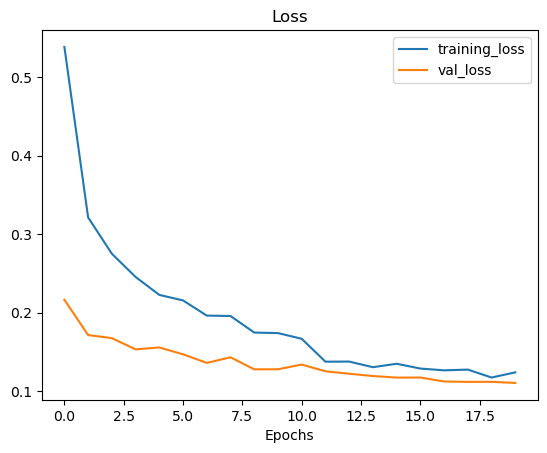

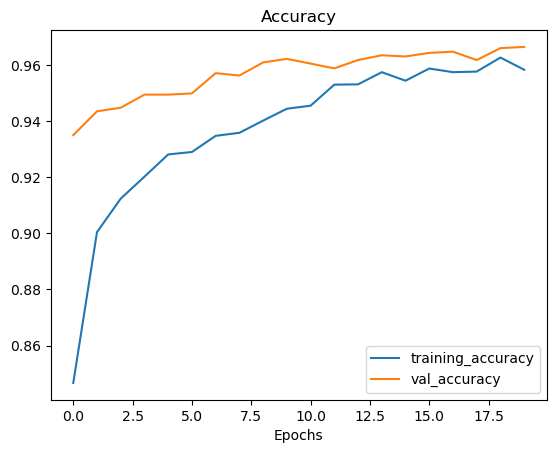

In [60]:
plot_loss_curves(EfficientNetV2M_history)

The learning curves look a little jumpy, but the dynamics look pretty good, there is a decrease in learning losses and an increase in testing accuracy.

# Model Evaluation

We use a set of test data to evaluate the accuracy of the model on new data

In [61]:
test_loss, test_accuracy = EfficientNetV2M_model.evaluate(test_data, verbose=0)

In [62]:
print("Test Loss: {:.5f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Test Loss: 0.13682
Test Accuracy: 96.37%


Given the limited data set, we obtained a good accuracy of 97%.

Let's look at the main classification metrics

In [63]:
pred_probs = EfficientNetV2M_model.predict(test_data, verbose=1)

74/74 [==============================] - 49s 605ms/step


In [64]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [65]:
y_labels = []
for images, labels in test_data.unbatch(): 
    y_labels.append(labels.numpy().argmax()) 
y_labels[:10] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Since the images in the test dataset were not shuffled, all the output labels correspond to the same class.

In [66]:
print('Classification Report \n')
target_names = class_names
print(classification_report(y_labels, pred_classes, target_names=target_names))

Classification Report 

              precision    recall  f1-score   support

     battery       1.00      0.97      0.98        95
  biological       0.97      0.99      0.98        99
   cardboard       0.97      0.96      0.96       234
     clothes       1.00      0.98      0.99       533
       glass       0.97      0.96      0.96       409
       metal       0.92      0.96      0.94       188
       paper       0.96      0.94      0.95       272
     plastic       0.93      0.92      0.93       253
       shoes       0.97      1.00      0.99       199
       trash       0.90      0.93      0.91        84

    accuracy                           0.96      2366
   macro avg       0.96      0.96      0.96      2366
weighted avg       0.96      0.96      0.96      2366



* The “Precision” column shows the percentage of correct predictions among all predictions for a particular class.
* The "Recall" column shows the percentage of images of a particular class that were predicted by the model to belong to that class.
* Column “F1” shows what percentage of model predictions were correct.
* The "Support" column shows how many images of each class were in the test dataset.

From the summary of metrics it is clear that the model classifies plastic worst of all, and best of all - things and various biological waste. However, despite the small data set, the model shows excellent performance in terms of Precision, Recall and F1 scores.

We visualize the error matrix to clearly see the correctness of class definitions

In [67]:
import itertools

In [68]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

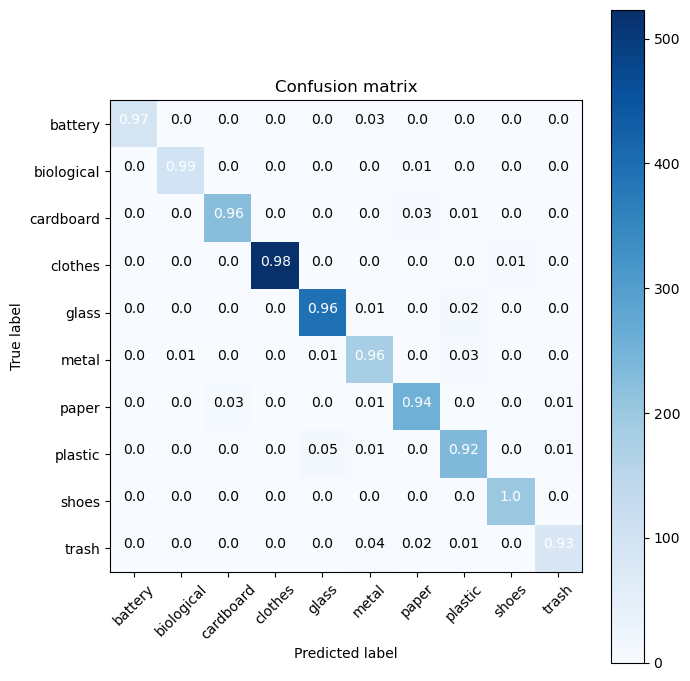

In [69]:
cm = confusion_matrix(y_labels, pred_classes)
plot_confusion_matrix(cm, class_names)

The rows of the matrix are responsible for the class predicted by the model, and the columns are for the actual class. From the error matrix, it is noticeable that in general the model’s errors are very small, although it sometimes incorrectly predicts categories, for example, it confuses plastic and glass.

Visualizing several model predictions

In [70]:
def pred_random_images(model_name, folder_path, class_names):
    plt.figure(figsize=(17, 10))
    for i in range(3):
        class_name = random.choice(class_names)
        filename = random.choice(os.listdir(folder_path + "/" + class_name))
        filepath = folder_path + "/" + class_name + "/" + filename
    
        img = tf.io.read_file(filepath)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])
     #  img = img/255.
        if i == 1:
            deploy_model_emission_tracker = EmissionsTracker()
            deploy_model_emission_tracker.start()
            pred_prob = model_name.predict(tf.expand_dims(img, axis=0), verbose=0)
            deploy_model_emissions: float = prepare_data_emission_tracker.stop()
            print(f"Deploy Model Carbon Emissions: {deploy_model_emissions} kg")
        else:
            pred_prob = model_name.predict(tf.expand_dims(img, axis=0), verbose=0)
            pred_class = class_names[pred_prob.argmax()]

  # Plot the image(s)
        plt.subplot(1, 3, i+1)
        plt.imshow(img/255.)
        if class_name == pred_class: 
            title_color = "g"
        else:
            title_color = "r"
        plt.title(f"Class: {class_name},\n Pred: {pred_class},\n Prob: {pred_prob.max():.2f}", c=title_color)
        plt.axis(False);

[codecarbon INFO @ 04:39:34] [setup] RAM Tracking...
[codecarbon INFO @ 04:39:34] [setup] GPU Tracking...
[codecarbon INFO @ 04:39:34] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 04:39:34] [setup] CPU Tracking...
[codecarbon WARNING @ 04:39:34] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 04:39:35] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 04:39:35] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 04:39:35] >>> Tracker's metadata:
[codecarbon INFO @ 04:39:35]   Platform system: Linux-5.15.133+-x86_64-with-glibc2.35
[codecarbon INFO @ 04:39:35]   Python version: 3.10.10
[codecarbon INFO @ 04:39:35]   CodeCarbon version: 2.3.2
[codecarbon INFO @ 04:39:35]   Available RAM : 31.358 GB
[codecarbon INFO @ 04:39:35]   CPU count: 4
[codecarbon INFO @ 04:39:35]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 04:39:35]   GPU

Deploy Model Carbon Emissions: 0.1566620397750908 kg


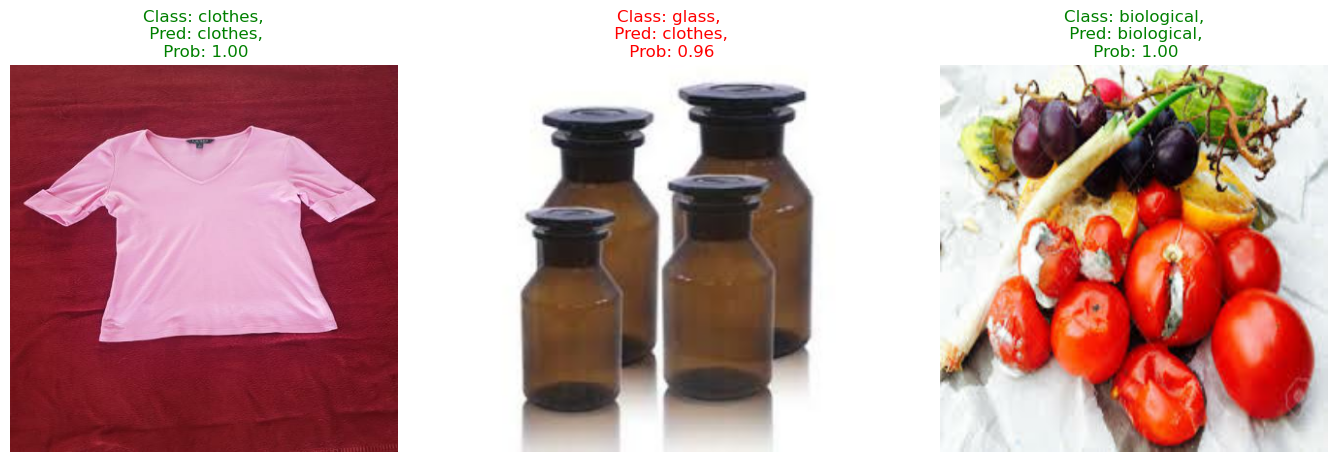

In [71]:
pred_random_images(EfficientNetV2M_model, test_path, class_names)

In [72]:
import pickle
pickle.dump(EfficientNetV2M_model,open("EfficientNetV2M_model.h5","wb"))
# EfficientNetV2M_model.save('EfficientNetV2M_model.h5')

In [73]:
ls ../working

EfficientNetV2M.h5        data/                      logs/
EfficientNetV2M_model.h5  emissions.csv              logs.zip
__notebook__.ipynb        garbage-classification.h5  runs/
